# Generación del modelo

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential

from sklearn.model_selection import KFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

SCENE="1"
CSV_FILE_PATH = "./dataSetEscena"+SCENE+".csv"  # path of csv file
DATA_PATH = "./sonidosParaEscena"+SCENE+"/" # path to folde

In [203]:
df = pd.read_csv(CSV_FILE_PATH)
df


,name,target,category
0,aspirador1.wav,1,aspirador
1,aspirador2.wav,1,aspirador
2,aspirador3.wav,1,aspirador
3,aspirador4.wav,1,aspirador
4,aspirador5.wav,1,aspirador
...,...,...,...
1494,idle45.wav,16,idle
1495,idle46.wav,16,idle
1496,idle47.wav,16,idle
1497,idle48.wav,16,idle


In [204]:
sample_df = df.drop_duplicates(subset=['target'])
sample_df

,name,target,category
0,aspirador1.wav,1,aspirador
100,cisterna1.wav,2,cisterna
150,conversacion1.wav,3,conversacion
250,cubiertos_sartenes1.wav,4,cubiertos_sartenes
350,despertador1.wav,5,despertador
450,ducha1.wav,6,ducha
550,estractor1.wav,7,estractor
650,grifo_banio1.wav,8,grifo_banio
750,grifo_cocina1.wav,9,grifo_cocina
850,impresora1.wav,10,impresora


0it [00:00, ?it/s]

22050

1it [00:00,  9.73it/s]

22050

2it [00:00,  9.79it/s]

22050

22050

4it [00:00,  9.86it/s]

22050

5it [00:00,  9.77it/s]

22050

6it [00:00,  9.67it/s]

22050

7it [00:00,  9.66it/s]

22050

8it [00:00,  9.41it/s]

22050

9it [00:00,  9.48it/s]

22050

22050

11it [00:01,  9.66it/s]

22050

22050

13it [00:01,  9.87it/s]

22050

14it [00:01,  9.86it/s]

22050

15it [00:01,  9.74it/s]

22050

16it [00:01,  9.71it/s]


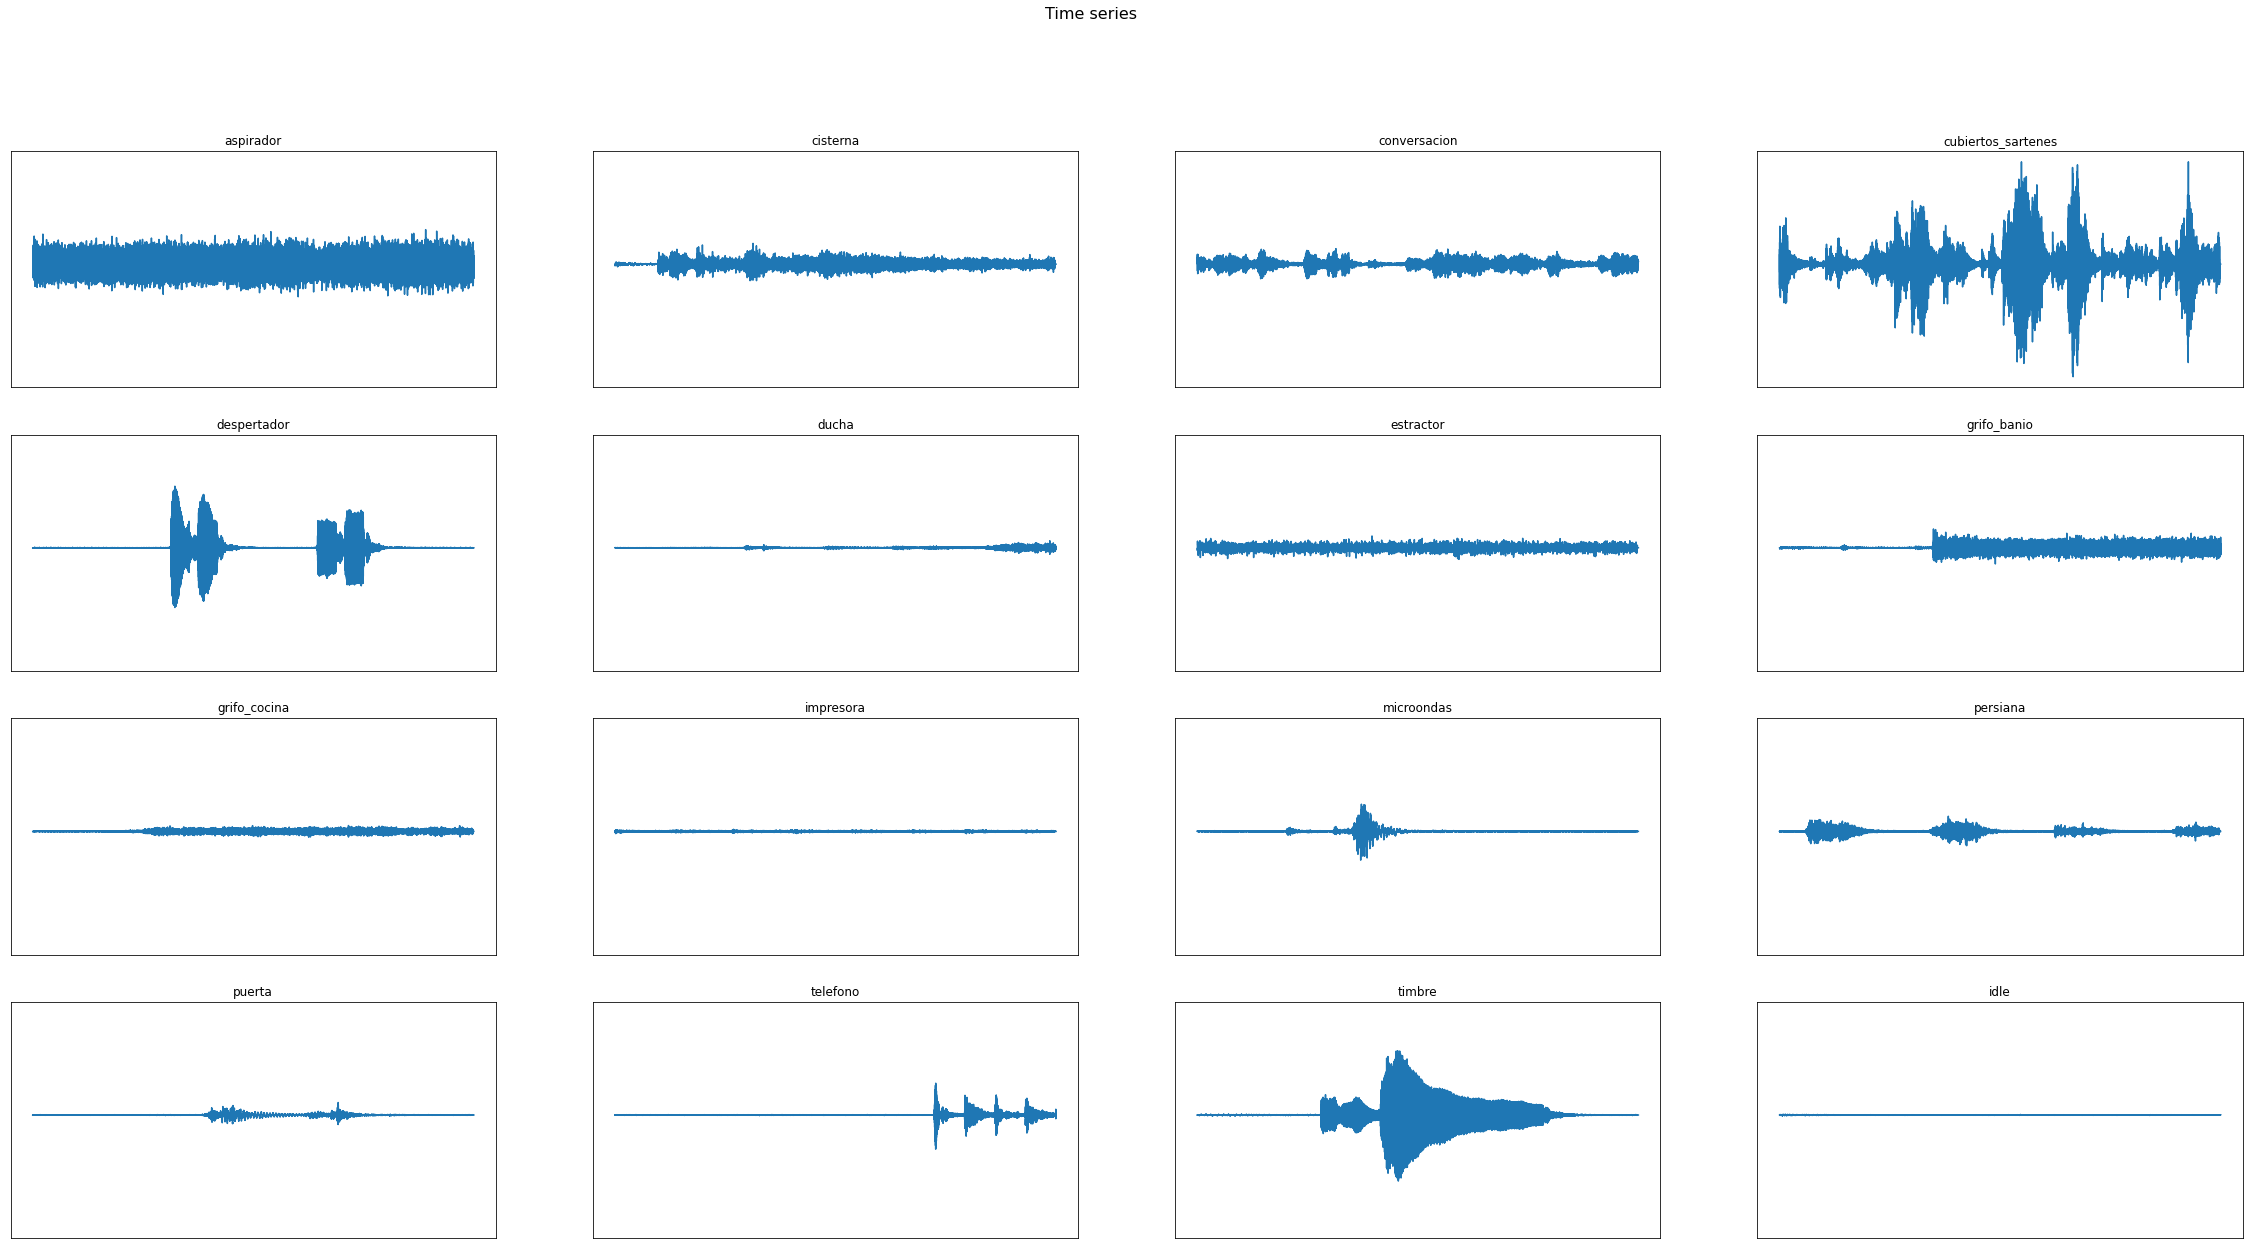

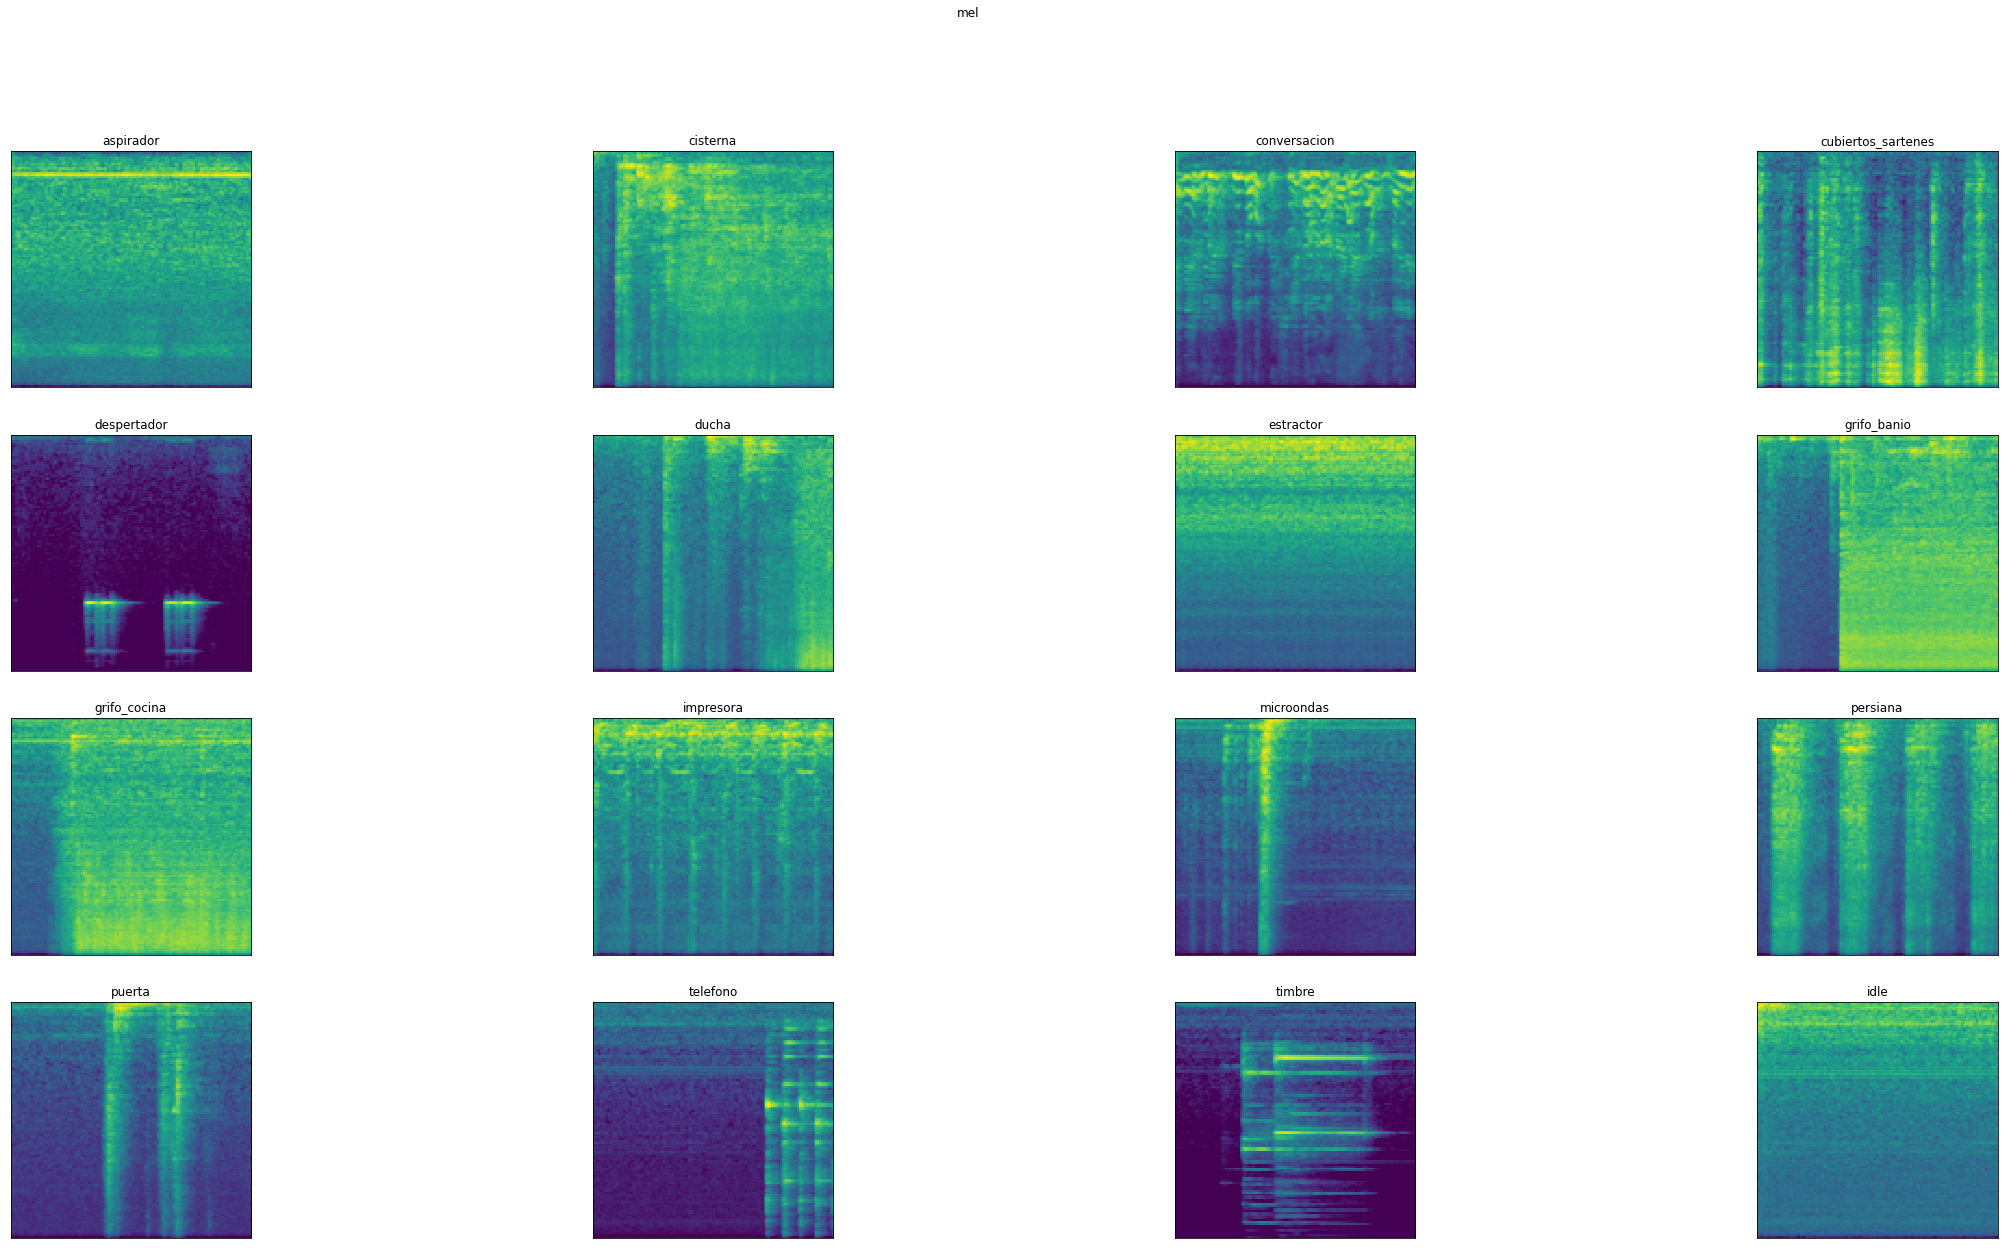

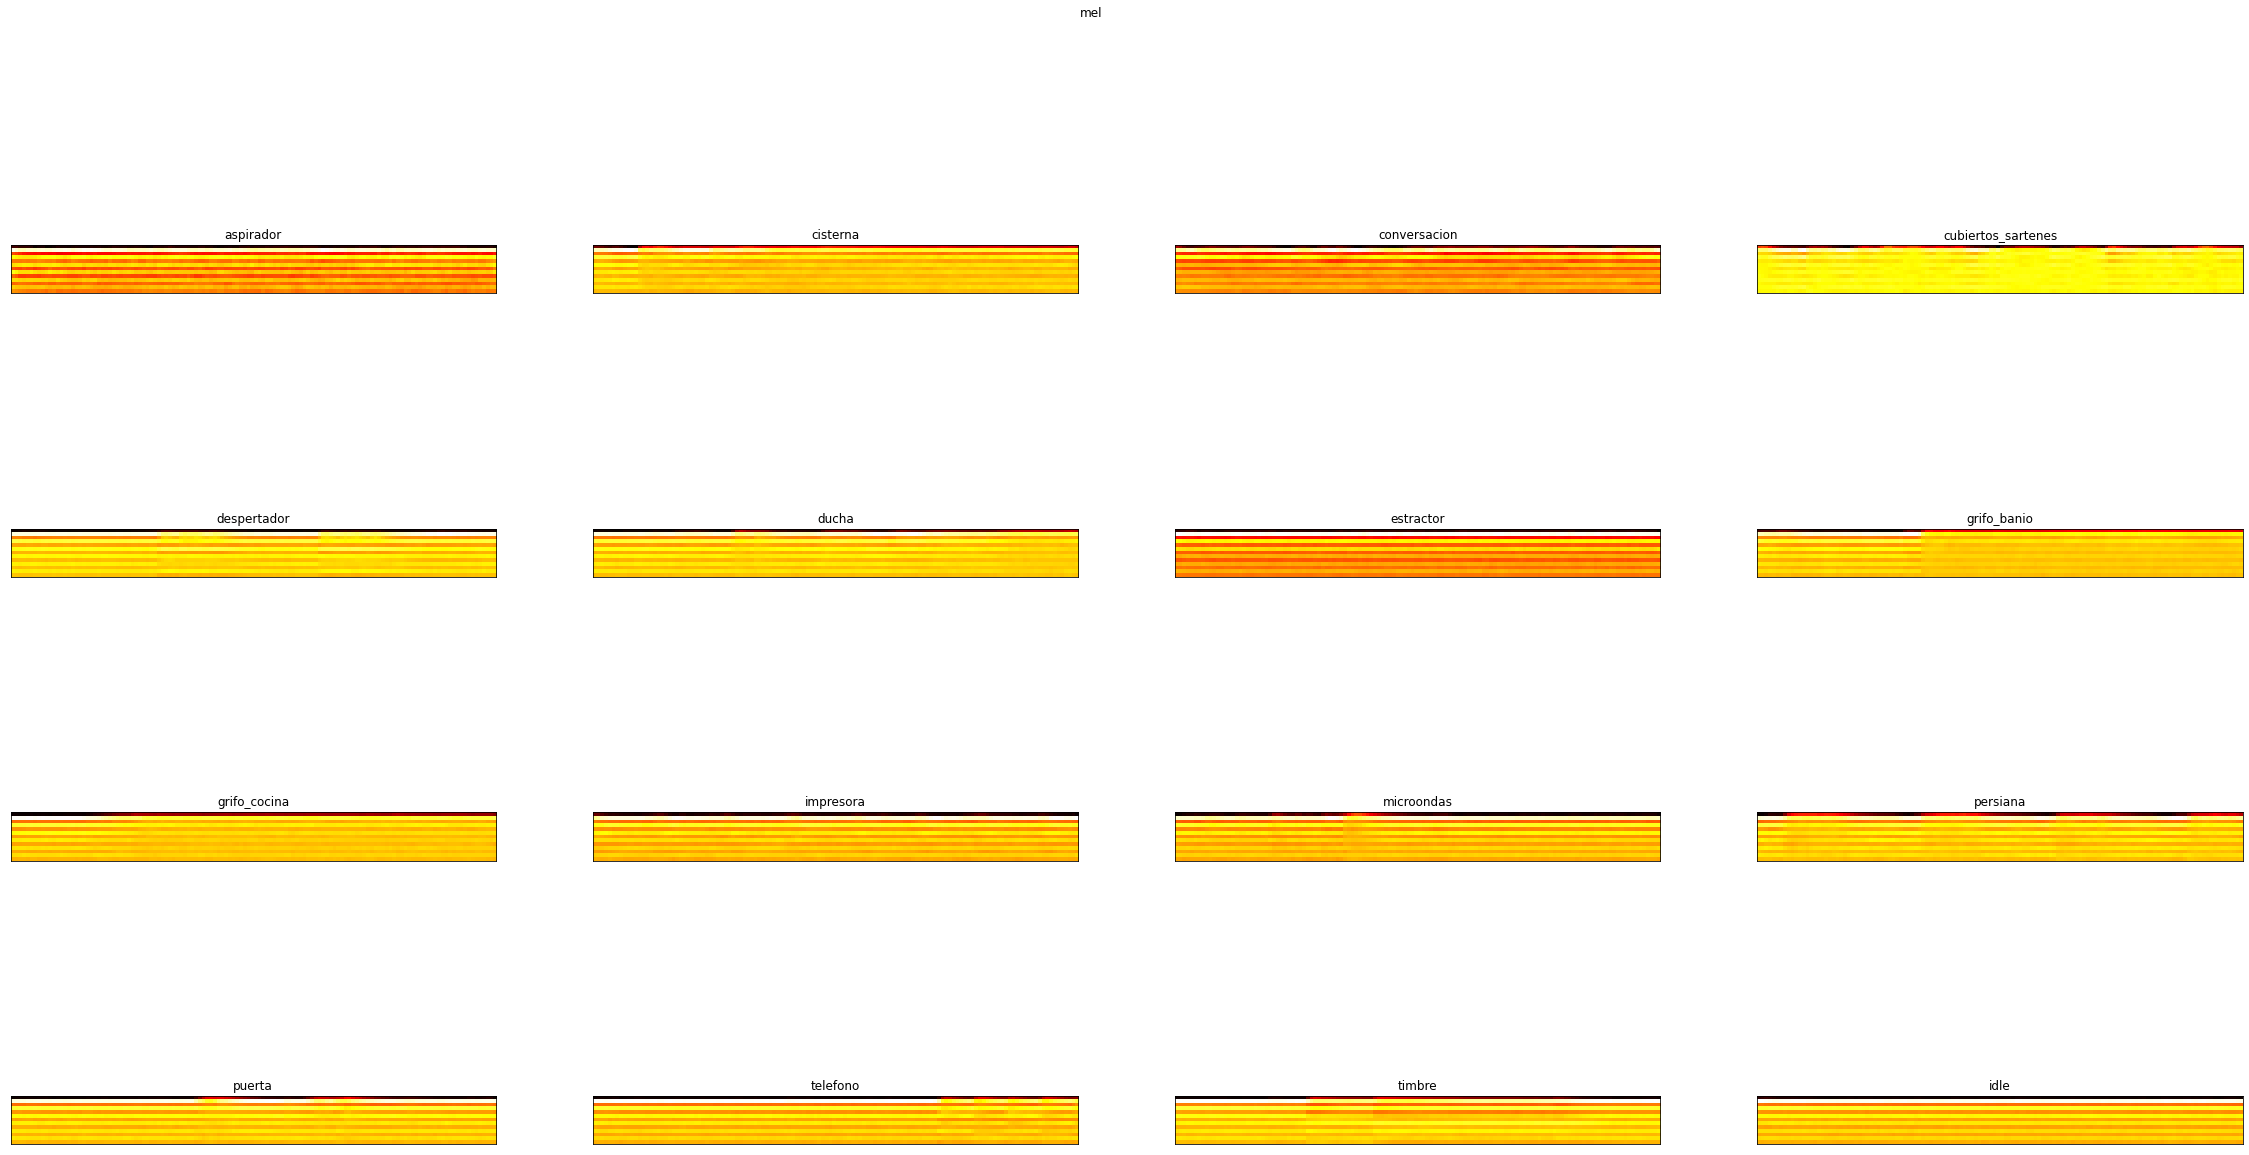

In [205]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    rate
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc
    
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=4 , ncols=4 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(4):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1
            
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=4 , ncols=4 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=16)
    i=0
    for x in range(4):
        for y in range(4):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

plot_signal(signals)
dis_feature(mel_spectrograms)
dis_feature(mfccs, cmap='hot')

In [206]:
X , y = [] , []
for data in tqdm(df.iterrows()):
  data  
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  sr
  mfcc_ = librosa.feature.mfcc(sig , sr=sr, n_mfcc=13)
  X.append(mfcc_)
  y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y-1 , num_classes=16)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape
y.shape


0it [00:00, ?it/s]

(0,
 name        aspirador1.wav
 target                   1
 category         aspirador
 Name: 0, dtype: object)

22050

(1,
 name        aspirador2.wav
 target                   1
 category         aspirador
 Name: 1, dtype: object)

22050

2it [00:00, 10.78it/s]

(2,
 name        aspirador3.wav
 target                   1
 category         aspirador
 Name: 2, dtype: object)

22050

(3,
 name        aspirador4.wav
 target                   1
 category         aspirador
 Name: 3, dtype: object)

22050

4it [00:00, 10.78it/s]

(4,
 name        aspirador5.wav
 target                   1
 category         aspirador
 Name: 4, dtype: object)

22050

(5,
 name        aspirador6.wav
 target                   1
 category         aspirador
 Name: 5, dtype: object)

22050

6it [00:00, 10.76it/s]

(6,
 name        aspirador7.wav
 target                   1
 category         aspirador
 Name: 6, dtype: object)

22050

(7,
 name        aspirador8.wav
 target                   1
 category         aspirador
 Name: 7, dtype: object)

22050

8it [00:00, 10.57it/s]

(8,
 name        aspirador9.wav
 target                   1
 category         aspirador
 Name: 8, dtype: object)

22050

(9,
 name        aspirador10.wav
 target                    1
 category          aspirador
 Name: 9, dtype: object)

22050

10it [00:00, 10.60it/s]

(10,
 name        aspirador11.wav
 target                    1
 category          aspirador
 Name: 10, dtype: object)

22050

11it [00:01,  9.61it/s]

(11,
 name        aspirador12.wav
 target                    1
 category          aspirador
 Name: 11, dtype: object)

22050

(12,
 name        aspirador13.wav
 target                    1
 category          aspirador
 Name: 12, dtype: object)

22050

13it [00:01,  9.83it/s]

(13,
 name        aspirador14.wav
 target                    1
 category          aspirador
 Name: 13, dtype: object)

22050

(14,
 name        aspirador15.wav
 target                    1
 category          aspirador
 Name: 14, dtype: object)

22050

15it [00:01, 10.13it/s]

(15,
 name        aspirador16.wav
 target                    1
 category          aspirador
 Name: 15, dtype: object)

22050

(16,
 name        aspirador17.wav
 target                    1
 category          aspirador
 Name: 16, dtype: object)

22050

17it [00:01, 10.28it/s]

(17,
 name        aspirador18.wav
 target                    1
 category          aspirador
 Name: 17, dtype: object)

22050

(18,
 name        aspirador19.wav
 target                    1
 category          aspirador
 Name: 18, dtype: object)

22050

19it [00:01, 10.28it/s]

(19,
 name        aspirador20.wav
 target                    1
 category          aspirador
 Name: 19, dtype: object)

22050

(20,
 name        aspirador21.wav
 target                    1
 category          aspirador
 Name: 20, dtype: object)

22050

21it [00:02, 10.41it/s]

(21,
 name        aspirador22.wav
 target                    1
 category          aspirador
 Name: 21, dtype: object)

22050

(22,
 name        aspirador23.wav
 target                    1
 category          aspirador
 Name: 22, dtype: object)

22050

23it [00:02, 10.41it/s]

(23,
 name        aspirador24.wav
 target                    1
 category          aspirador
 Name: 23, dtype: object)

22050

(24,
 name        aspirador25.wav
 target                    1
 category          aspirador
 Name: 24, dtype: object)

22050

25it [00:02, 10.52it/s]

(25,
 name        aspirador26.wav
 target                    1
 category          aspirador
 Name: 25, dtype: object)

22050

(26,
 name        aspirador27.wav
 target                    1
 category          aspirador
 Name: 26, dtype: object)

22050

27it [00:02, 10.71it/s]

(27,
 name        aspirador28.wav
 target                    1
 category          aspirador
 Name: 27, dtype: object)

22050

(28,
 name        aspirador29.wav
 target                    1
 category          aspirador
 Name: 28, dtype: object)

22050

29it [00:02, 10.77it/s]

(29,
 name        aspirador30.wav
 target                    1
 category          aspirador
 Name: 29, dtype: object)

22050

(30,
 name        aspirador31.wav
 target                    1
 category          aspirador
 Name: 30, dtype: object)

22050

31it [00:02, 10.63it/s]

(31,
 name        aspirador32.wav
 target                    1
 category          aspirador
 Name: 31, dtype: object)

22050

(32,
 name        aspirador33.wav
 target                    1
 category          aspirador
 Name: 32, dtype: object)

22050

33it [00:03, 10.70it/s]

(33,
 name        aspirador34.wav
 target                    1
 category          aspirador
 Name: 33, dtype: object)

22050

(34,
 name        aspirador35.wav
 target                    1
 category          aspirador
 Name: 34, dtype: object)

22050

35it [00:03, 10.72it/s]

(35,
 name        aspirador36.wav
 target                    1
 category          aspirador
 Name: 35, dtype: object)

22050

(36,
 name        aspirador37.wav
 target                    1
 category          aspirador
 Name: 36, dtype: object)

22050

37it [00:03, 10.77it/s]

(37,
 name        aspirador38.wav
 target                    1
 category          aspirador
 Name: 37, dtype: object)

22050

(38,
 name        aspirador39.wav
 target                    1
 category          aspirador
 Name: 38, dtype: object)

22050

39it [00:03, 10.66it/s]

(39,
 name        aspirador40.wav
 target                    1
 category          aspirador
 Name: 39, dtype: object)

22050

(40,
 name        aspirador41.wav
 target                    1
 category          aspirador
 Name: 40, dtype: object)

22050

41it [00:03, 10.66it/s]

(41,
 name        aspirador42.wav
 target                    1
 category          aspirador
 Name: 41, dtype: object)

22050

(42,
 name        aspirador43.wav
 target                    1
 category          aspirador
 Name: 42, dtype: object)

22050

43it [00:04, 10.56it/s]

(43,
 name        aspirador44.wav
 target                    1
 category          aspirador
 Name: 43, dtype: object)

22050

(44,
 name        aspirador45.wav
 target                    1
 category          aspirador
 Name: 44, dtype: object)

22050

45it [00:04, 10.66it/s]

(45,
 name        aspirador46.wav
 target                    1
 category          aspirador
 Name: 45, dtype: object)

22050

(46,
 name        aspirador47.wav
 target                    1
 category          aspirador
 Name: 46, dtype: object)

22050

47it [00:04, 10.66it/s]

(47,
 name        aspirador48.wav
 target                    1
 category          aspirador
 Name: 47, dtype: object)

22050

(48,
 name        aspirador49.wav
 target                    1
 category          aspirador
 Name: 48, dtype: object)

22050

49it [00:04, 10.10it/s]

(49,
 name        aspirador50.wav
 target                    1
 category          aspirador
 Name: 49, dtype: object)

22050

(50,
 name        aspirador51.wav
 target                    1
 category          aspirador
 Name: 50, dtype: object)

22050

51it [00:04, 10.41it/s]

(51,
 name        aspirador52.wav
 target                    1
 category          aspirador
 Name: 51, dtype: object)

22050

(52,
 name        aspirador53.wav
 target                    1
 category          aspirador
 Name: 52, dtype: object)

22050

53it [00:05, 10.52it/s]

(53,
 name        aspirador54.wav
 target                    1
 category          aspirador
 Name: 53, dtype: object)

22050

(54,
 name        aspirador55.wav
 target                    1
 category          aspirador
 Name: 54, dtype: object)

22050

55it [00:05, 10.51it/s]

(55,
 name        aspirador56.wav
 target                    1
 category          aspirador
 Name: 55, dtype: object)

22050

(56,
 name        aspirador57.wav
 target                    1
 category          aspirador
 Name: 56, dtype: object)

22050

57it [00:05, 10.57it/s]

(57,
 name        aspirador58.wav
 target                    1
 category          aspirador
 Name: 57, dtype: object)

22050

(58,
 name        aspirador59.wav
 target                    1
 category          aspirador
 Name: 58, dtype: object)

22050

59it [00:05, 10.18it/s]

(59,
 name        aspirador60.wav
 target                    1
 category          aspirador
 Name: 59, dtype: object)

22050

(60,
 name        aspirador61.wav
 target                    1
 category          aspirador
 Name: 60, dtype: object)

22050

61it [00:05, 10.20it/s]

(61,
 name        aspirador62.wav
 target                    1
 category          aspirador
 Name: 61, dtype: object)

22050

(62,
 name        aspirador63.wav
 target                    1
 category          aspirador
 Name: 62, dtype: object)

22050

63it [00:06, 10.29it/s]

(63,
 name        aspirador64.wav
 target                    1
 category          aspirador
 Name: 63, dtype: object)

22050

(64,
 name        aspirador65.wav
 target                    1
 category          aspirador
 Name: 64, dtype: object)

22050

65it [00:06, 10.40it/s]

(65,
 name        aspirador66.wav
 target                    1
 category          aspirador
 Name: 65, dtype: object)

22050

(66,
 name        aspirador67.wav
 target                    1
 category          aspirador
 Name: 66, dtype: object)

22050

67it [00:06,  9.84it/s]

(67,
 name        aspirador68.wav
 target                    1
 category          aspirador
 Name: 67, dtype: object)

22050

(68,
 name        aspirador69.wav
 target                    1
 category          aspirador
 Name: 68, dtype: object)

22050

69it [00:06, 10.15it/s]

(69,
 name        aspirador70.wav
 target                    1
 category          aspirador
 Name: 69, dtype: object)

22050

(70,
 name        aspirador71.wav
 target                    1
 category          aspirador
 Name: 70, dtype: object)

22050

71it [00:06, 10.30it/s]

(71,
 name        aspirador72.wav
 target                    1
 category          aspirador
 Name: 71, dtype: object)

22050

(72,
 name        aspirador73.wav
 target                    1
 category          aspirador
 Name: 72, dtype: object)

22050

73it [00:06, 10.27it/s]

(73,
 name        aspirador74.wav
 target                    1
 category          aspirador
 Name: 73, dtype: object)

22050

(74,
 name        aspirador75.wav
 target                    1
 category          aspirador
 Name: 74, dtype: object)

22050

75it [00:07, 10.46it/s]

(75,
 name        aspirador76.wav
 target                    1
 category          aspirador
 Name: 75, dtype: object)

22050

(76,
 name        aspirador77.wav
 target                    1
 category          aspirador
 Name: 76, dtype: object)

22050

77it [00:07, 10.56it/s]

(77,
 name        aspirador78.wav
 target                    1
 category          aspirador
 Name: 77, dtype: object)

22050

(78,
 name        aspirador79.wav
 target                    1
 category          aspirador
 Name: 78, dtype: object)

22050

79it [00:07,  9.67it/s]

(79,
 name        aspirador80.wav
 target                    1
 category          aspirador
 Name: 79, dtype: object)

22050

(80,
 name        aspirador81.wav
 target                    1
 category          aspirador
 Name: 80, dtype: object)

22050

81it [00:07,  9.86it/s]

(81,
 name        aspirador82.wav
 target                    1
 category          aspirador
 Name: 81, dtype: object)

22050

82it [00:07,  9.71it/s]

(82,
 name        aspirador83.wav
 target                    1
 category          aspirador
 Name: 82, dtype: object)

22050

83it [00:08,  9.72it/s]

(83,
 name        aspirador84.wav
 target                    1
 category          aspirador
 Name: 83, dtype: object)

22050

84it [00:08,  9.72it/s]

(84,
 name        aspirador85.wav
 target                    1
 category          aspirador
 Name: 84, dtype: object)

22050

85it [00:08,  9.78it/s]

(85,
 name        aspirador86.wav
 target                    1
 category          aspirador
 Name: 85, dtype: object)

22050

(86,
 name        aspirador87.wav
 target                    1
 category          aspirador
 Name: 86, dtype: object)

22050

87it [00:08,  9.96it/s]

(87,
 name        aspirador88.wav
 target                    1
 category          aspirador
 Name: 87, dtype: object)

22050

(88,
 name        aspirador89.wav
 target                    1
 category          aspirador
 Name: 88, dtype: object)

22050

89it [00:08, 10.07it/s]

(89,
 name        aspirador90.wav
 target                    1
 category          aspirador
 Name: 89, dtype: object)

22050

(90,
 name        aspirador91.wav
 target                    1
 category          aspirador
 Name: 90, dtype: object)

22050

91it [00:08, 10.23it/s]

(91,
 name        aspirador92.wav
 target                    1
 category          aspirador
 Name: 91, dtype: object)

22050

(92,
 name        aspirador93.wav
 target                    1
 category          aspirador
 Name: 92, dtype: object)

22050

93it [00:08, 10.35it/s]

(93,
 name        aspirador94.wav
 target                    1
 category          aspirador
 Name: 93, dtype: object)

22050

(94,
 name        aspirador95.wav
 target                    1
 category          aspirador
 Name: 94, dtype: object)

22050

95it [00:09, 10.35it/s]

(95,
 name        aspirador96.wav
 target                    1
 category          aspirador
 Name: 95, dtype: object)

22050

(96,
 name        aspirador97.wav
 target                    1
 category          aspirador
 Name: 96, dtype: object)

22050

97it [00:09, 10.41it/s]

(97,
 name        aspirador98.wav
 target                    1
 category          aspirador
 Name: 97, dtype: object)

22050

(98,
 name        aspirador99.wav
 target                    1
 category          aspirador
 Name: 98, dtype: object)

22050

99it [00:09, 10.40it/s]

(99,
 name        aspirador100.wav
 target                     1
 category           aspirador
 Name: 99, dtype: object)

22050

(100,
 name        cisterna1.wav
 target                  2
 category         cisterna
 Name: 100, dtype: object)

22050

101it [00:09, 10.56it/s]

(101,
 name        cisterna2.wav
 target                  2
 category         cisterna
 Name: 101, dtype: object)

22050

(102,
 name        cisterna3.wav
 target                  2
 category         cisterna
 Name: 102, dtype: object)

22050

103it [00:09, 10.68it/s]

(103,
 name        cisterna4.wav
 target                  2
 category         cisterna
 Name: 103, dtype: object)

22050

(104,
 name        cisterna5.wav
 target                  2
 category         cisterna
 Name: 104, dtype: object)

22050

105it [00:10, 10.49it/s]

(105,
 name        cisterna6.wav
 target                  2
 category         cisterna
 Name: 105, dtype: object)

22050

(106,
 name        cisterna7.wav
 target                  2
 category         cisterna
 Name: 106, dtype: object)

22050

107it [00:10, 10.19it/s]

(107,
 name        cisterna8.wav
 target                  2
 category         cisterna
 Name: 107, dtype: object)

22050

(108,
 name        cisterna9.wav
 target                  2
 category         cisterna
 Name: 108, dtype: object)

22050

109it [00:10, 10.23it/s]

(109,
 name        cisterna10.wav
 target                   2
 category          cisterna
 Name: 109, dtype: object)

22050

(110,
 name        cisterna11.wav
 target                   2
 category          cisterna
 Name: 110, dtype: object)

22050

111it [00:10, 10.28it/s]

(111,
 name        cisterna12.wav
 target                   2
 category          cisterna
 Name: 111, dtype: object)

22050

(112,
 name        cisterna13.wav
 target                   2
 category          cisterna
 Name: 112, dtype: object)

22050

113it [00:10, 10.00it/s]

(113,
 name        cisterna14.wav
 target                   2
 category          cisterna
 Name: 113, dtype: object)

22050

(114,
 name        cisterna15.wav
 target                   2
 category          cisterna
 Name: 114, dtype: object)

22050

115it [00:11, 10.16it/s]

(115,
 name        cisterna16.wav
 target                   2
 category          cisterna
 Name: 115, dtype: object)

22050

(116,
 name        cisterna17.wav
 target                   2
 category          cisterna
 Name: 116, dtype: object)

22050

117it [00:11, 10.23it/s]

(117,
 name        cisterna18.wav
 target                   2
 category          cisterna
 Name: 117, dtype: object)

22050

(118,
 name        cisterna19.wav
 target                   2
 category          cisterna
 Name: 118, dtype: object)

22050

119it [00:11, 10.37it/s]

(119,
 name        cisterna20.wav
 target                   2
 category          cisterna
 Name: 119, dtype: object)

22050

(120,
 name        cisterna21.wav
 target                   2
 category          cisterna
 Name: 120, dtype: object)

22050

121it [00:11, 10.59it/s]

(121,
 name        cisterna22.wav
 target                   2
 category          cisterna
 Name: 121, dtype: object)

22050

(122,
 name        cisterna23.wav
 target                   2
 category          cisterna
 Name: 122, dtype: object)

22050

123it [00:11, 10.72it/s]

(123,
 name        cisterna24.wav
 target                   2
 category          cisterna
 Name: 123, dtype: object)

22050

(124,
 name        cisterna25.wav
 target                   2
 category          cisterna
 Name: 124, dtype: object)

22050

125it [00:12, 10.26it/s]

(125,
 name        cisterna26.wav
 target                   2
 category          cisterna
 Name: 125, dtype: object)

22050

(126,
 name        cisterna27.wav
 target                   2
 category          cisterna
 Name: 126, dtype: object)

22050

127it [00:12, 10.20it/s]

(127,
 name        cisterna28.wav
 target                   2
 category          cisterna
 Name: 127, dtype: object)

22050

(128,
 name        cisterna29.wav
 target                   2
 category          cisterna
 Name: 128, dtype: object)

22050

129it [00:12, 10.01it/s]

(129,
 name        cisterna30.wav
 target                   2
 category          cisterna
 Name: 129, dtype: object)

22050

(130,
 name        cisterna31.wav
 target                   2
 category          cisterna
 Name: 130, dtype: object)

22050

131it [00:12, 10.12it/s]

(131,
 name        cisterna32.wav
 target                   2
 category          cisterna
 Name: 131, dtype: object)

22050

(132,
 name        cisterna33.wav
 target                   2
 category          cisterna
 Name: 132, dtype: object)

22050

133it [00:12, 10.41it/s]

(133,
 name        cisterna34.wav
 target                   2
 category          cisterna
 Name: 133, dtype: object)

22050

(134,
 name        cisterna35.wav
 target                   2
 category          cisterna
 Name: 134, dtype: object)

22050

135it [00:13, 10.50it/s]

(135,
 name        cisterna36.wav
 target                   2
 category          cisterna
 Name: 135, dtype: object)

22050

(136,
 name        cisterna37.wav
 target                   2
 category          cisterna
 Name: 136, dtype: object)

22050

137it [00:13, 10.37it/s]

(137,
 name        cisterna38.wav
 target                   2
 category          cisterna
 Name: 137, dtype: object)

22050

(138,
 name        cisterna39.wav
 target                   2
 category          cisterna
 Name: 138, dtype: object)

22050

139it [00:13, 10.47it/s]

(139,
 name        cisterna40.wav
 target                   2
 category          cisterna
 Name: 139, dtype: object)

22050

(140,
 name        cisterna41.wav
 target                   2
 category          cisterna
 Name: 140, dtype: object)

22050

141it [00:13, 10.29it/s]

(141,
 name        cisterna42.wav
 target                   2
 category          cisterna
 Name: 141, dtype: object)

22050

(142,
 name        cisterna43.wav
 target                   2
 category          cisterna
 Name: 142, dtype: object)

22050

143it [00:13, 10.33it/s]

(143,
 name        cisterna44.wav
 target                   2
 category          cisterna
 Name: 143, dtype: object)

22050

(144,
 name        cisterna45.wav
 target                   2
 category          cisterna
 Name: 144, dtype: object)

22050

145it [00:13, 10.48it/s]

(145,
 name        cisterna46.wav
 target                   2
 category          cisterna
 Name: 145, dtype: object)

22050

(146,
 name        cisterna47.wav
 target                   2
 category          cisterna
 Name: 146, dtype: object)

22050

147it [00:14, 10.45it/s]

(147,
 name        cisterna48.wav
 target                   2
 category          cisterna
 Name: 147, dtype: object)

22050

(148,
 name        cisterna49.wav
 target                   2
 category          cisterna
 Name: 148, dtype: object)

22050

149it [00:14, 10.01it/s]

(149,
 name        cisterna50.wav
 target                   2
 category          cisterna
 Name: 149, dtype: object)

22050

(150,
 name        conversacion1.wav
 target                      3
 category         conversacion
 Name: 150, dtype: object)

22050

151it [00:14,  8.79it/s]

(151,
 name        conversacion2.wav
 target                      3
 category         conversacion
 Name: 151, dtype: object)

22050

152it [00:14,  9.10it/s]

(152,
 name        conversacion3.wav
 target                      3
 category         conversacion
 Name: 152, dtype: object)

22050

153it [00:14,  9.31it/s]

(153,
 name        conversacion4.wav
 target                      3
 category         conversacion
 Name: 153, dtype: object)

22050

154it [00:15,  9.43it/s]

(154,
 name        conversacion5.wav
 target                      3
 category         conversacion
 Name: 154, dtype: object)

22050

(155,
 name        conversacion6.wav
 target                      3
 category         conversacion
 Name: 155, dtype: object)

22050

156it [00:15,  9.70it/s]

(156,
 name        conversacion7.wav
 target                      3
 category         conversacion
 Name: 156, dtype: object)

22050

(157,
 name        conversacion8.wav
 target                      3
 category         conversacion
 Name: 157, dtype: object)

22050

158it [00:15,  9.99it/s]

(158,
 name        conversacion9.wav
 target                      3
 category         conversacion
 Name: 158, dtype: object)

22050

(159,
 name        conversacion10.wav
 target                       3
 category          conversacion
 Name: 159, dtype: object)

22050

160it [00:15,  9.98it/s]

(160,
 name        conversacion11.wav
 target                       3
 category          conversacion
 Name: 160, dtype: object)

22050

(161,
 name        conversacion12.wav
 target                       3
 category          conversacion
 Name: 161, dtype: object)

22050

162it [00:15, 10.27it/s]

(162,
 name        conversacion13.wav
 target                       3
 category          conversacion
 Name: 162, dtype: object)

22050

(163,
 name        conversacion14.wav
 target                       3
 category          conversacion
 Name: 163, dtype: object)

22050

164it [00:15, 10.15it/s]

(164,
 name        conversacion15.wav
 target                       3
 category          conversacion
 Name: 164, dtype: object)

22050

(165,
 name        conversacion16.wav
 target                       3
 category          conversacion
 Name: 165, dtype: object)

22050

166it [00:16, 10.24it/s]

(166,
 name        conversacion17.wav
 target                       3
 category          conversacion
 Name: 166, dtype: object)

22050

(167,
 name        conversacion18.wav
 target                       3
 category          conversacion
 Name: 167, dtype: object)

22050

168it [00:16, 10.35it/s]

(168,
 name        conversacion19.wav
 target                       3
 category          conversacion
 Name: 168, dtype: object)

22050

(169,
 name        conversacion20.wav
 target                       3
 category          conversacion
 Name: 169, dtype: object)

22050

170it [00:16, 10.03it/s]

(170,
 name        conversacion21.wav
 target                       3
 category          conversacion
 Name: 170, dtype: object)

22050

(171,
 name        conversacion22.wav
 target                       3
 category          conversacion
 Name: 171, dtype: object)

22050

172it [00:16,  9.70it/s]

(172,
 name        conversacion23.wav
 target                       3
 category          conversacion
 Name: 172, dtype: object)

22050

(173,
 name        conversacion24.wav
 target                       3
 category          conversacion
 Name: 173, dtype: object)

22050

174it [00:16,  9.88it/s]

(174,
 name        conversacion25.wav
 target                       3
 category          conversacion
 Name: 174, dtype: object)

22050

175it [00:17,  9.69it/s]

(175,
 name        conversacion26.wav
 target                       3
 category          conversacion
 Name: 175, dtype: object)

22050

176it [00:17,  9.68it/s]

(176,
 name        conversacion27.wav
 target                       3
 category          conversacion
 Name: 176, dtype: object)

22050

177it [00:17,  9.67it/s]

(177,
 name        conversacion28.wav
 target                       3
 category          conversacion
 Name: 177, dtype: object)

22050

(178,
 name        conversacion29.wav
 target                       3
 category          conversacion
 Name: 178, dtype: object)

22050

179it [00:17,  9.83it/s]

(179,
 name        conversacion30.wav
 target                       3
 category          conversacion
 Name: 179, dtype: object)

22050

(180,
 name        conversacion31.wav
 target                       3
 category          conversacion
 Name: 180, dtype: object)

22050

181it [00:17,  9.93it/s]

(181,
 name        conversacion32.wav
 target                       3
 category          conversacion
 Name: 181, dtype: object)

22050

182it [00:17,  9.70it/s]

(182,
 name        conversacion33.wav
 target                       3
 category          conversacion
 Name: 182, dtype: object)

22050

(183,
 name        conversacion34.wav
 target                       3
 category          conversacion
 Name: 183, dtype: object)

22050

184it [00:17,  9.85it/s]

(184,
 name        conversacion35.wav
 target                       3
 category          conversacion
 Name: 184, dtype: object)

22050

(185,
 name        conversacion36.wav
 target                       3
 category          conversacion
 Name: 185, dtype: object)

22050

186it [00:18,  9.85it/s]

(186,
 name        conversacion37.wav
 target                       3
 category          conversacion
 Name: 186, dtype: object)

22050

187it [00:18,  9.27it/s]

(187,
 name        conversacion38.wav
 target                       3
 category          conversacion
 Name: 187, dtype: object)

22050

(188,
 name        conversacion39.wav
 target                       3
 category          conversacion
 Name: 188, dtype: object)

22050

189it [00:18,  9.48it/s]

(189,
 name        conversacion40.wav
 target                       3
 category          conversacion
 Name: 189, dtype: object)

22050

(190,
 name        conversacion41.wav
 target                       3
 category          conversacion
 Name: 190, dtype: object)

22050

191it [00:18,  9.78it/s]

(191,
 name        conversacion42.wav
 target                       3
 category          conversacion
 Name: 191, dtype: object)

22050

(192,
 name        conversacion43.wav
 target                       3
 category          conversacion
 Name: 192, dtype: object)

22050

193it [00:18,  9.20it/s]

(193,
 name        conversacion44.wav
 target                       3
 category          conversacion
 Name: 193, dtype: object)

22050

(194,
 name        conversacion45.wav
 target                       3
 category          conversacion
 Name: 194, dtype: object)

22050

195it [00:19,  9.71it/s]

(195,
 name        conversacion46.wav
 target                       3
 category          conversacion
 Name: 195, dtype: object)

22050

196it [00:19,  9.72it/s]

(196,
 name        conversacion47.wav
 target                       3
 category          conversacion
 Name: 196, dtype: object)

22050

197it [00:19,  8.99it/s]

(197,
 name        conversacion48.wav
 target                       3
 category          conversacion
 Name: 197, dtype: object)

22050

198it [00:19,  9.13it/s]

(198,
 name        conversacion49.wav
 target                       3
 category          conversacion
 Name: 198, dtype: object)

22050

199it [00:19,  9.30it/s]

(199,
 name        conversacion50.wav
 target                       3
 category          conversacion
 Name: 199, dtype: object)

22050

(200,
 name        conversacion51.wav
 target                       3
 category          conversacion
 Name: 200, dtype: object)

22050

201it [00:19,  9.62it/s]

(201,
 name        conversacion52.wav
 target                       3
 category          conversacion
 Name: 201, dtype: object)

22050

(202,
 name        conversacion53.wav
 target                       3
 category          conversacion
 Name: 202, dtype: object)

22050

203it [00:19,  9.78it/s]

(203,
 name        conversacion54.wav
 target                       3
 category          conversacion
 Name: 203, dtype: object)

22050

204it [00:20,  9.60it/s]

(204,
 name        conversacion55.wav
 target                       3
 category          conversacion
 Name: 204, dtype: object)

22050

205it [00:20,  9.53it/s]

(205,
 name        conversacion56.wav
 target                       3
 category          conversacion
 Name: 205, dtype: object)

22050

206it [00:20,  9.45it/s]

(206,
 name        conversacion57.wav
 target                       3
 category          conversacion
 Name: 206, dtype: object)

22050

207it [00:20,  9.40it/s]

(207,
 name        conversacion58.wav
 target                       3
 category          conversacion
 Name: 207, dtype: object)

22050

208it [00:20,  7.94it/s]

(208,
 name        conversacion59.wav
 target                       3
 category          conversacion
 Name: 208, dtype: object)

22050

(209,
 name        conversacion60.wav
 target                       3
 category          conversacion
 Name: 209, dtype: object)

22050

210it [00:20,  8.65it/s]

(210,
 name        conversacion61.wav
 target                       3
 category          conversacion
 Name: 210, dtype: object)

22050

211it [00:20,  8.97it/s]

(211,
 name        conversacion62.wav
 target                       3
 category          conversacion
 Name: 211, dtype: object)

22050

212it [00:20,  9.14it/s]

(212,
 name        conversacion63.wav
 target                       3
 category          conversacion
 Name: 212, dtype: object)

22050

213it [00:21,  9.36it/s]

(213,
 name        conversacion64.wav
 target                       3
 category          conversacion
 Name: 213, dtype: object)

22050

214it [00:21,  9.36it/s]

(214,
 name        conversacion65.wav
 target                       3
 category          conversacion
 Name: 214, dtype: object)

22050

215it [00:21,  9.44it/s]

(215,
 name        conversacion66.wav
 target                       3
 category          conversacion
 Name: 215, dtype: object)

22050

(216,
 name        conversacion67.wav
 target                       3
 category          conversacion
 Name: 216, dtype: object)

22050

217it [00:21,  9.80it/s]

(217,
 name        conversacion68.wav
 target                       3
 category          conversacion
 Name: 217, dtype: object)

22050

(218,
 name        conversacion69.wav
 target                       3
 category          conversacion
 Name: 218, dtype: object)

22050

219it [00:21,  9.82it/s]

(219,
 name        conversacion70.wav
 target                       3
 category          conversacion
 Name: 219, dtype: object)

22050

220it [00:21,  9.74it/s]

(220,
 name        conversacion71.wav
 target                       3
 category          conversacion
 Name: 220, dtype: object)

22050

221it [00:21,  9.79it/s]

(221,
 name        conversacion72.wav
 target                       3
 category          conversacion
 Name: 221, dtype: object)

22050

222it [00:21,  9.78it/s]

(222,
 name        conversacion73.wav
 target                       3
 category          conversacion
 Name: 222, dtype: object)

22050

223it [00:22,  9.82it/s]

(223,
 name        conversacion74.wav
 target                       3
 category          conversacion
 Name: 223, dtype: object)

22050

(224,
 name        conversacion75.wav
 target                       3
 category          conversacion
 Name: 224, dtype: object)

22050

225it [00:22, 10.17it/s]

(225,
 name        conversacion76.wav
 target                       3
 category          conversacion
 Name: 225, dtype: object)

22050

(226,
 name        conversacion77.wav
 target                       3
 category          conversacion
 Name: 226, dtype: object)

22050

227it [00:22, 10.05it/s]

(227,
 name        conversacion78.wav
 target                       3
 category          conversacion
 Name: 227, dtype: object)

22050

(228,
 name        conversacion79.wav
 target                       3
 category          conversacion
 Name: 228, dtype: object)

22050

229it [00:22,  9.98it/s]

(229,
 name        conversacion80.wav
 target                       3
 category          conversacion
 Name: 229, dtype: object)

22050

(230,
 name        conversacion81.wav
 target                       3
 category          conversacion
 Name: 230, dtype: object)

22050

231it [00:22,  9.51it/s]

(231,
 name        conversacion82.wav
 target                       3
 category          conversacion
 Name: 231, dtype: object)

22050

232it [00:22,  9.55it/s]

(232,
 name        conversacion83.wav
 target                       3
 category          conversacion
 Name: 232, dtype: object)

22050

(233,
 name        conversacion84.wav
 target                       3
 category          conversacion
 Name: 233, dtype: object)

22050

234it [00:23,  9.87it/s]

(234,
 name        conversacion85.wav
 target                       3
 category          conversacion
 Name: 234, dtype: object)

22050

(235,
 name        conversacion86.wav
 target                       3
 category          conversacion
 Name: 235, dtype: object)

22050

236it [00:23, 10.04it/s]

(236,
 name        conversacion87.wav
 target                       3
 category          conversacion
 Name: 236, dtype: object)

22050

(237,
 name        conversacion88.wav
 target                       3
 category          conversacion
 Name: 237, dtype: object)

22050

238it [00:23,  9.62it/s]

(238,
 name        conversacion89.wav
 target                       3
 category          conversacion
 Name: 238, dtype: object)

22050

(239,
 name        conversacion90.wav
 target                       3
 category          conversacion
 Name: 239, dtype: object)

22050

240it [00:23,  9.72it/s]

(240,
 name        conversacion91.wav
 target                       3
 category          conversacion
 Name: 240, dtype: object)

22050

241it [00:23,  8.99it/s]

(241,
 name        conversacion92.wav
 target                       3
 category          conversacion
 Name: 241, dtype: object)

22050

242it [00:24,  8.11it/s]

(242,
 name        conversacion93.wav
 target                       3
 category          conversacion
 Name: 242, dtype: object)

22050

243it [00:24,  8.58it/s]

(243,
 name        conversacion94.wav
 target                       3
 category          conversacion
 Name: 243, dtype: object)

22050

(244,
 name        conversacion95.wav
 target                       3
 category          conversacion
 Name: 244, dtype: object)

22050

245it [00:24,  9.10it/s]

(245,
 name        conversacion96.wav
 target                       3
 category          conversacion
 Name: 245, dtype: object)

22050

(246,
 name        conversacion97.wav
 target                       3
 category          conversacion
 Name: 246, dtype: object)

22050

247it [00:24,  9.40it/s]

(247,
 name        conversacion98.wav
 target                       3
 category          conversacion
 Name: 247, dtype: object)

22050

248it [00:24,  9.42it/s]

(248,
 name        conversacion99.wav
 target                       3
 category          conversacion
 Name: 248, dtype: object)

22050

(249,
 name        conversacion100.wav
 target                        3
 category           conversacion
 Name: 249, dtype: object)

22050

250it [00:24,  9.69it/s]

(250,
 name        cubiertos_sartenes1.wav
 target                            4
 category         cubiertos_sartenes
 Name: 250, dtype: object)

22050

(251,
 name        cubiertos_sartenes2.wav
 target                            4
 category         cubiertos_sartenes
 Name: 251, dtype: object)

22050

252it [00:25,  9.83it/s]

(252,
 name        cubiertos_sartenes3.wav
 target                            4
 category         cubiertos_sartenes
 Name: 252, dtype: object)

22050

(253,
 name        cubiertos_sartenes4.wav
 target                            4
 category         cubiertos_sartenes
 Name: 253, dtype: object)

22050

254it [00:25,  9.95it/s]

(254,
 name        cubiertos_sartenes5.wav
 target                            4
 category         cubiertos_sartenes
 Name: 254, dtype: object)

22050

(255,
 name        cubiertos_sartenes6.wav
 target                            4
 category         cubiertos_sartenes
 Name: 255, dtype: object)

22050

256it [00:25, 10.02it/s]

(256,
 name        cubiertos_sartenes7.wav
 target                            4
 category         cubiertos_sartenes
 Name: 256, dtype: object)

22050

(257,
 name        cubiertos_sartenes8.wav
 target                            4
 category         cubiertos_sartenes
 Name: 257, dtype: object)

22050

258it [00:25, 10.05it/s]

(258,
 name        cubiertos_sartenes9.wav
 target                            4
 category         cubiertos_sartenes
 Name: 258, dtype: object)

22050

(259,
 name        cubiertos_sartenes10.wav
 target                             4
 category          cubiertos_sartenes
 Name: 259, dtype: object)

22050

260it [00:25,  9.88it/s]

(260,
 name        cubiertos_sartenes11.wav
 target                             4
 category          cubiertos_sartenes
 Name: 260, dtype: object)

22050

(261,
 name        cubiertos_sartenes12.wav
 target                             4
 category          cubiertos_sartenes
 Name: 261, dtype: object)

22050

262it [00:26, 10.01it/s]

(262,
 name        cubiertos_sartenes13.wav
 target                             4
 category          cubiertos_sartenes
 Name: 262, dtype: object)

22050

(263,
 name        cubiertos_sartenes14.wav
 target                             4
 category          cubiertos_sartenes
 Name: 263, dtype: object)

22050

264it [00:26,  9.46it/s]

(264,
 name        cubiertos_sartenes15.wav
 target                             4
 category          cubiertos_sartenes
 Name: 264, dtype: object)

22050

265it [00:26,  9.03it/s]

(265,
 name        cubiertos_sartenes16.wav
 target                             4
 category          cubiertos_sartenes
 Name: 265, dtype: object)

22050

266it [00:26,  9.20it/s]

(266,
 name        cubiertos_sartenes17.wav
 target                             4
 category          cubiertos_sartenes
 Name: 266, dtype: object)

22050

(267,
 name        cubiertos_sartenes18.wav
 target                             4
 category          cubiertos_sartenes
 Name: 267, dtype: object)

22050

268it [00:26,  9.44it/s]

(268,
 name        cubiertos_sartenes19.wav
 target                             4
 category          cubiertos_sartenes
 Name: 268, dtype: object)

22050

(269,
 name        cubiertos_sartenes20.wav
 target                             4
 category          cubiertos_sartenes
 Name: 269, dtype: object)

22050

270it [00:26,  9.66it/s]

(270,
 name        cubiertos_sartenes21.wav
 target                             4
 category          cubiertos_sartenes
 Name: 270, dtype: object)

22050

(271,
 name        cubiertos_sartenes22.wav
 target                             4
 category          cubiertos_sartenes
 Name: 271, dtype: object)

22050

272it [00:27,  9.81it/s]

(272,
 name        cubiertos_sartenes23.wav
 target                             4
 category          cubiertos_sartenes
 Name: 272, dtype: object)

22050

(273,
 name        cubiertos_sartenes24.wav
 target                             4
 category          cubiertos_sartenes
 Name: 273, dtype: object)

22050

274it [00:27,  9.82it/s]

(274,
 name        cubiertos_sartenes25.wav
 target                             4
 category          cubiertos_sartenes
 Name: 274, dtype: object)

22050

275it [00:27,  8.93it/s]

(275,
 name        cubiertos_sartenes26.wav
 target                             4
 category          cubiertos_sartenes
 Name: 275, dtype: object)

22050

(276,
 name        cubiertos_sartenes27.wav
 target                             4
 category          cubiertos_sartenes
 Name: 276, dtype: object)

22050

277it [00:27,  9.23it/s]

(277,
 name        cubiertos_sartenes28.wav
 target                             4
 category          cubiertos_sartenes
 Name: 277, dtype: object)

22050

(278,
 name        cubiertos_sartenes29.wav
 target                             4
 category          cubiertos_sartenes
 Name: 278, dtype: object)

22050

279it [00:27,  9.70it/s]

(279,
 name        cubiertos_sartenes30.wav
 target                             4
 category          cubiertos_sartenes
 Name: 279, dtype: object)

22050

(280,
 name        cubiertos_sartenes31.wav
 target                             4
 category          cubiertos_sartenes
 Name: 280, dtype: object)

22050

281it [00:28,  9.93it/s]

(281,
 name        cubiertos_sartenes32.wav
 target                             4
 category          cubiertos_sartenes
 Name: 281, dtype: object)

22050

(282,
 name        cubiertos_sartenes33.wav
 target                             4
 category          cubiertos_sartenes
 Name: 282, dtype: object)

22050

283it [00:28,  9.91it/s]

(283,
 name        cubiertos_sartenes34.wav
 target                             4
 category          cubiertos_sartenes
 Name: 283, dtype: object)

22050

(284,
 name        cubiertos_sartenes35.wav
 target                             4
 category          cubiertos_sartenes
 Name: 284, dtype: object)

22050

285it [00:28,  9.95it/s]

(285,
 name        cubiertos_sartenes36.wav
 target                             4
 category          cubiertos_sartenes
 Name: 285, dtype: object)

22050

(286,
 name        cubiertos_sartenes37.wav
 target                             4
 category          cubiertos_sartenes
 Name: 286, dtype: object)

22050

287it [00:28, 10.08it/s]

(287,
 name        cubiertos_sartenes38.wav
 target                             4
 category          cubiertos_sartenes
 Name: 287, dtype: object)

22050

(288,
 name        cubiertos_sartenes39.wav
 target                             4
 category          cubiertos_sartenes
 Name: 288, dtype: object)

22050

289it [00:28, 10.39it/s]

(289,
 name        cubiertos_sartenes40.wav
 target                             4
 category          cubiertos_sartenes
 Name: 289, dtype: object)

22050

(290,
 name        cubiertos_sartenes41.wav
 target                             4
 category          cubiertos_sartenes
 Name: 290, dtype: object)

22050

291it [00:28, 10.28it/s]

(291,
 name        cubiertos_sartenes42.wav
 target                             4
 category          cubiertos_sartenes
 Name: 291, dtype: object)

22050

(292,
 name        cubiertos_sartenes43.wav
 target                             4
 category          cubiertos_sartenes
 Name: 292, dtype: object)

22050

293it [00:29, 10.00it/s]

(293,
 name        cubiertos_sartenes44.wav
 target                             4
 category          cubiertos_sartenes
 Name: 293, dtype: object)

22050

(294,
 name        cubiertos_sartenes45.wav
 target                             4
 category          cubiertos_sartenes
 Name: 294, dtype: object)

22050

295it [00:29,  9.89it/s]

(295,
 name        cubiertos_sartenes46.wav
 target                             4
 category          cubiertos_sartenes
 Name: 295, dtype: object)

22050

(296,
 name        cubiertos_sartenes47.wav
 target                             4
 category          cubiertos_sartenes
 Name: 296, dtype: object)

22050

297it [00:29, 10.11it/s]

(297,
 name        cubiertos_sartenes48.wav
 target                             4
 category          cubiertos_sartenes
 Name: 297, dtype: object)

22050

(298,
 name        cubiertos_sartenes49.wav
 target                             4
 category          cubiertos_sartenes
 Name: 298, dtype: object)

22050

299it [00:29, 10.12it/s]

(299,
 name        cubiertos_sartenes50.wav
 target                             4
 category          cubiertos_sartenes
 Name: 299, dtype: object)

22050

(300,
 name        cubiertos_sartenes51.wav
 target                             4
 category          cubiertos_sartenes
 Name: 300, dtype: object)

22050

301it [00:29, 10.09it/s]

(301,
 name        cubiertos_sartenes52.wav
 target                             4
 category          cubiertos_sartenes
 Name: 301, dtype: object)

22050

(302,
 name        cubiertos_sartenes53.wav
 target                             4
 category          cubiertos_sartenes
 Name: 302, dtype: object)

22050

303it [00:30, 10.12it/s]

(303,
 name        cubiertos_sartenes54.wav
 target                             4
 category          cubiertos_sartenes
 Name: 303, dtype: object)

22050

(304,
 name        cubiertos_sartenes55.wav
 target                             4
 category          cubiertos_sartenes
 Name: 304, dtype: object)

22050

305it [00:30,  9.87it/s]

(305,
 name        cubiertos_sartenes56.wav
 target                             4
 category          cubiertos_sartenes
 Name: 305, dtype: object)

22050

(306,
 name        cubiertos_sartenes57.wav
 target                             4
 category          cubiertos_sartenes
 Name: 306, dtype: object)

22050

307it [00:30,  9.91it/s]

(307,
 name        cubiertos_sartenes58.wav
 target                             4
 category          cubiertos_sartenes
 Name: 307, dtype: object)

22050

(308,
 name        cubiertos_sartenes59.wav
 target                             4
 category          cubiertos_sartenes
 Name: 308, dtype: object)

22050

309it [00:30, 10.11it/s]

(309,
 name        cubiertos_sartenes60.wav
 target                             4
 category          cubiertos_sartenes
 Name: 309, dtype: object)

22050

(310,
 name        cubiertos_sartenes61.wav
 target                             4
 category          cubiertos_sartenes
 Name: 310, dtype: object)

22050

311it [00:30, 10.40it/s]

(311,
 name        cubiertos_sartenes62.wav
 target                             4
 category          cubiertos_sartenes
 Name: 311, dtype: object)

22050

(312,
 name        cubiertos_sartenes63.wav
 target                             4
 category          cubiertos_sartenes
 Name: 312, dtype: object)

22050

313it [00:31, 10.55it/s]

(313,
 name        cubiertos_sartenes64.wav
 target                             4
 category          cubiertos_sartenes
 Name: 313, dtype: object)

22050

(314,
 name        cubiertos_sartenes65.wav
 target                             4
 category          cubiertos_sartenes
 Name: 314, dtype: object)

22050

315it [00:31, 10.23it/s]

(315,
 name        cubiertos_sartenes66.wav
 target                             4
 category          cubiertos_sartenes
 Name: 315, dtype: object)

22050

(316,
 name        cubiertos_sartenes67.wav
 target                             4
 category          cubiertos_sartenes
 Name: 316, dtype: object)

22050

317it [00:31, 10.21it/s]

(317,
 name        cubiertos_sartenes68.wav
 target                             4
 category          cubiertos_sartenes
 Name: 317, dtype: object)

22050

(318,
 name        cubiertos_sartenes69.wav
 target                             4
 category          cubiertos_sartenes
 Name: 318, dtype: object)

22050

319it [00:31, 10.51it/s]

(319,
 name        cubiertos_sartenes70.wav
 target                             4
 category          cubiertos_sartenes
 Name: 319, dtype: object)

22050

(320,
 name        cubiertos_sartenes71.wav
 target                             4
 category          cubiertos_sartenes
 Name: 320, dtype: object)

22050

321it [00:31, 10.23it/s]

(321,
 name        cubiertos_sartenes72.wav
 target                             4
 category          cubiertos_sartenes
 Name: 321, dtype: object)

22050

(322,
 name        cubiertos_sartenes73.wav
 target                             4
 category          cubiertos_sartenes
 Name: 322, dtype: object)

22050

323it [00:32, 10.09it/s]

(323,
 name        cubiertos_sartenes74.wav
 target                             4
 category          cubiertos_sartenes
 Name: 323, dtype: object)

22050

(324,
 name        cubiertos_sartenes75.wav
 target                             4
 category          cubiertos_sartenes
 Name: 324, dtype: object)

22050

325it [00:32, 10.24it/s]

(325,
 name        cubiertos_sartenes76.wav
 target                             4
 category          cubiertos_sartenes
 Name: 325, dtype: object)

22050

(326,
 name        cubiertos_sartenes77.wav
 target                             4
 category          cubiertos_sartenes
 Name: 326, dtype: object)

22050

327it [00:32, 10.53it/s]

(327,
 name        cubiertos_sartenes78.wav
 target                             4
 category          cubiertos_sartenes
 Name: 327, dtype: object)

22050

(328,
 name        cubiertos_sartenes79.wav
 target                             4
 category          cubiertos_sartenes
 Name: 328, dtype: object)

22050

329it [00:32, 10.12it/s]

(329,
 name        cubiertos_sartenes80.wav
 target                             4
 category          cubiertos_sartenes
 Name: 329, dtype: object)

22050

(330,
 name        cubiertos_sartenes81.wav
 target                             4
 category          cubiertos_sartenes
 Name: 330, dtype: object)

22050

331it [00:32, 10.00it/s]

(331,
 name        cubiertos_sartenes82.wav
 target                             4
 category          cubiertos_sartenes
 Name: 331, dtype: object)

22050

(332,
 name        cubiertos_sartenes83.wav
 target                             4
 category          cubiertos_sartenes
 Name: 332, dtype: object)

22050

333it [00:33,  9.85it/s]

(333,
 name        cubiertos_sartenes84.wav
 target                             4
 category          cubiertos_sartenes
 Name: 333, dtype: object)

22050

(334,
 name        cubiertos_sartenes85.wav
 target                             4
 category          cubiertos_sartenes
 Name: 334, dtype: object)

22050

335it [00:33,  9.99it/s]

(335,
 name        cubiertos_sartenes86.wav
 target                             4
 category          cubiertos_sartenes
 Name: 335, dtype: object)

22050

(336,
 name        cubiertos_sartenes87.wav
 target                             4
 category          cubiertos_sartenes
 Name: 336, dtype: object)

22050

337it [00:33, 10.31it/s]

(337,
 name        cubiertos_sartenes88.wav
 target                             4
 category          cubiertos_sartenes
 Name: 337, dtype: object)

22050

(338,
 name        cubiertos_sartenes89.wav
 target                             4
 category          cubiertos_sartenes
 Name: 338, dtype: object)

22050

339it [00:33, 10.16it/s]

(339,
 name        cubiertos_sartenes90.wav
 target                             4
 category          cubiertos_sartenes
 Name: 339, dtype: object)

22050

(340,
 name        cubiertos_sartenes91.wav
 target                             4
 category          cubiertos_sartenes
 Name: 340, dtype: object)

22050

341it [00:33,  9.84it/s]

(341,
 name        cubiertos_sartenes92.wav
 target                             4
 category          cubiertos_sartenes
 Name: 341, dtype: object)

22050

342it [00:34,  9.78it/s]

(342,
 name        cubiertos_sartenes93.wav
 target                             4
 category          cubiertos_sartenes
 Name: 342, dtype: object)

22050

343it [00:34,  9.71it/s]

(343,
 name        cubiertos_sartenes94.wav
 target                             4
 category          cubiertos_sartenes
 Name: 343, dtype: object)

22050

344it [00:34,  9.66it/s]

(344,
 name        cubiertos_sartenes95.wav
 target                             4
 category          cubiertos_sartenes
 Name: 344, dtype: object)

22050

(345,
 name        cubiertos_sartenes96.wav
 target                             4
 category          cubiertos_sartenes
 Name: 345, dtype: object)

22050

346it [00:34, 10.02it/s]

(346,
 name        cubiertos_sartenes97.wav
 target                             4
 category          cubiertos_sartenes
 Name: 346, dtype: object)

22050

(347,
 name        cubiertos_sartenes98.wav
 target                             4
 category          cubiertos_sartenes
 Name: 347, dtype: object)

22050

348it [00:34, 10.31it/s]

(348,
 name        cubiertos_sartenes99.wav
 target                             4
 category          cubiertos_sartenes
 Name: 348, dtype: object)

22050

(349,
 name        cubiertos_sartenes100.wav
 target                              4
 category           cubiertos_sartenes
 Name: 349, dtype: object)

22050

350it [00:34, 10.12it/s]

(350,
 name        despertador1.wav
 target                     5
 category         despertador
 Name: 350, dtype: object)

22050

(351,
 name        despertador2.wav
 target                     5
 category         despertador
 Name: 351, dtype: object)

22050

352it [00:35,  9.75it/s]

(352,
 name        despertador3.wav
 target                     5
 category         despertador
 Name: 352, dtype: object)

22050

353it [00:35,  9.66it/s]

(353,
 name        despertador4.wav
 target                     5
 category         despertador
 Name: 353, dtype: object)

22050

(354,
 name        despertador5.wav
 target                     5
 category         despertador
 Name: 354, dtype: object)

22050

355it [00:35,  9.28it/s]

(355,
 name        despertador6.wav
 target                     5
 category         despertador
 Name: 355, dtype: object)

22050

(356,
 name        despertador7.wav
 target                     5
 category         despertador
 Name: 356, dtype: object)

22050

357it [00:35,  9.71it/s]

(357,
 name        despertador8.wav
 target                     5
 category         despertador
 Name: 357, dtype: object)

22050

(358,
 name        despertador9.wav
 target                     5
 category         despertador
 Name: 358, dtype: object)

22050

359it [00:35,  9.92it/s]

(359,
 name        despertador10.wav
 target                      5
 category          despertador
 Name: 359, dtype: object)

22050

(360,
 name        despertador11.wav
 target                      5
 category          despertador
 Name: 360, dtype: object)

22050

361it [00:35,  9.92it/s]

(361,
 name        despertador12.wav
 target                      5
 category          despertador
 Name: 361, dtype: object)

22050

362it [00:36,  9.34it/s]

(362,
 name        despertador13.wav
 target                      5
 category          despertador
 Name: 362, dtype: object)

22050

363it [00:36,  9.35it/s]

(363,
 name        despertador14.wav
 target                      5
 category          despertador
 Name: 363, dtype: object)

22050

364it [00:36,  9.46it/s]

(364,
 name        despertador15.wav
 target                      5
 category          despertador
 Name: 364, dtype: object)

22050

(365,
 name        despertador16.wav
 target                      5
 category          despertador
 Name: 365, dtype: object)

22050

366it [00:36,  9.72it/s]

(366,
 name        despertador17.wav
 target                      5
 category          despertador
 Name: 366, dtype: object)

22050

367it [00:36,  9.76it/s]

(367,
 name        despertador18.wav
 target                      5
 category          despertador
 Name: 367, dtype: object)

22050

(368,
 name        despertador19.wav
 target                      5
 category          despertador
 Name: 368, dtype: object)

22050

369it [00:36,  9.75it/s]

(369,
 name        despertador20.wav
 target                      5
 category          despertador
 Name: 369, dtype: object)

22050

370it [00:36,  9.77it/s]

(370,
 name        despertador21.wav
 target                      5
 category          despertador
 Name: 370, dtype: object)

22050

371it [00:36,  9.76it/s]

(371,
 name        despertador22.wav
 target                      5
 category          despertador
 Name: 371, dtype: object)

22050

372it [00:37,  9.53it/s]

(372,
 name        despertador23.wav
 target                      5
 category          despertador
 Name: 372, dtype: object)

22050

373it [00:37,  9.40it/s]

(373,
 name        despertador24.wav
 target                      5
 category          despertador
 Name: 373, dtype: object)

22050

374it [00:37,  9.47it/s]

(374,
 name        despertador25.wav
 target                      5
 category          despertador
 Name: 374, dtype: object)

22050

(375,
 name        despertador26.wav
 target                      5
 category          despertador
 Name: 375, dtype: object)

22050

376it [00:37,  9.83it/s]

(376,
 name        despertador27.wav
 target                      5
 category          despertador
 Name: 376, dtype: object)

22050

(377,
 name        despertador28.wav
 target                      5
 category          despertador
 Name: 377, dtype: object)

22050

378it [00:37, 10.01it/s]

(378,
 name        despertador29.wav
 target                      5
 category          despertador
 Name: 378, dtype: object)

22050

(379,
 name        despertador30.wav
 target                      5
 category          despertador
 Name: 379, dtype: object)

22050

380it [00:37,  9.95it/s]

(380,
 name        despertador31.wav
 target                      5
 category          despertador
 Name: 380, dtype: object)

22050

381it [00:38,  9.47it/s]

(381,
 name        despertador32.wav
 target                      5
 category          despertador
 Name: 381, dtype: object)

22050

382it [00:38,  9.18it/s]

(382,
 name        despertador33.wav
 target                      5
 category          despertador
 Name: 382, dtype: object)

22050

383it [00:38,  9.11it/s]

(383,
 name        despertador34.wav
 target                      5
 category          despertador
 Name: 383, dtype: object)

22050

384it [00:38,  8.94it/s]

(384,
 name        despertador35.wav
 target                      5
 category          despertador
 Name: 384, dtype: object)

22050

385it [00:38,  8.97it/s]

(385,
 name        despertador36.wav
 target                      5
 category          despertador
 Name: 385, dtype: object)

22050

386it [00:38,  9.06it/s]

(386,
 name        despertador37.wav
 target                      5
 category          despertador
 Name: 386, dtype: object)

22050

(387,
 name        despertador38.wav
 target                      5
 category          despertador
 Name: 387, dtype: object)

22050

388it [00:38,  9.33it/s]

(388,
 name        despertador39.wav
 target                      5
 category          despertador
 Name: 388, dtype: object)

22050

(389,
 name        despertador40.wav
 target                      5
 category          despertador
 Name: 389, dtype: object)

22050

390it [00:38,  9.61it/s]

(390,
 name        despertador41.wav
 target                      5
 category          despertador
 Name: 390, dtype: object)

22050

391it [00:39,  9.57it/s]

(391,
 name        despertador42.wav
 target                      5
 category          despertador
 Name: 391, dtype: object)

22050

392it [00:39,  9.64it/s]

(392,
 name        despertador43.wav
 target                      5
 category          despertador
 Name: 392, dtype: object)

22050

(393,
 name        despertador44.wav
 target                      5
 category          despertador
 Name: 393, dtype: object)

22050

394it [00:39,  9.74it/s]

(394,
 name        despertador45.wav
 target                      5
 category          despertador
 Name: 394, dtype: object)

22050

395it [00:39,  9.74it/s]

(395,
 name        despertador46.wav
 target                      5
 category          despertador
 Name: 395, dtype: object)

22050

396it [00:39,  9.74it/s]

(396,
 name        despertador47.wav
 target                      5
 category          despertador
 Name: 396, dtype: object)

22050

397it [00:39,  9.79it/s]

(397,
 name        despertador48.wav
 target                      5
 category          despertador
 Name: 397, dtype: object)

22050

(398,
 name        despertador49.wav
 target                      5
 category          despertador
 Name: 398, dtype: object)

22050

399it [00:39,  9.97it/s]

(399,
 name        despertador50.wav
 target                      5
 category          despertador
 Name: 399, dtype: object)

22050

(400,
 name        despertador51.wav
 target                      5
 category          despertador
 Name: 400, dtype: object)

22050

401it [00:40, 10.10it/s]

(401,
 name        despertador52.wav
 target                      5
 category          despertador
 Name: 401, dtype: object)

22050

(402,
 name        despertador53.wav
 target                      5
 category          despertador
 Name: 402, dtype: object)

22050

403it [00:40, 10.11it/s]

(403,
 name        despertador54.wav
 target                      5
 category          despertador
 Name: 403, dtype: object)

22050

(404,
 name        despertador55.wav
 target                      5
 category          despertador
 Name: 404, dtype: object)

22050

405it [00:40, 10.10it/s]

(405,
 name        despertador56.wav
 target                      5
 category          despertador
 Name: 405, dtype: object)

22050

(406,
 name        despertador57.wav
 target                      5
 category          despertador
 Name: 406, dtype: object)

22050

407it [00:40, 10.02it/s]

(407,
 name        despertador58.wav
 target                      5
 category          despertador
 Name: 407, dtype: object)

22050

(408,
 name        despertador59.wav
 target                      5
 category          despertador
 Name: 408, dtype: object)

22050

409it [00:40, 10.13it/s]

(409,
 name        despertador60.wav
 target                      5
 category          despertador
 Name: 409, dtype: object)

22050

(410,
 name        despertador61.wav
 target                      5
 category          despertador
 Name: 410, dtype: object)

22050

411it [00:41, 10.19it/s]

(411,
 name        despertador62.wav
 target                      5
 category          despertador
 Name: 411, dtype: object)

22050

(412,
 name        despertador63.wav
 target                      5
 category          despertador
 Name: 412, dtype: object)

22050

413it [00:41, 10.26it/s]

(413,
 name        despertador64.wav
 target                      5
 category          despertador
 Name: 413, dtype: object)

22050

(414,
 name        despertador65.wav
 target                      5
 category          despertador
 Name: 414, dtype: object)

22050

415it [00:41, 10.18it/s]

(415,
 name        despertador66.wav
 target                      5
 category          despertador
 Name: 415, dtype: object)

22050

(416,
 name        despertador67.wav
 target                      5
 category          despertador
 Name: 416, dtype: object)

22050

417it [00:41, 10.26it/s]

(417,
 name        despertador68.wav
 target                      5
 category          despertador
 Name: 417, dtype: object)

22050

(418,
 name        despertador69.wav
 target                      5
 category          despertador
 Name: 418, dtype: object)

22050

419it [00:41, 10.20it/s]

(419,
 name        despertador70.wav
 target                      5
 category          despertador
 Name: 419, dtype: object)

22050

(420,
 name        despertador71.wav
 target                      5
 category          despertador
 Name: 420, dtype: object)

22050

421it [00:42, 10.42it/s]

(421,
 name        despertador72.wav
 target                      5
 category          despertador
 Name: 421, dtype: object)

22050

(422,
 name        despertador73.wav
 target                      5
 category          despertador
 Name: 422, dtype: object)

22050

423it [00:42, 10.27it/s]

(423,
 name        despertador74.wav
 target                      5
 category          despertador
 Name: 423, dtype: object)

22050

(424,
 name        despertador75.wav
 target                      5
 category          despertador
 Name: 424, dtype: object)

22050

425it [00:42, 10.12it/s]

(425,
 name        despertador76.wav
 target                      5
 category          despertador
 Name: 425, dtype: object)

22050

(426,
 name        despertador77.wav
 target                      5
 category          despertador
 Name: 426, dtype: object)

22050

427it [00:42, 10.20it/s]

(427,
 name        despertador78.wav
 target                      5
 category          despertador
 Name: 427, dtype: object)

22050

(428,
 name        despertador79.wav
 target                      5
 category          despertador
 Name: 428, dtype: object)

22050

429it [00:42, 10.21it/s]

(429,
 name        despertador80.wav
 target                      5
 category          despertador
 Name: 429, dtype: object)

22050

(430,
 name        despertador81.wav
 target                      5
 category          despertador
 Name: 430, dtype: object)

22050

431it [00:43, 10.26it/s]

(431,
 name        despertador82.wav
 target                      5
 category          despertador
 Name: 431, dtype: object)

22050

(432,
 name        despertador83.wav
 target                      5
 category          despertador
 Name: 432, dtype: object)

22050

433it [00:43, 10.51it/s]

(433,
 name        despertador84.wav
 target                      5
 category          despertador
 Name: 433, dtype: object)

22050

(434,
 name        despertador85.wav
 target                      5
 category          despertador
 Name: 434, dtype: object)

22050

435it [00:43, 10.14it/s]

(435,
 name        despertador86.wav
 target                      5
 category          despertador
 Name: 435, dtype: object)

22050

(436,
 name        despertador87.wav
 target                      5
 category          despertador
 Name: 436, dtype: object)

22050

437it [00:43, 10.05it/s]

(437,
 name        despertador88.wav
 target                      5
 category          despertador
 Name: 437, dtype: object)

22050

(438,
 name        despertador89.wav
 target                      5
 category          despertador
 Name: 438, dtype: object)

22050

439it [00:43, 10.10it/s]

(439,
 name        despertador90.wav
 target                      5
 category          despertador
 Name: 439, dtype: object)

22050

(440,
 name        despertador91.wav
 target                      5
 category          despertador
 Name: 440, dtype: object)

22050

441it [00:43, 10.20it/s]

(441,
 name        despertador92.wav
 target                      5
 category          despertador
 Name: 441, dtype: object)

22050

(442,
 name        despertador93.wav
 target                      5
 category          despertador
 Name: 442, dtype: object)

22050

443it [00:44, 10.18it/s]

(443,
 name        despertador94.wav
 target                      5
 category          despertador
 Name: 443, dtype: object)

22050

(444,
 name        despertador95.wav
 target                      5
 category          despertador
 Name: 444, dtype: object)

22050

445it [00:44, 10.01it/s]

(445,
 name        despertador96.wav
 target                      5
 category          despertador
 Name: 445, dtype: object)

22050

(446,
 name        despertador97.wav
 target                      5
 category          despertador
 Name: 446, dtype: object)

22050

447it [00:44,  9.78it/s]

(447,
 name        despertador98.wav
 target                      5
 category          despertador
 Name: 447, dtype: object)

22050

(448,
 name        despertador99.wav
 target                      5
 category          despertador
 Name: 448, dtype: object)

22050

449it [00:44,  9.82it/s]

(449,
 name        despertador100.wav
 target                       5
 category           despertador
 Name: 449, dtype: object)

22050

450it [00:44,  9.80it/s]

(450,
 name        ducha1.wav
 target               6
 category         ducha
 Name: 450, dtype: object)

22050

451it [00:45,  9.64it/s]

(451,
 name        ducha2.wav
 target               6
 category         ducha
 Name: 451, dtype: object)

22050

452it [00:45,  9.61it/s]

(452,
 name        ducha3.wav
 target               6
 category         ducha
 Name: 452, dtype: object)

22050

(453,
 name        ducha4.wav
 target               6
 category         ducha
 Name: 453, dtype: object)

22050

454it [00:45,  9.85it/s]

(454,
 name        ducha5.wav
 target               6
 category         ducha
 Name: 454, dtype: object)

22050

(455,
 name        ducha6.wav
 target               6
 category         ducha
 Name: 455, dtype: object)

22050

456it [00:45,  9.52it/s]

(456,
 name        ducha7.wav
 target               6
 category         ducha
 Name: 456, dtype: object)

22050

457it [00:45,  9.14it/s]

(457,
 name        ducha8.wav
 target               6
 category         ducha
 Name: 457, dtype: object)

22050

458it [00:45,  8.86it/s]

(458,
 name        ducha9.wav
 target               6
 category         ducha
 Name: 458, dtype: object)

22050

459it [00:45,  8.34it/s]

(459,
 name        ducha10.wav
 target                6
 category          ducha
 Name: 459, dtype: object)

22050

460it [00:46,  7.43it/s]

(460,
 name        ducha11.wav
 target                6
 category          ducha
 Name: 460, dtype: object)

22050

461it [00:46,  7.71it/s]

(461,
 name        ducha12.wav
 target                6
 category          ducha
 Name: 461, dtype: object)

22050

462it [00:46,  8.22it/s]

(462,
 name        ducha13.wav
 target                6
 category          ducha
 Name: 462, dtype: object)

22050

463it [00:46,  8.49it/s]

(463,
 name        ducha14.wav
 target                6
 category          ducha
 Name: 463, dtype: object)

22050

(464,
 name        ducha15.wav
 target                6
 category          ducha
 Name: 464, dtype: object)

22050

465it [00:46,  8.97it/s]

(465,
 name        ducha16.wav
 target                6
 category          ducha
 Name: 465, dtype: object)

22050

466it [00:46,  8.99it/s]

(466,
 name        ducha17.wav
 target                6
 category          ducha
 Name: 466, dtype: object)

22050

467it [00:46,  9.10it/s]

(467,
 name        ducha18.wav
 target                6
 category          ducha
 Name: 467, dtype: object)

22050

468it [00:46,  9.21it/s]

(468,
 name        ducha19.wav
 target                6
 category          ducha
 Name: 468, dtype: object)

22050

469it [00:47,  9.31it/s]

(469,
 name        ducha20.wav
 target                6
 category          ducha
 Name: 469, dtype: object)

22050

(470,
 name        ducha21.wav
 target                6
 category          ducha
 Name: 470, dtype: object)

22050

471it [00:47,  9.46it/s]

(471,
 name        ducha22.wav
 target                6
 category          ducha
 Name: 471, dtype: object)

22050

(472,
 name        ducha23.wav
 target                6
 category          ducha
 Name: 472, dtype: object)

22050

473it [00:47,  9.80it/s]

(473,
 name        ducha24.wav
 target                6
 category          ducha
 Name: 473, dtype: object)

22050

(474,
 name        ducha25.wav
 target                6
 category          ducha
 Name: 474, dtype: object)

22050

475it [00:47, 10.02it/s]

(475,
 name        ducha26.wav
 target                6
 category          ducha
 Name: 475, dtype: object)

22050

(476,
 name        ducha27.wav
 target                6
 category          ducha
 Name: 476, dtype: object)

22050

477it [00:47,  9.90it/s]

(477,
 name        ducha28.wav
 target                6
 category          ducha
 Name: 477, dtype: object)

22050

478it [00:47,  9.65it/s]

(478,
 name        ducha29.wav
 target                6
 category          ducha
 Name: 478, dtype: object)

22050

479it [00:48,  9.62it/s]

(479,
 name        ducha30.wav
 target                6
 category          ducha
 Name: 479, dtype: object)

22050

480it [00:48,  9.60it/s]

(480,
 name        ducha31.wav
 target                6
 category          ducha
 Name: 480, dtype: object)

22050

(481,
 name        ducha32.wav
 target                6
 category          ducha
 Name: 481, dtype: object)

22050

482it [00:48,  9.60it/s]

(482,
 name        ducha33.wav
 target                6
 category          ducha
 Name: 482, dtype: object)

22050

483it [00:48,  9.67it/s]

(483,
 name        ducha34.wav
 target                6
 category          ducha
 Name: 483, dtype: object)

22050

(484,
 name        ducha35.wav
 target                6
 category          ducha
 Name: 484, dtype: object)

22050

485it [00:48,  9.76it/s]

(485,
 name        ducha36.wav
 target                6
 category          ducha
 Name: 485, dtype: object)

22050

486it [00:48,  9.75it/s]

(486,
 name        ducha37.wav
 target                6
 category          ducha
 Name: 486, dtype: object)

22050

(487,
 name        ducha38.wav
 target                6
 category          ducha
 Name: 487, dtype: object)

22050

488it [00:48,  9.83it/s]

(488,
 name        ducha39.wav
 target                6
 category          ducha
 Name: 488, dtype: object)

22050

489it [00:49,  9.83it/s]

(489,
 name        ducha40.wav
 target                6
 category          ducha
 Name: 489, dtype: object)

22050

490it [00:49,  9.47it/s]

(490,
 name        ducha41.wav
 target                6
 category          ducha
 Name: 490, dtype: object)

22050

491it [00:49,  9.39it/s]

(491,
 name        ducha42.wav
 target                6
 category          ducha
 Name: 491, dtype: object)

22050

492it [00:49,  9.46it/s]

(492,
 name        ducha43.wav
 target                6
 category          ducha
 Name: 492, dtype: object)

22050

493it [00:49,  9.51it/s]

(493,
 name        ducha44.wav
 target                6
 category          ducha
 Name: 493, dtype: object)

22050

(494,
 name        ducha45.wav
 target                6
 category          ducha
 Name: 494, dtype: object)

22050

495it [00:49,  9.75it/s]

(495,
 name        ducha46.wav
 target                6
 category          ducha
 Name: 495, dtype: object)

22050

496it [00:49,  9.77it/s]

(496,
 name        ducha47.wav
 target                6
 category          ducha
 Name: 496, dtype: object)

22050

497it [00:49,  9.82it/s]

(497,
 name        ducha48.wav
 target                6
 category          ducha
 Name: 497, dtype: object)

22050

(498,
 name        ducha49.wav
 target                6
 category          ducha
 Name: 498, dtype: object)

22050

499it [00:50, 10.07it/s]

(499,
 name        ducha50.wav
 target                6
 category          ducha
 Name: 499, dtype: object)

22050

(500,
 name        ducha51.wav
 target                6
 category          ducha
 Name: 500, dtype: object)

22050

501it [00:50, 10.06it/s]

(501,
 name        ducha52.wav
 target                6
 category          ducha
 Name: 501, dtype: object)

22050

(502,
 name        ducha53.wav
 target                6
 category          ducha
 Name: 502, dtype: object)

22050

503it [00:50,  9.93it/s]

(503,
 name        ducha54.wav
 target                6
 category          ducha
 Name: 503, dtype: object)

22050

504it [00:50,  9.84it/s]

(504,
 name        ducha55.wav
 target                6
 category          ducha
 Name: 504, dtype: object)

22050

(505,
 name        ducha56.wav
 target                6
 category          ducha
 Name: 505, dtype: object)

22050

506it [00:50, 10.12it/s]

(506,
 name        ducha57.wav
 target                6
 category          ducha
 Name: 506, dtype: object)

22050

(507,
 name        ducha58.wav
 target                6
 category          ducha
 Name: 507, dtype: object)

22050

508it [00:50, 10.21it/s]

(508,
 name        ducha59.wav
 target                6
 category          ducha
 Name: 508, dtype: object)

22050

(509,
 name        ducha60.wav
 target                6
 category          ducha
 Name: 509, dtype: object)

22050

510it [00:51, 10.33it/s]

(510,
 name        ducha61.wav
 target                6
 category          ducha
 Name: 510, dtype: object)

22050

(511,
 name        ducha62.wav
 target                6
 category          ducha
 Name: 511, dtype: object)

22050

512it [00:51,  9.90it/s]

(512,
 name        ducha63.wav
 target                6
 category          ducha
 Name: 512, dtype: object)

22050

513it [00:51,  9.85it/s]

(513,
 name        ducha64.wav
 target                6
 category          ducha
 Name: 513, dtype: object)

22050

514it [00:51,  9.82it/s]

(514,
 name        ducha65.wav
 target                6
 category          ducha
 Name: 514, dtype: object)

22050

515it [00:51,  9.74it/s]

(515,
 name        ducha66.wav
 target                6
 category          ducha
 Name: 515, dtype: object)

22050

516it [00:51,  9.71it/s]

(516,
 name        ducha67.wav
 target                6
 category          ducha
 Name: 516, dtype: object)

22050

517it [00:51,  9.60it/s]

(517,
 name        ducha68.wav
 target                6
 category          ducha
 Name: 517, dtype: object)

22050

518it [00:52,  9.61it/s]

(518,
 name        ducha69.wav
 target                6
 category          ducha
 Name: 518, dtype: object)

22050

519it [00:52,  9.38it/s]

(519,
 name        ducha70.wav
 target                6
 category          ducha
 Name: 519, dtype: object)

22050

(520,
 name        ducha71.wav
 target                6
 category          ducha
 Name: 520, dtype: object)

22050

521it [00:52,  9.69it/s]

(521,
 name        ducha72.wav
 target                6
 category          ducha
 Name: 521, dtype: object)

22050

(522,
 name        ducha73.wav
 target                6
 category          ducha
 Name: 522, dtype: object)

22050

523it [00:52,  9.76it/s]

(523,
 name        ducha74.wav
 target                6
 category          ducha
 Name: 523, dtype: object)

22050

524it [00:52,  9.56it/s]

(524,
 name        ducha75.wav
 target                6
 category          ducha
 Name: 524, dtype: object)

22050

525it [00:52,  9.53it/s]

(525,
 name        ducha76.wav
 target                6
 category          ducha
 Name: 525, dtype: object)

22050

526it [00:52,  9.56it/s]

(526,
 name        ducha77.wav
 target                6
 category          ducha
 Name: 526, dtype: object)

22050

527it [00:52,  9.56it/s]

(527,
 name        ducha78.wav
 target                6
 category          ducha
 Name: 527, dtype: object)

22050

528it [00:53,  9.58it/s]

(528,
 name        ducha79.wav
 target                6
 category          ducha
 Name: 528, dtype: object)

22050

529it [00:53,  9.55it/s]

(529,
 name        ducha80.wav
 target                6
 category          ducha
 Name: 529, dtype: object)

22050

530it [00:53,  9.23it/s]

(530,
 name        ducha81.wav
 target                6
 category          ducha
 Name: 530, dtype: object)

22050

531it [00:53,  7.71it/s]

(531,
 name        ducha82.wav
 target                6
 category          ducha
 Name: 531, dtype: object)

22050

532it [00:53,  7.87it/s]

(532,
 name        ducha83.wav
 target                6
 category          ducha
 Name: 532, dtype: object)

22050

533it [00:53,  8.35it/s]

(533,
 name        ducha84.wav
 target                6
 category          ducha
 Name: 533, dtype: object)

22050

(534,
 name        ducha85.wav
 target                6
 category          ducha
 Name: 534, dtype: object)

22050

535it [00:53,  8.68it/s]

(535,
 name        ducha86.wav
 target                6
 category          ducha
 Name: 535, dtype: object)

22050

536it [00:53,  8.62it/s]

(536,
 name        ducha87.wav
 target                6
 category          ducha
 Name: 536, dtype: object)

22050

537it [00:54,  8.81it/s]

(537,
 name        ducha88.wav
 target                6
 category          ducha
 Name: 537, dtype: object)

22050

538it [00:54,  8.97it/s]

(538,
 name        ducha89.wav
 target                6
 category          ducha
 Name: 538, dtype: object)

22050

539it [00:54,  9.24it/s]

(539,
 name        ducha90.wav
 target                6
 category          ducha
 Name: 539, dtype: object)

22050

540it [00:54,  9.08it/s]

(540,
 name        ducha91.wav
 target                6
 category          ducha
 Name: 540, dtype: object)

22050

(541,
 name        ducha92.wav
 target                6
 category          ducha
 Name: 541, dtype: object)

22050

542it [00:54,  9.42it/s]

(542,
 name        ducha93.wav
 target                6
 category          ducha
 Name: 542, dtype: object)

22050

543it [00:54,  9.54it/s]

(543,
 name        ducha94.wav
 target                6
 category          ducha
 Name: 543, dtype: object)

22050

544it [00:54,  9.63it/s]

(544,
 name        ducha95.wav
 target                6
 category          ducha
 Name: 544, dtype: object)

22050

(545,
 name        ducha96.wav
 target                6
 category          ducha
 Name: 545, dtype: object)

22050

546it [00:54,  9.93it/s]

(546,
 name        ducha97.wav
 target                6
 category          ducha
 Name: 546, dtype: object)

22050

547it [00:55,  9.87it/s]

(547,
 name        ducha98.wav
 target                6
 category          ducha
 Name: 547, dtype: object)

22050

548it [00:55,  9.83it/s]

(548,
 name        ducha99.wav
 target                6
 category          ducha
 Name: 548, dtype: object)

22050

549it [00:55,  8.94it/s]

(549,
 name        ducha100.wav
 target                 6
 category           ducha
 Name: 549, dtype: object)

22050

550it [00:55,  8.80it/s]

(550,
 name        estractor1.wav
 target                   7
 category         estractor
 Name: 550, dtype: object)

22050

551it [00:55,  8.99it/s]

(551,
 name        estractor2.wav
 target                   7
 category         estractor
 Name: 551, dtype: object)

22050

(552,
 name        estractor3.wav
 target                   7
 category         estractor
 Name: 552, dtype: object)

22050

553it [00:55,  9.29it/s]

(553,
 name        estractor4.wav
 target                   7
 category         estractor
 Name: 553, dtype: object)

22050

554it [00:55,  9.42it/s]

(554,
 name        estractor5.wav
 target                   7
 category         estractor
 Name: 554, dtype: object)

22050

555it [00:55,  9.25it/s]

(555,
 name        estractor6.wav
 target                   7
 category         estractor
 Name: 555, dtype: object)

22050

(556,
 name        estractor7.wav
 target                   7
 category         estractor
 Name: 556, dtype: object)

22050

557it [00:56,  9.69it/s]

(557,
 name        estractor8.wav
 target                   7
 category         estractor
 Name: 557, dtype: object)

22050

(558,
 name        estractor9.wav
 target                   7
 category         estractor
 Name: 558, dtype: object)

22050

559it [00:56,  9.83it/s]

(559,
 name        estractor10.wav
 target                    7
 category          estractor
 Name: 559, dtype: object)

22050

560it [00:56,  9.69it/s]

(560,
 name        estractor11.wav
 target                    7
 category          estractor
 Name: 560, dtype: object)

22050

561it [00:56,  9.73it/s]

(561,
 name        estractor12.wav
 target                    7
 category          estractor
 Name: 561, dtype: object)

22050

562it [00:56,  9.20it/s]

(562,
 name        estractor13.wav
 target                    7
 category          estractor
 Name: 562, dtype: object)

22050

563it [00:56,  9.25it/s]

(563,
 name        estractor14.wav
 target                    7
 category          estractor
 Name: 563, dtype: object)

22050

564it [00:56,  9.21it/s]

(564,
 name        estractor15.wav
 target                    7
 category          estractor
 Name: 564, dtype: object)

22050

565it [00:57,  9.36it/s]

(565,
 name        estractor16.wav
 target                    7
 category          estractor
 Name: 565, dtype: object)

22050

566it [00:57,  9.36it/s]

(566,
 name        estractor17.wav
 target                    7
 category          estractor
 Name: 566, dtype: object)

22050

567it [00:57,  9.50it/s]

(567,
 name        estractor18.wav
 target                    7
 category          estractor
 Name: 567, dtype: object)

22050

(568,
 name        estractor19.wav
 target                    7
 category          estractor
 Name: 568, dtype: object)

22050

569it [00:57,  9.92it/s]

(569,
 name        estractor20.wav
 target                    7
 category          estractor
 Name: 569, dtype: object)

22050

(570,
 name        estractor21.wav
 target                    7
 category          estractor
 Name: 570, dtype: object)

22050

571it [00:57, 10.13it/s]

(571,
 name        estractor22.wav
 target                    7
 category          estractor
 Name: 571, dtype: object)

22050

(572,
 name        estractor23.wav
 target                    7
 category          estractor
 Name: 572, dtype: object)

22050

573it [00:57, 10.29it/s]

(573,
 name        estractor24.wav
 target                    7
 category          estractor
 Name: 573, dtype: object)

22050

(574,
 name        estractor25.wav
 target                    7
 category          estractor
 Name: 574, dtype: object)

22050

575it [00:57, 10.35it/s]

(575,
 name        estractor26.wav
 target                    7
 category          estractor
 Name: 575, dtype: object)

22050

(576,
 name        estractor27.wav
 target                    7
 category          estractor
 Name: 576, dtype: object)

22050

577it [00:58, 10.31it/s]

(577,
 name        estractor28.wav
 target                    7
 category          estractor
 Name: 577, dtype: object)

22050

(578,
 name        estractor29.wav
 target                    7
 category          estractor
 Name: 578, dtype: object)

22050

579it [00:58, 10.15it/s]

(579,
 name        estractor30.wav
 target                    7
 category          estractor
 Name: 579, dtype: object)

22050

(580,
 name        estractor31.wav
 target                    7
 category          estractor
 Name: 580, dtype: object)

22050

581it [00:58, 10.40it/s]

(581,
 name        estractor32.wav
 target                    7
 category          estractor
 Name: 581, dtype: object)

22050

(582,
 name        estractor33.wav
 target                    7
 category          estractor
 Name: 582, dtype: object)

22050

583it [00:58, 10.39it/s]

(583,
 name        estractor34.wav
 target                    7
 category          estractor
 Name: 583, dtype: object)

22050

(584,
 name        estractor35.wav
 target                    7
 category          estractor
 Name: 584, dtype: object)

22050

585it [00:58,  9.99it/s]

(585,
 name        estractor36.wav
 target                    7
 category          estractor
 Name: 585, dtype: object)

22050

(586,
 name        estractor37.wav
 target                    7
 category          estractor
 Name: 586, dtype: object)

22050

587it [00:59,  9.85it/s]

(587,
 name        estractor38.wav
 target                    7
 category          estractor
 Name: 587, dtype: object)

22050

588it [00:59,  9.88it/s]

(588,
 name        estractor39.wav
 target                    7
 category          estractor
 Name: 588, dtype: object)

22050

589it [00:59,  8.06it/s]

(589,
 name        estractor40.wav
 target                    7
 category          estractor
 Name: 589, dtype: object)

22050

590it [00:59,  8.45it/s]

(590,
 name        estractor41.wav
 target                    7
 category          estractor
 Name: 590, dtype: object)

22050

591it [00:59,  8.80it/s]

(591,
 name        estractor42.wav
 target                    7
 category          estractor
 Name: 591, dtype: object)

22050

(592,
 name        estractor43.wav
 target                    7
 category          estractor
 Name: 592, dtype: object)

22050

593it [00:59,  9.29it/s]

(593,
 name        estractor44.wav
 target                    7
 category          estractor
 Name: 593, dtype: object)

22050

(594,
 name        estractor45.wav
 target                    7
 category          estractor
 Name: 594, dtype: object)

22050

595it [01:00,  9.48it/s]

(595,
 name        estractor46.wav
 target                    7
 category          estractor
 Name: 595, dtype: object)

22050

596it [01:00,  9.37it/s]

(596,
 name        estractor47.wav
 target                    7
 category          estractor
 Name: 596, dtype: object)

22050

597it [01:00,  9.37it/s]

(597,
 name        estractor48.wav
 target                    7
 category          estractor
 Name: 597, dtype: object)

22050

598it [01:00,  9.35it/s]

(598,
 name        estractor49.wav
 target                    7
 category          estractor
 Name: 598, dtype: object)

22050

599it [01:00,  9.25it/s]

(599,
 name        estractor50.wav
 target                    7
 category          estractor
 Name: 599, dtype: object)

22050

600it [01:00,  8.96it/s]

(600,
 name        estractor51.wav
 target                    7
 category          estractor
 Name: 600, dtype: object)

22050

601it [01:00,  9.16it/s]

(601,
 name        estractor52.wav
 target                    7
 category          estractor
 Name: 601, dtype: object)

22050

(602,
 name        estractor53.wav
 target                    7
 category          estractor
 Name: 602, dtype: object)

22050

603it [01:00,  9.35it/s]

(603,
 name        estractor54.wav
 target                    7
 category          estractor
 Name: 603, dtype: object)

22050

(604,
 name        estractor55.wav
 target                    7
 category          estractor
 Name: 604, dtype: object)

22050

605it [01:01,  9.81it/s]

(605,
 name        estractor56.wav
 target                    7
 category          estractor
 Name: 605, dtype: object)

22050

(606,
 name        estractor57.wav
 target                    7
 category          estractor
 Name: 606, dtype: object)

22050

607it [01:01,  9.79it/s]

(607,
 name        estractor58.wav
 target                    7
 category          estractor
 Name: 607, dtype: object)

22050

608it [01:01,  9.80it/s]

(608,
 name        estractor59.wav
 target                    7
 category          estractor
 Name: 608, dtype: object)

22050

609it [01:01,  9.84it/s]

(609,
 name        estractor60.wav
 target                    7
 category          estractor
 Name: 609, dtype: object)

22050

610it [01:01,  9.53it/s]

(610,
 name        estractor61.wav
 target                    7
 category          estractor
 Name: 610, dtype: object)

22050

611it [01:01,  9.12it/s]

(611,
 name        estractor62.wav
 target                    7
 category          estractor
 Name: 611, dtype: object)

22050

612it [01:01,  9.19it/s]

(612,
 name        estractor63.wav
 target                    7
 category          estractor
 Name: 612, dtype: object)

22050

613it [01:01,  9.37it/s]

(613,
 name        estractor64.wav
 target                    7
 category          estractor
 Name: 613, dtype: object)

22050

(614,
 name        estractor65.wav
 target                    7
 category          estractor
 Name: 614, dtype: object)

22050

615it [01:02,  9.47it/s]

(615,
 name        estractor66.wav
 target                    7
 category          estractor
 Name: 615, dtype: object)

22050

(616,
 name        estractor67.wav
 target                    7
 category          estractor
 Name: 616, dtype: object)

22050

617it [01:02,  9.81it/s]

(617,
 name        estractor68.wav
 target                    7
 category          estractor
 Name: 617, dtype: object)

22050

(618,
 name        estractor69.wav
 target                    7
 category          estractor
 Name: 618, dtype: object)

22050

619it [01:02,  9.86it/s]

(619,
 name        estractor70.wav
 target                    7
 category          estractor
 Name: 619, dtype: object)

22050

(620,
 name        estractor71.wav
 target                    7
 category          estractor
 Name: 620, dtype: object)

22050

621it [01:02,  9.75it/s]

(621,
 name        estractor72.wav
 target                    7
 category          estractor
 Name: 621, dtype: object)

22050

622it [01:02,  9.75it/s]

(622,
 name        estractor73.wav
 target                    7
 category          estractor
 Name: 622, dtype: object)

22050

(623,
 name        estractor74.wav
 target                    7
 category          estractor
 Name: 623, dtype: object)

22050

624it [01:03,  9.92it/s]

(624,
 name        estractor75.wav
 target                    7
 category          estractor
 Name: 624, dtype: object)

22050

625it [01:03,  9.92it/s]

(625,
 name        estractor76.wav
 target                    7
 category          estractor
 Name: 625, dtype: object)

22050

(626,
 name        estractor77.wav
 target                    7
 category          estractor
 Name: 626, dtype: object)

22050

627it [01:03,  9.97it/s]

(627,
 name        estractor78.wav
 target                    7
 category          estractor
 Name: 627, dtype: object)

22050

(628,
 name        estractor79.wav
 target                    7
 category          estractor
 Name: 628, dtype: object)

22050

629it [01:03, 10.26it/s]

(629,
 name        estractor80.wav
 target                    7
 category          estractor
 Name: 629, dtype: object)

22050

(630,
 name        estractor81.wav
 target                    7
 category          estractor
 Name: 630, dtype: object)

22050

631it [01:03, 10.16it/s]

(631,
 name        estractor82.wav
 target                    7
 category          estractor
 Name: 631, dtype: object)

22050

(632,
 name        estractor83.wav
 target                    7
 category          estractor
 Name: 632, dtype: object)

22050

633it [01:03,  9.98it/s]

(633,
 name        estractor84.wav
 target                    7
 category          estractor
 Name: 633, dtype: object)

22050

(634,
 name        estractor85.wav
 target                    7
 category          estractor
 Name: 634, dtype: object)

22050

635it [01:04,  9.71it/s]

(635,
 name        estractor86.wav
 target                    7
 category          estractor
 Name: 635, dtype: object)

22050

636it [01:04,  9.66it/s]

(636,
 name        estractor87.wav
 target                    7
 category          estractor
 Name: 636, dtype: object)

22050

637it [01:04,  9.68it/s]

(637,
 name        estractor88.wav
 target                    7
 category          estractor
 Name: 637, dtype: object)

22050

(638,
 name        estractor89.wav
 target                    7
 category          estractor
 Name: 638, dtype: object)

22050

639it [01:04,  9.77it/s]

(639,
 name        estractor90.wav
 target                    7
 category          estractor
 Name: 639, dtype: object)

22050

(640,
 name        estractor91.wav
 target                    7
 category          estractor
 Name: 640, dtype: object)

22050

641it [01:04,  9.98it/s]

(641,
 name        estractor92.wav
 target                    7
 category          estractor
 Name: 641, dtype: object)

22050

(642,
 name        estractor93.wav
 target                    7
 category          estractor
 Name: 642, dtype: object)

22050

643it [01:04, 10.14it/s]

(643,
 name        estractor94.wav
 target                    7
 category          estractor
 Name: 643, dtype: object)

22050

(644,
 name        estractor95.wav
 target                    7
 category          estractor
 Name: 644, dtype: object)

22050

645it [01:05,  9.75it/s]

(645,
 name        estractor96.wav
 target                    7
 category          estractor
 Name: 645, dtype: object)

22050

646it [01:05,  9.55it/s]

(646,
 name        estractor97.wav
 target                    7
 category          estractor
 Name: 646, dtype: object)

22050

647it [01:05,  9.36it/s]

(647,
 name        estractor98.wav
 target                    7
 category          estractor
 Name: 647, dtype: object)

22050

648it [01:05,  9.31it/s]

(648,
 name        estractor99.wav
 target                    7
 category          estractor
 Name: 648, dtype: object)

22050

649it [01:05,  9.44it/s]

(649,
 name        estractor100.wav
 target                     7
 category           estractor
 Name: 649, dtype: object)

22050

(650,
 name        grifo_banio1.wav
 target                     8
 category         grifo_banio
 Name: 650, dtype: object)

22050

651it [01:05,  9.76it/s]

(651,
 name        grifo_banio2.wav
 target                     8
 category         grifo_banio
 Name: 651, dtype: object)

22050

(652,
 name        grifo_banio3.wav
 target                     8
 category         grifo_banio
 Name: 652, dtype: object)

22050

653it [01:05,  9.97it/s]

(653,
 name        grifo_banio4.wav
 target                     8
 category         grifo_banio
 Name: 653, dtype: object)

22050

(654,
 name        grifo_banio5.wav
 target                     8
 category         grifo_banio
 Name: 654, dtype: object)

22050

655it [01:06, 10.22it/s]

(655,
 name        grifo_banio6.wav
 target                     8
 category         grifo_banio
 Name: 655, dtype: object)

22050

(656,
 name        grifo_banio7.wav
 target                     8
 category         grifo_banio
 Name: 656, dtype: object)

22050

657it [01:06, 10.07it/s]

(657,
 name        grifo_banio8.wav
 target                     8
 category         grifo_banio
 Name: 657, dtype: object)

22050

(658,
 name        grifo_banio9.wav
 target                     8
 category         grifo_banio
 Name: 658, dtype: object)

22050

659it [01:06, 10.09it/s]

(659,
 name        grifo_banio10.wav
 target                      8
 category          grifo_banio
 Name: 659, dtype: object)

22050

(660,
 name        grifo_banio11.wav
 target                      8
 category          grifo_banio
 Name: 660, dtype: object)

22050

661it [01:06, 10.27it/s]

(661,
 name        grifo_banio12.wav
 target                      8
 category          grifo_banio
 Name: 661, dtype: object)

22050

(662,
 name        grifo_banio13.wav
 target                      8
 category          grifo_banio
 Name: 662, dtype: object)

22050

663it [01:06, 10.13it/s]

(663,
 name        grifo_banio14.wav
 target                      8
 category          grifo_banio
 Name: 663, dtype: object)

22050

(664,
 name        grifo_banio15.wav
 target                      8
 category          grifo_banio
 Name: 664, dtype: object)

22050

665it [01:07, 10.01it/s]

(665,
 name        grifo_banio16.wav
 target                      8
 category          grifo_banio
 Name: 665, dtype: object)

22050

(666,
 name        grifo_banio17.wav
 target                      8
 category          grifo_banio
 Name: 666, dtype: object)

22050

667it [01:07,  9.63it/s]

(667,
 name        grifo_banio18.wav
 target                      8
 category          grifo_banio
 Name: 667, dtype: object)

22050

(668,
 name        grifo_banio19.wav
 target                      8
 category          grifo_banio
 Name: 668, dtype: object)

22050

669it [01:07,  9.83it/s]

(669,
 name        grifo_banio20.wav
 target                      8
 category          grifo_banio
 Name: 669, dtype: object)

22050

(670,
 name        grifo_banio21.wav
 target                      8
 category          grifo_banio
 Name: 670, dtype: object)

22050

671it [01:07, 10.10it/s]

(671,
 name        grifo_banio22.wav
 target                      8
 category          grifo_banio
 Name: 671, dtype: object)

22050

(672,
 name        grifo_banio23.wav
 target                      8
 category          grifo_banio
 Name: 672, dtype: object)

22050

673it [01:07, 10.21it/s]

(673,
 name        grifo_banio24.wav
 target                      8
 category          grifo_banio
 Name: 673, dtype: object)

22050

(674,
 name        grifo_banio25.wav
 target                      8
 category          grifo_banio
 Name: 674, dtype: object)

22050

675it [01:08, 10.20it/s]

(675,
 name        grifo_banio26.wav
 target                      8
 category          grifo_banio
 Name: 675, dtype: object)

22050

(676,
 name        grifo_banio27.wav
 target                      8
 category          grifo_banio
 Name: 676, dtype: object)

22050

677it [01:08, 10.21it/s]

(677,
 name        grifo_banio28.wav
 target                      8
 category          grifo_banio
 Name: 677, dtype: object)

22050

(678,
 name        grifo_banio29.wav
 target                      8
 category          grifo_banio
 Name: 678, dtype: object)

22050

679it [01:08, 10.12it/s]

(679,
 name        grifo_banio30.wav
 target                      8
 category          grifo_banio
 Name: 679, dtype: object)

22050

(680,
 name        grifo_banio31.wav
 target                      8
 category          grifo_banio
 Name: 680, dtype: object)

22050

681it [01:08, 10.17it/s]

(681,
 name        grifo_banio32.wav
 target                      8
 category          grifo_banio
 Name: 681, dtype: object)

22050

(682,
 name        grifo_banio33.wav
 target                      8
 category          grifo_banio
 Name: 682, dtype: object)

22050

683it [01:08, 10.35it/s]

(683,
 name        grifo_banio34.wav
 target                      8
 category          grifo_banio
 Name: 683, dtype: object)

22050

(684,
 name        grifo_banio35.wav
 target                      8
 category          grifo_banio
 Name: 684, dtype: object)

22050

685it [01:09, 10.33it/s]

(685,
 name        grifo_banio36.wav
 target                      8
 category          grifo_banio
 Name: 685, dtype: object)

22050

(686,
 name        grifo_banio37.wav
 target                      8
 category          grifo_banio
 Name: 686, dtype: object)

22050

687it [01:09, 10.31it/s]

(687,
 name        grifo_banio38.wav
 target                      8
 category          grifo_banio
 Name: 687, dtype: object)

22050

(688,
 name        grifo_banio39.wav
 target                      8
 category          grifo_banio
 Name: 688, dtype: object)

22050

689it [01:09, 10.32it/s]

(689,
 name        grifo_banio40.wav
 target                      8
 category          grifo_banio
 Name: 689, dtype: object)

22050

(690,
 name        grifo_banio41.wav
 target                      8
 category          grifo_banio
 Name: 690, dtype: object)

22050

691it [01:09, 10.25it/s]

(691,
 name        grifo_banio42.wav
 target                      8
 category          grifo_banio
 Name: 691, dtype: object)

22050

(692,
 name        grifo_banio43.wav
 target                      8
 category          grifo_banio
 Name: 692, dtype: object)

22050

693it [01:09, 10.24it/s]

(693,
 name        grifo_banio44.wav
 target                      8
 category          grifo_banio
 Name: 693, dtype: object)

22050

(694,
 name        grifo_banio45.wav
 target                      8
 category          grifo_banio
 Name: 694, dtype: object)

22050

695it [01:10, 10.18it/s]

(695,
 name        grifo_banio46.wav
 target                      8
 category          grifo_banio
 Name: 695, dtype: object)

22050

(696,
 name        grifo_banio47.wav
 target                      8
 category          grifo_banio
 Name: 696, dtype: object)

22050

697it [01:10, 10.29it/s]

(697,
 name        grifo_banio48.wav
 target                      8
 category          grifo_banio
 Name: 697, dtype: object)

22050

(698,
 name        grifo_banio49.wav
 target                      8
 category          grifo_banio
 Name: 698, dtype: object)

22050

699it [01:10, 10.30it/s]

(699,
 name        grifo_banio50.wav
 target                      8
 category          grifo_banio
 Name: 699, dtype: object)

22050

(700,
 name        grifo_banio51.wav
 target                      8
 category          grifo_banio
 Name: 700, dtype: object)

22050

701it [01:10, 10.19it/s]

(701,
 name        grifo_banio52.wav
 target                      8
 category          grifo_banio
 Name: 701, dtype: object)

22050

(702,
 name        grifo_banio53.wav
 target                      8
 category          grifo_banio
 Name: 702, dtype: object)

22050

703it [01:10, 10.15it/s]

(703,
 name        grifo_banio54.wav
 target                      8
 category          grifo_banio
 Name: 703, dtype: object)

22050

(704,
 name        grifo_banio55.wav
 target                      8
 category          grifo_banio
 Name: 704, dtype: object)

22050

705it [01:11, 10.30it/s]

(705,
 name        grifo_banio56.wav
 target                      8
 category          grifo_banio
 Name: 705, dtype: object)

22050

(706,
 name        grifo_banio57.wav
 target                      8
 category          grifo_banio
 Name: 706, dtype: object)

22050

707it [01:11, 10.33it/s]

(707,
 name        grifo_banio58.wav
 target                      8
 category          grifo_banio
 Name: 707, dtype: object)

22050

(708,
 name        grifo_banio59.wav
 target                      8
 category          grifo_banio
 Name: 708, dtype: object)

22050

709it [01:11, 10.28it/s]

(709,
 name        grifo_banio60.wav
 target                      8
 category          grifo_banio
 Name: 709, dtype: object)

22050

(710,
 name        grifo_banio61.wav
 target                      8
 category          grifo_banio
 Name: 710, dtype: object)

22050

711it [01:11, 10.33it/s]

(711,
 name        grifo_banio62.wav
 target                      8
 category          grifo_banio
 Name: 711, dtype: object)

22050

(712,
 name        grifo_banio63.wav
 target                      8
 category          grifo_banio
 Name: 712, dtype: object)

22050

713it [01:11, 10.56it/s]

(713,
 name        grifo_banio64.wav
 target                      8
 category          grifo_banio
 Name: 713, dtype: object)

22050

(714,
 name        grifo_banio65.wav
 target                      8
 category          grifo_banio
 Name: 714, dtype: object)

22050

715it [01:12, 10.33it/s]

(715,
 name        grifo_banio66.wav
 target                      8
 category          grifo_banio
 Name: 715, dtype: object)

22050

(716,
 name        grifo_banio67.wav
 target                      8
 category          grifo_banio
 Name: 716, dtype: object)

22050

717it [01:12,  9.98it/s]

(717,
 name        grifo_banio68.wav
 target                      8
 category          grifo_banio
 Name: 717, dtype: object)

22050

(718,
 name        grifo_banio69.wav
 target                      8
 category          grifo_banio
 Name: 718, dtype: object)

22050

719it [01:12, 10.10it/s]

(719,
 name        grifo_banio70.wav
 target                      8
 category          grifo_banio
 Name: 719, dtype: object)

22050

(720,
 name        grifo_banio71.wav
 target                      8
 category          grifo_banio
 Name: 720, dtype: object)

22050

721it [01:12, 10.02it/s]

(721,
 name        grifo_banio72.wav
 target                      8
 category          grifo_banio
 Name: 721, dtype: object)

22050

(722,
 name        grifo_banio73.wav
 target                      8
 category          grifo_banio
 Name: 722, dtype: object)

22050

723it [01:12, 10.03it/s]

(723,
 name        grifo_banio74.wav
 target                      8
 category          grifo_banio
 Name: 723, dtype: object)

22050

(724,
 name        grifo_banio75.wav
 target                      8
 category          grifo_banio
 Name: 724, dtype: object)

22050

725it [01:13, 10.09it/s]

(725,
 name        grifo_banio76.wav
 target                      8
 category          grifo_banio
 Name: 725, dtype: object)

22050

(726,
 name        grifo_banio77.wav
 target                      8
 category          grifo_banio
 Name: 726, dtype: object)

22050

727it [01:13, 10.00it/s]

(727,
 name        grifo_banio78.wav
 target                      8
 category          grifo_banio
 Name: 727, dtype: object)

22050

(728,
 name        grifo_banio79.wav
 target                      8
 category          grifo_banio
 Name: 728, dtype: object)

22050

729it [01:13, 10.01it/s]

(729,
 name        grifo_banio80.wav
 target                      8
 category          grifo_banio
 Name: 729, dtype: object)

22050

(730,
 name        grifo_banio81.wav
 target                      8
 category          grifo_banio
 Name: 730, dtype: object)

22050

731it [01:13, 10.23it/s]

(731,
 name        grifo_banio82.wav
 target                      8
 category          grifo_banio
 Name: 731, dtype: object)

22050

(732,
 name        grifo_banio83.wav
 target                      8
 category          grifo_banio
 Name: 732, dtype: object)

22050

733it [01:13, 10.21it/s]

(733,
 name        grifo_banio84.wav
 target                      8
 category          grifo_banio
 Name: 733, dtype: object)

22050

(734,
 name        grifo_banio85.wav
 target                      8
 category          grifo_banio
 Name: 734, dtype: object)

22050

735it [01:14, 10.14it/s]

(735,
 name        grifo_banio86.wav
 target                      8
 category          grifo_banio
 Name: 735, dtype: object)

22050

(736,
 name        grifo_banio87.wav
 target                      8
 category          grifo_banio
 Name: 736, dtype: object)

22050

737it [01:14,  9.46it/s]

(737,
 name        grifo_banio88.wav
 target                      8
 category          grifo_banio
 Name: 737, dtype: object)

22050

738it [01:14,  9.28it/s]

(738,
 name        grifo_banio89.wav
 target                      8
 category          grifo_banio
 Name: 738, dtype: object)

22050

739it [01:14,  9.44it/s]

(739,
 name        grifo_banio90.wav
 target                      8
 category          grifo_banio
 Name: 739, dtype: object)

22050

(740,
 name        grifo_banio91.wav
 target                      8
 category          grifo_banio
 Name: 740, dtype: object)

22050

741it [01:14,  9.91it/s]

(741,
 name        grifo_banio92.wav
 target                      8
 category          grifo_banio
 Name: 741, dtype: object)

22050

(742,
 name        grifo_banio93.wav
 target                      8
 category          grifo_banio
 Name: 742, dtype: object)

22050

743it [01:14, 10.09it/s]

(743,
 name        grifo_banio94.wav
 target                      8
 category          grifo_banio
 Name: 743, dtype: object)

22050

(744,
 name        grifo_banio95.wav
 target                      8
 category          grifo_banio
 Name: 744, dtype: object)

22050

745it [01:15,  9.31it/s]

(745,
 name        grifo_banio96.wav
 target                      8
 category          grifo_banio
 Name: 745, dtype: object)

22050

(746,
 name        grifo_banio97.wav
 target                      8
 category          grifo_banio
 Name: 746, dtype: object)

22050

747it [01:15,  9.64it/s]

(747,
 name        grifo_banio98.wav
 target                      8
 category          grifo_banio
 Name: 747, dtype: object)

22050

748it [01:15,  9.53it/s]

(748,
 name        grifo_banio99.wav
 target                      8
 category          grifo_banio
 Name: 748, dtype: object)

22050

(749,
 name        grifo_banio100.wav
 target                       8
 category           grifo_banio
 Name: 749, dtype: object)

22050

750it [01:15,  9.89it/s]

(750,
 name        grifo_cocina1.wav
 target                      9
 category         grifo_cocina
 Name: 750, dtype: object)

22050

(751,
 name        grifo_cocina2.wav
 target                      9
 category         grifo_cocina
 Name: 751, dtype: object)

22050

752it [01:15, 10.19it/s]

(752,
 name        grifo_cocina3.wav
 target                      9
 category         grifo_cocina
 Name: 752, dtype: object)

22050

(753,
 name        grifo_cocina4.wav
 target                      9
 category         grifo_cocina
 Name: 753, dtype: object)

22050

754it [01:15, 10.41it/s]

(754,
 name        grifo_cocina5.wav
 target                      9
 category         grifo_cocina
 Name: 754, dtype: object)

22050

(755,
 name        grifo_cocina6.wav
 target                      9
 category         grifo_cocina
 Name: 755, dtype: object)

22050

756it [01:16, 10.27it/s]

(756,
 name        grifo_cocina7.wav
 target                      9
 category         grifo_cocina
 Name: 756, dtype: object)

22050

(757,
 name        grifo_cocina8.wav
 target                      9
 category         grifo_cocina
 Name: 757, dtype: object)

22050

758it [01:16, 10.45it/s]

(758,
 name        grifo_cocina9.wav
 target                      9
 category         grifo_cocina
 Name: 758, dtype: object)

22050

(759,
 name        grifo_cocina10.wav
 target                       9
 category          grifo_cocina
 Name: 759, dtype: object)

22050

760it [01:16, 10.26it/s]

(760,
 name        grifo_cocina11.wav
 target                       9
 category          grifo_cocina
 Name: 760, dtype: object)

22050

(761,
 name        grifo_cocina12.wav
 target                       9
 category          grifo_cocina
 Name: 761, dtype: object)

22050

762it [01:16, 10.36it/s]

(762,
 name        grifo_cocina13.wav
 target                       9
 category          grifo_cocina
 Name: 762, dtype: object)

22050

(763,
 name        grifo_cocina14.wav
 target                       9
 category          grifo_cocina
 Name: 763, dtype: object)

22050

764it [01:16, 10.47it/s]

(764,
 name        grifo_cocina15.wav
 target                       9
 category          grifo_cocina
 Name: 764, dtype: object)

22050

(765,
 name        grifo_cocina16.wav
 target                       9
 category          grifo_cocina
 Name: 765, dtype: object)

22050

766it [01:17, 10.63it/s]

(766,
 name        grifo_cocina17.wav
 target                       9
 category          grifo_cocina
 Name: 766, dtype: object)

22050

(767,
 name        grifo_cocina18.wav
 target                       9
 category          grifo_cocina
 Name: 767, dtype: object)

22050

768it [01:17, 10.39it/s]

(768,
 name        grifo_cocina19.wav
 target                       9
 category          grifo_cocina
 Name: 768, dtype: object)

22050

(769,
 name        grifo_cocina20.wav
 target                       9
 category          grifo_cocina
 Name: 769, dtype: object)

22050

770it [01:17, 10.37it/s]

(770,
 name        grifo_cocina21.wav
 target                       9
 category          grifo_cocina
 Name: 770, dtype: object)

22050

(771,
 name        grifo_cocina22.wav
 target                       9
 category          grifo_cocina
 Name: 771, dtype: object)

22050

772it [01:17, 10.19it/s]

(772,
 name        grifo_cocina23.wav
 target                       9
 category          grifo_cocina
 Name: 772, dtype: object)

22050

(773,
 name        grifo_cocina24.wav
 target                       9
 category          grifo_cocina
 Name: 773, dtype: object)

22050

774it [01:17, 10.34it/s]

(774,
 name        grifo_cocina25.wav
 target                       9
 category          grifo_cocina
 Name: 774, dtype: object)

22050

(775,
 name        grifo_cocina26.wav
 target                       9
 category          grifo_cocina
 Name: 775, dtype: object)

22050

776it [01:18,  9.93it/s]

(776,
 name        grifo_cocina27.wav
 target                       9
 category          grifo_cocina
 Name: 776, dtype: object)

22050

777it [01:18,  9.45it/s]

(777,
 name        grifo_cocina28.wav
 target                       9
 category          grifo_cocina
 Name: 777, dtype: object)

22050

778it [01:18,  9.43it/s]

(778,
 name        grifo_cocina29.wav
 target                       9
 category          grifo_cocina
 Name: 778, dtype: object)

22050

779it [01:18,  8.68it/s]

(779,
 name        grifo_cocina30.wav
 target                       9
 category          grifo_cocina
 Name: 779, dtype: object)

22050

780it [01:18,  8.99it/s]

(780,
 name        grifo_cocina31.wav
 target                       9
 category          grifo_cocina
 Name: 780, dtype: object)

22050

(781,
 name        grifo_cocina32.wav
 target                       9
 category          grifo_cocina
 Name: 781, dtype: object)

22050

782it [01:18,  9.42it/s]

(782,
 name        grifo_cocina33.wav
 target                       9
 category          grifo_cocina
 Name: 782, dtype: object)

22050

783it [01:18,  8.84it/s]

(783,
 name        grifo_cocina34.wav
 target                       9
 category          grifo_cocina
 Name: 783, dtype: object)

22050

(784,
 name        grifo_cocina35.wav
 target                       9
 category          grifo_cocina
 Name: 784, dtype: object)

22050

785it [01:19,  9.28it/s]

(785,
 name        grifo_cocina36.wav
 target                       9
 category          grifo_cocina
 Name: 785, dtype: object)

22050

(786,
 name        grifo_cocina37.wav
 target                       9
 category          grifo_cocina
 Name: 786, dtype: object)

22050

787it [01:19,  9.64it/s]

(787,
 name        grifo_cocina38.wav
 target                       9
 category          grifo_cocina
 Name: 787, dtype: object)

22050

(788,
 name        grifo_cocina39.wav
 target                       9
 category          grifo_cocina
 Name: 788, dtype: object)

22050

789it [01:19,  9.88it/s]

(789,
 name        grifo_cocina40.wav
 target                       9
 category          grifo_cocina
 Name: 789, dtype: object)

22050

(790,
 name        grifo_cocina41.wav
 target                       9
 category          grifo_cocina
 Name: 790, dtype: object)

22050

791it [01:19, 10.14it/s]

(791,
 name        grifo_cocina42.wav
 target                       9
 category          grifo_cocina
 Name: 791, dtype: object)

22050

(792,
 name        grifo_cocina43.wav
 target                       9
 category          grifo_cocina
 Name: 792, dtype: object)

22050

793it [01:19, 10.37it/s]

(793,
 name        grifo_cocina44.wav
 target                       9
 category          grifo_cocina
 Name: 793, dtype: object)

22050

(794,
 name        grifo_cocina45.wav
 target                       9
 category          grifo_cocina
 Name: 794, dtype: object)

22050

795it [01:20, 10.39it/s]

(795,
 name        grifo_cocina46.wav
 target                       9
 category          grifo_cocina
 Name: 795, dtype: object)

22050

(796,
 name        grifo_cocina47.wav
 target                       9
 category          grifo_cocina
 Name: 796, dtype: object)

22050

797it [01:20, 10.54it/s]

(797,
 name        grifo_cocina48.wav
 target                       9
 category          grifo_cocina
 Name: 797, dtype: object)

22050

(798,
 name        grifo_cocina49.wav
 target                       9
 category          grifo_cocina
 Name: 798, dtype: object)

22050

799it [01:20, 10.63it/s]

(799,
 name        grifo_cocina50.wav
 target                       9
 category          grifo_cocina
 Name: 799, dtype: object)

22050

(800,
 name        grifo_cocina51.wav
 target                       9
 category          grifo_cocina
 Name: 800, dtype: object)

22050

801it [01:20, 10.71it/s]

(801,
 name        grifo_cocina52.wav
 target                       9
 category          grifo_cocina
 Name: 801, dtype: object)

22050

(802,
 name        grifo_cocina53.wav
 target                       9
 category          grifo_cocina
 Name: 802, dtype: object)

22050

803it [01:20, 10.17it/s]

(803,
 name        grifo_cocina54.wav
 target                       9
 category          grifo_cocina
 Name: 803, dtype: object)

22050

(804,
 name        grifo_cocina55.wav
 target                       9
 category          grifo_cocina
 Name: 804, dtype: object)

22050

805it [01:20, 10.24it/s]

(805,
 name        grifo_cocina56.wav
 target                       9
 category          grifo_cocina
 Name: 805, dtype: object)

22050

(806,
 name        grifo_cocina57.wav
 target                       9
 category          grifo_cocina
 Name: 806, dtype: object)

22050

807it [01:21, 10.10it/s]

(807,
 name        grifo_cocina58.wav
 target                       9
 category          grifo_cocina
 Name: 807, dtype: object)

22050

(808,
 name        grifo_cocina59.wav
 target                       9
 category          grifo_cocina
 Name: 808, dtype: object)

22050

809it [01:21, 10.09it/s]

(809,
 name        grifo_cocina60.wav
 target                       9
 category          grifo_cocina
 Name: 809, dtype: object)

22050

(810,
 name        grifo_cocina61.wav
 target                       9
 category          grifo_cocina
 Name: 810, dtype: object)

22050

811it [01:21, 10.35it/s]

(811,
 name        grifo_cocina62.wav
 target                       9
 category          grifo_cocina
 Name: 811, dtype: object)

22050

(812,
 name        grifo_cocina63.wav
 target                       9
 category          grifo_cocina
 Name: 812, dtype: object)

22050

813it [01:21, 10.30it/s]

(813,
 name        grifo_cocina64.wav
 target                       9
 category          grifo_cocina
 Name: 813, dtype: object)

22050

(814,
 name        grifo_cocina65.wav
 target                       9
 category          grifo_cocina
 Name: 814, dtype: object)

22050

815it [01:21, 10.15it/s]

(815,
 name        grifo_cocina66.wav
 target                       9
 category          grifo_cocina
 Name: 815, dtype: object)

22050

(816,
 name        grifo_cocina67.wav
 target                       9
 category          grifo_cocina
 Name: 816, dtype: object)

22050

817it [01:22, 10.45it/s]

(817,
 name        grifo_cocina68.wav
 target                       9
 category          grifo_cocina
 Name: 817, dtype: object)

22050

(818,
 name        grifo_cocina69.wav
 target                       9
 category          grifo_cocina
 Name: 818, dtype: object)

22050

819it [01:22, 10.27it/s]

(819,
 name        grifo_cocina70.wav
 target                       9
 category          grifo_cocina
 Name: 819, dtype: object)

22050

(820,
 name        grifo_cocina71.wav
 target                       9
 category          grifo_cocina
 Name: 820, dtype: object)

22050

821it [01:22, 10.09it/s]

(821,
 name        grifo_cocina72.wav
 target                       9
 category          grifo_cocina
 Name: 821, dtype: object)

22050

(822,
 name        grifo_cocina73.wav
 target                       9
 category          grifo_cocina
 Name: 822, dtype: object)

22050

823it [01:22, 10.08it/s]

(823,
 name        grifo_cocina74.wav
 target                       9
 category          grifo_cocina
 Name: 823, dtype: object)

22050

(824,
 name        grifo_cocina75.wav
 target                       9
 category          grifo_cocina
 Name: 824, dtype: object)

22050

825it [01:22, 10.33it/s]

(825,
 name        grifo_cocina76.wav
 target                       9
 category          grifo_cocina
 Name: 825, dtype: object)

22050

(826,
 name        grifo_cocina77.wav
 target                       9
 category          grifo_cocina
 Name: 826, dtype: object)

22050

827it [01:23, 10.33it/s]

(827,
 name        grifo_cocina78.wav
 target                       9
 category          grifo_cocina
 Name: 827, dtype: object)

22050

(828,
 name        grifo_cocina79.wav
 target                       9
 category          grifo_cocina
 Name: 828, dtype: object)

22050

829it [01:23, 10.55it/s]

(829,
 name        grifo_cocina80.wav
 target                       9
 category          grifo_cocina
 Name: 829, dtype: object)

22050

(830,
 name        grifo_cocina81.wav
 target                       9
 category          grifo_cocina
 Name: 830, dtype: object)

22050

831it [01:23, 10.52it/s]

(831,
 name        grifo_cocina82.wav
 target                       9
 category          grifo_cocina
 Name: 831, dtype: object)

22050

(832,
 name        grifo_cocina83.wav
 target                       9
 category          grifo_cocina
 Name: 832, dtype: object)

22050

833it [01:23, 10.11it/s]

(833,
 name        grifo_cocina84.wav
 target                       9
 category          grifo_cocina
 Name: 833, dtype: object)

22050

(834,
 name        grifo_cocina85.wav
 target                       9
 category          grifo_cocina
 Name: 834, dtype: object)

22050

835it [01:23, 10.09it/s]

(835,
 name        grifo_cocina86.wav
 target                       9
 category          grifo_cocina
 Name: 835, dtype: object)

22050

(836,
 name        grifo_cocina87.wav
 target                       9
 category          grifo_cocina
 Name: 836, dtype: object)

22050

837it [01:24, 10.13it/s]

(837,
 name        grifo_cocina88.wav
 target                       9
 category          grifo_cocina
 Name: 837, dtype: object)

22050

(838,
 name        grifo_cocina89.wav
 target                       9
 category          grifo_cocina
 Name: 838, dtype: object)

22050

839it [01:24, 10.11it/s]

(839,
 name        grifo_cocina90.wav
 target                       9
 category          grifo_cocina
 Name: 839, dtype: object)

22050

(840,
 name        grifo_cocina91.wav
 target                       9
 category          grifo_cocina
 Name: 840, dtype: object)

22050

841it [01:24, 10.10it/s]

(841,
 name        grifo_cocina92.wav
 target                       9
 category          grifo_cocina
 Name: 841, dtype: object)

22050

(842,
 name        grifo_cocina93.wav
 target                       9
 category          grifo_cocina
 Name: 842, dtype: object)

22050

843it [01:24, 10.30it/s]

(843,
 name        grifo_cocina94.wav
 target                       9
 category          grifo_cocina
 Name: 843, dtype: object)

22050

(844,
 name        grifo_cocina95.wav
 target                       9
 category          grifo_cocina
 Name: 844, dtype: object)

22050

845it [01:24, 10.52it/s]

(845,
 name        grifo_cocina96.wav
 target                       9
 category          grifo_cocina
 Name: 845, dtype: object)

22050

(846,
 name        grifo_cocina97.wav
 target                       9
 category          grifo_cocina
 Name: 846, dtype: object)

22050

847it [01:25, 10.35it/s]

(847,
 name        grifo_cocina98.wav
 target                       9
 category          grifo_cocina
 Name: 847, dtype: object)

22050

(848,
 name        grifo_cocina99.wav
 target                       9
 category          grifo_cocina
 Name: 848, dtype: object)

22050

849it [01:25, 10.17it/s]

(849,
 name        grifo_cocina100.wav
 target                        9
 category           grifo_cocina
 Name: 849, dtype: object)

22050

(850,
 name        impresora1.wav
 target                  10
 category         impresora
 Name: 850, dtype: object)

22050

851it [01:25, 10.48it/s]

(851,
 name        impresora2.wav
 target                  10
 category         impresora
 Name: 851, dtype: object)

22050

(852,
 name        impresora3.wav
 target                  10
 category         impresora
 Name: 852, dtype: object)

22050

853it [01:25, 10.47it/s]

(853,
 name        impresora4.wav
 target                  10
 category         impresora
 Name: 853, dtype: object)

22050

(854,
 name        impresora5.wav
 target                  10
 category         impresora
 Name: 854, dtype: object)

22050

855it [01:25, 10.63it/s]

(855,
 name        impresora6.wav
 target                  10
 category         impresora
 Name: 855, dtype: object)

22050

(856,
 name        impresora7.wav
 target                  10
 category         impresora
 Name: 856, dtype: object)

22050

857it [01:25, 10.78it/s]

(857,
 name        impresora8.wav
 target                  10
 category         impresora
 Name: 857, dtype: object)

22050

(858,
 name        impresora9.wav
 target                  10
 category         impresora
 Name: 858, dtype: object)

22050

859it [01:26, 10.61it/s]

(859,
 name        impresora10.wav
 target                   10
 category          impresora
 Name: 859, dtype: object)

22050

(860,
 name        impresora11.wav
 target                   10
 category          impresora
 Name: 860, dtype: object)

22050

861it [01:26, 10.20it/s]

(861,
 name        impresora12.wav
 target                   10
 category          impresora
 Name: 861, dtype: object)

22050

(862,
 name        impresora13.wav
 target                   10
 category          impresora
 Name: 862, dtype: object)

22050

863it [01:26, 10.31it/s]

(863,
 name        impresora14.wav
 target                   10
 category          impresora
 Name: 863, dtype: object)

22050

(864,
 name        impresora15.wav
 target                   10
 category          impresora
 Name: 864, dtype: object)

22050

865it [01:26, 10.27it/s]

(865,
 name        impresora16.wav
 target                   10
 category          impresora
 Name: 865, dtype: object)

22050

(866,
 name        impresora17.wav
 target                   10
 category          impresora
 Name: 866, dtype: object)

22050

867it [01:27,  9.58it/s]

(867,
 name        impresora18.wav
 target                   10
 category          impresora
 Name: 867, dtype: object)

22050

(868,
 name        impresora19.wav
 target                   10
 category          impresora
 Name: 868, dtype: object)

22050

869it [01:27,  9.97it/s]

(869,
 name        impresora20.wav
 target                   10
 category          impresora
 Name: 869, dtype: object)

22050

(870,
 name        impresora21.wav
 target                   10
 category          impresora
 Name: 870, dtype: object)

22050

871it [01:27, 10.28it/s]

(871,
 name        impresora22.wav
 target                   10
 category          impresora
 Name: 871, dtype: object)

22050

(872,
 name        impresora23.wav
 target                   10
 category          impresora
 Name: 872, dtype: object)

22050

873it [01:27,  9.66it/s]

(873,
 name        impresora24.wav
 target                   10
 category          impresora
 Name: 873, dtype: object)

22050

(874,
 name        impresora25.wav
 target                   10
 category          impresora
 Name: 874, dtype: object)

22050

875it [01:27,  9.78it/s]

(875,
 name        impresora26.wav
 target                   10
 category          impresora
 Name: 875, dtype: object)

22050

(876,
 name        impresora27.wav
 target                   10
 category          impresora
 Name: 876, dtype: object)

22050

877it [01:28,  9.95it/s]

(877,
 name        impresora28.wav
 target                   10
 category          impresora
 Name: 877, dtype: object)

22050

(878,
 name        impresora29.wav
 target                   10
 category          impresora
 Name: 878, dtype: object)

22050

879it [01:28,  9.90it/s]

(879,
 name        impresora30.wav
 target                   10
 category          impresora
 Name: 879, dtype: object)

22050

(880,
 name        impresora31.wav
 target                   10
 category          impresora
 Name: 880, dtype: object)

22050

881it [01:28,  9.78it/s]

(881,
 name        impresora32.wav
 target                   10
 category          impresora
 Name: 881, dtype: object)

22050

882it [01:28,  9.49it/s]

(882,
 name        impresora33.wav
 target                   10
 category          impresora
 Name: 882, dtype: object)

22050

883it [01:28,  9.02it/s]

(883,
 name        impresora34.wav
 target                   10
 category          impresora
 Name: 883, dtype: object)

22050

884it [01:28,  9.10it/s]

(884,
 name        impresora35.wav
 target                   10
 category          impresora
 Name: 884, dtype: object)

22050

885it [01:28,  9.10it/s]

(885,
 name        impresora36.wav
 target                   10
 category          impresora
 Name: 885, dtype: object)

22050

886it [01:28,  9.26it/s]

(886,
 name        impresora37.wav
 target                   10
 category          impresora
 Name: 886, dtype: object)

22050

887it [01:29,  9.06it/s]

(887,
 name        impresora38.wav
 target                   10
 category          impresora
 Name: 887, dtype: object)

22050

888it [01:29,  7.84it/s]

(888,
 name        impresora39.wav
 target                   10
 category          impresora
 Name: 888, dtype: object)

22050

889it [01:29,  8.25it/s]

(889,
 name        impresora40.wav
 target                   10
 category          impresora
 Name: 889, dtype: object)

22050

890it [01:29,  8.43it/s]

(890,
 name        impresora41.wav
 target                   10
 category          impresora
 Name: 890, dtype: object)

22050

891it [01:29,  8.38it/s]

(891,
 name        impresora42.wav
 target                   10
 category          impresora
 Name: 891, dtype: object)

22050

892it [01:29,  8.55it/s]

(892,
 name        impresora43.wav
 target                   10
 category          impresora
 Name: 892, dtype: object)

22050

893it [01:29,  8.47it/s]

(893,
 name        impresora44.wav
 target                   10
 category          impresora
 Name: 893, dtype: object)

22050

894it [01:29,  7.97it/s]

(894,
 name        impresora45.wav
 target                   10
 category          impresora
 Name: 894, dtype: object)

22050

895it [01:30,  8.43it/s]

(895,
 name        impresora46.wav
 target                   10
 category          impresora
 Name: 895, dtype: object)

22050

(896,
 name        impresora47.wav
 target                   10
 category          impresora
 Name: 896, dtype: object)

22050

897it [01:30,  8.79it/s]

(897,
 name        impresora48.wav
 target                   10
 category          impresora
 Name: 897, dtype: object)

22050

898it [01:30,  8.89it/s]

(898,
 name        impresora49.wav
 target                   10
 category          impresora
 Name: 898, dtype: object)

22050

899it [01:30,  9.03it/s]

(899,
 name        impresora50.wav
 target                   10
 category          impresora
 Name: 899, dtype: object)

22050

900it [01:30,  9.23it/s]

(900,
 name        impresora51.wav
 target                   10
 category          impresora
 Name: 900, dtype: object)

22050

901it [01:30,  9.37it/s]

(901,
 name        impresora52.wav
 target                   10
 category          impresora
 Name: 901, dtype: object)

22050

(902,
 name        impresora53.wav
 target                   10
 category          impresora
 Name: 902, dtype: object)

22050

903it [01:30,  9.33it/s]

(903,
 name        impresora54.wav
 target                   10
 category          impresora
 Name: 903, dtype: object)

22050

(904,
 name        impresora55.wav
 target                   10
 category          impresora
 Name: 904, dtype: object)

22050

905it [01:31,  9.52it/s]

(905,
 name        impresora56.wav
 target                   10
 category          impresora
 Name: 905, dtype: object)

22050

(906,
 name        impresora57.wav
 target                   10
 category          impresora
 Name: 906, dtype: object)

22050

907it [01:31,  9.82it/s]

(907,
 name        impresora58.wav
 target                   10
 category          impresora
 Name: 907, dtype: object)

22050

(908,
 name        impresora59.wav
 target                   10
 category          impresora
 Name: 908, dtype: object)

22050

909it [01:31, 10.00it/s]

(909,
 name        impresora60.wav
 target                   10
 category          impresora
 Name: 909, dtype: object)

22050

(910,
 name        impresora61.wav
 target                   10
 category          impresora
 Name: 910, dtype: object)

22050

911it [01:31, 10.01it/s]

(911,
 name        impresora62.wav
 target                   10
 category          impresora
 Name: 911, dtype: object)

22050

(912,
 name        impresora63.wav
 target                   10
 category          impresora
 Name: 912, dtype: object)

22050

913it [01:31,  9.94it/s]

(913,
 name        impresora64.wav
 target                   10
 category          impresora
 Name: 913, dtype: object)

22050

914it [01:32,  9.94it/s]

(914,
 name        impresora65.wav
 target                   10
 category          impresora
 Name: 914, dtype: object)

22050

915it [01:32,  9.54it/s]

(915,
 name        impresora66.wav
 target                   10
 category          impresora
 Name: 915, dtype: object)

22050

916it [01:32,  9.33it/s]

(916,
 name        impresora67.wav
 target                   10
 category          impresora
 Name: 916, dtype: object)

22050

917it [01:32,  9.42it/s]

(917,
 name        impresora68.wav
 target                   10
 category          impresora
 Name: 917, dtype: object)

22050

918it [01:32,  9.51it/s]

(918,
 name        impresora69.wav
 target                   10
 category          impresora
 Name: 918, dtype: object)

22050

919it [01:32,  8.40it/s]

(919,
 name        impresora70.wav
 target                   10
 category          impresora
 Name: 919, dtype: object)

22050

(920,
 name        impresora71.wav
 target                   10
 category          impresora
 Name: 920, dtype: object)

22050

921it [01:32,  9.03it/s]

(921,
 name        impresora72.wav
 target                   10
 category          impresora
 Name: 921, dtype: object)

22050

(922,
 name        impresora73.wav
 target                   10
 category          impresora
 Name: 922, dtype: object)

22050

923it [01:32,  9.41it/s]

(923,
 name        impresora74.wav
 target                   10
 category          impresora
 Name: 923, dtype: object)

22050

924it [01:33,  9.53it/s]

(924,
 name        impresora75.wav
 target                   10
 category          impresora
 Name: 924, dtype: object)

22050

925it [01:33,  9.62it/s]

(925,
 name        impresora76.wav
 target                   10
 category          impresora
 Name: 925, dtype: object)

22050

926it [01:33,  9.60it/s]

(926,
 name        impresora77.wav
 target                   10
 category          impresora
 Name: 926, dtype: object)

22050

927it [01:33,  9.37it/s]

(927,
 name        impresora78.wav
 target                   10
 category          impresora
 Name: 927, dtype: object)

22050

(928,
 name        impresora79.wav
 target                   10
 category          impresora
 Name: 928, dtype: object)

22050

929it [01:33,  9.67it/s]

(929,
 name        impresora80.wav
 target                   10
 category          impresora
 Name: 929, dtype: object)

22050

(930,
 name        impresora81.wav
 target                   10
 category          impresora
 Name: 930, dtype: object)

22050

931it [01:33,  9.79it/s]

(931,
 name        impresora82.wav
 target                   10
 category          impresora
 Name: 931, dtype: object)

22050

(932,
 name        impresora83.wav
 target                   10
 category          impresora
 Name: 932, dtype: object)

22050

933it [01:33, 10.16it/s]

(933,
 name        impresora84.wav
 target                   10
 category          impresora
 Name: 933, dtype: object)

22050

(934,
 name        impresora85.wav
 target                   10
 category          impresora
 Name: 934, dtype: object)

22050

935it [01:34, 10.43it/s]

(935,
 name        impresora86.wav
 target                   10
 category          impresora
 Name: 935, dtype: object)

22050

(936,
 name        impresora87.wav
 target                   10
 category          impresora
 Name: 936, dtype: object)

22050

937it [01:34, 10.26it/s]

(937,
 name        impresora88.wav
 target                   10
 category          impresora
 Name: 937, dtype: object)

22050

(938,
 name        impresora89.wav
 target                   10
 category          impresora
 Name: 938, dtype: object)

22050

939it [01:34, 10.13it/s]

(939,
 name        impresora90.wav
 target                   10
 category          impresora
 Name: 939, dtype: object)

22050

(940,
 name        impresora91.wav
 target                   10
 category          impresora
 Name: 940, dtype: object)

22050

941it [01:34,  9.77it/s]

(941,
 name        impresora92.wav
 target                   10
 category          impresora
 Name: 941, dtype: object)

22050

942it [01:34,  9.68it/s]

(942,
 name        impresora93.wav
 target                   10
 category          impresora
 Name: 942, dtype: object)

22050

(943,
 name        impresora94.wav
 target                   10
 category          impresora
 Name: 943, dtype: object)

22050

944it [01:35,  9.78it/s]

(944,
 name        impresora95.wav
 target                   10
 category          impresora
 Name: 944, dtype: object)

22050

(945,
 name        impresora96.wav
 target                   10
 category          impresora
 Name: 945, dtype: object)

22050

946it [01:35, 10.01it/s]

(946,
 name        impresora97.wav
 target                   10
 category          impresora
 Name: 946, dtype: object)

22050

(947,
 name        impresora98.wav
 target                   10
 category          impresora
 Name: 947, dtype: object)

22050

948it [01:35, 10.31it/s]

(948,
 name        impresora99.wav
 target                   10
 category          impresora
 Name: 948, dtype: object)

22050

(949,
 name        impresora100.wav
 target                    10
 category           impresora
 Name: 949, dtype: object)

22050

950it [01:35, 10.42it/s]

(950,
 name        microondas1.wav
 target                   11
 category         microondas
 Name: 950, dtype: object)

22050

(951,
 name        microondas2.wav
 target                   11
 category         microondas
 Name: 951, dtype: object)

22050

952it [01:35, 10.51it/s]

(952,
 name        microondas3.wav
 target                   11
 category         microondas
 Name: 952, dtype: object)

22050

(953,
 name        microondas4.wav
 target                   11
 category         microondas
 Name: 953, dtype: object)

22050

954it [01:36, 10.37it/s]

(954,
 name        microondas5.wav
 target                   11
 category         microondas
 Name: 954, dtype: object)

22050

(955,
 name        microondas6.wav
 target                   11
 category         microondas
 Name: 955, dtype: object)

22050

956it [01:36, 10.63it/s]

(956,
 name        microondas7.wav
 target                   11
 category         microondas
 Name: 956, dtype: object)

22050

(957,
 name        microondas8.wav
 target                   11
 category         microondas
 Name: 957, dtype: object)

22050

958it [01:36, 10.60it/s]

(958,
 name        microondas9.wav
 target                   11
 category         microondas
 Name: 958, dtype: object)

22050

(959,
 name        microondas10.wav
 target                    11
 category          microondas
 Name: 959, dtype: object)

22050

960it [01:36, 10.78it/s]

(960,
 name        microondas11.wav
 target                    11
 category          microondas
 Name: 960, dtype: object)

22050

(961,
 name        microondas12.wav
 target                    11
 category          microondas
 Name: 961, dtype: object)

22050

962it [01:36, 10.54it/s]

(962,
 name        microondas13.wav
 target                    11
 category          microondas
 Name: 962, dtype: object)

22050

(963,
 name        microondas14.wav
 target                    11
 category          microondas
 Name: 963, dtype: object)

22050

964it [01:36, 10.41it/s]

(964,
 name        microondas15.wav
 target                    11
 category          microondas
 Name: 964, dtype: object)

22050

(965,
 name        microondas16.wav
 target                    11
 category          microondas
 Name: 965, dtype: object)

22050

966it [01:37, 10.20it/s]

(966,
 name        microondas17.wav
 target                    11
 category          microondas
 Name: 966, dtype: object)

22050

(967,
 name        microondas18.wav
 target                    11
 category          microondas
 Name: 967, dtype: object)

22050

968it [01:37, 10.37it/s]

(968,
 name        microondas19.wav
 target                    11
 category          microondas
 Name: 968, dtype: object)

22050

(969,
 name        microondas20.wav
 target                    11
 category          microondas
 Name: 969, dtype: object)

22050

970it [01:37, 10.41it/s]

(970,
 name        microondas21.wav
 target                    11
 category          microondas
 Name: 970, dtype: object)

22050

(971,
 name        microondas22.wav
 target                    11
 category          microondas
 Name: 971, dtype: object)

22050

972it [01:37, 10.45it/s]

(972,
 name        microondas23.wav
 target                    11
 category          microondas
 Name: 972, dtype: object)

22050

(973,
 name        microondas24.wav
 target                    11
 category          microondas
 Name: 973, dtype: object)

22050

974it [01:37, 10.55it/s]

(974,
 name        microondas25.wav
 target                    11
 category          microondas
 Name: 974, dtype: object)

22050

(975,
 name        microondas26.wav
 target                    11
 category          microondas
 Name: 975, dtype: object)

22050

976it [01:38, 10.55it/s]

(976,
 name        microondas27.wav
 target                    11
 category          microondas
 Name: 976, dtype: object)

22050

(977,
 name        microondas28.wav
 target                    11
 category          microondas
 Name: 977, dtype: object)

22050

978it [01:38, 10.28it/s]

(978,
 name        microondas29.wav
 target                    11
 category          microondas
 Name: 978, dtype: object)

22050

(979,
 name        microondas30.wav
 target                    11
 category          microondas
 Name: 979, dtype: object)

22050

980it [01:38, 10.37it/s]

(980,
 name        microondas31.wav
 target                    11
 category          microondas
 Name: 980, dtype: object)

22050

(981,
 name        microondas32.wav
 target                    11
 category          microondas
 Name: 981, dtype: object)

22050

982it [01:38, 10.61it/s]

(982,
 name        microondas33.wav
 target                    11
 category          microondas
 Name: 982, dtype: object)

22050

(983,
 name        microondas34.wav
 target                    11
 category          microondas
 Name: 983, dtype: object)

22050

984it [01:38, 10.53it/s]

(984,
 name        microondas35.wav
 target                    11
 category          microondas
 Name: 984, dtype: object)

22050

(985,
 name        microondas36.wav
 target                    11
 category          microondas
 Name: 985, dtype: object)

22050

986it [01:39, 10.64it/s]

(986,
 name        microondas37.wav
 target                    11
 category          microondas
 Name: 986, dtype: object)

22050

(987,
 name        microondas38.wav
 target                    11
 category          microondas
 Name: 987, dtype: object)

22050

988it [01:39, 10.59it/s]

(988,
 name        microondas39.wav
 target                    11
 category          microondas
 Name: 988, dtype: object)

22050

(989,
 name        microondas40.wav
 target                    11
 category          microondas
 Name: 989, dtype: object)

22050

990it [01:39, 10.30it/s]

(990,
 name        microondas41.wav
 target                    11
 category          microondas
 Name: 990, dtype: object)

22050

(991,
 name        microondas42.wav
 target                    11
 category          microondas
 Name: 991, dtype: object)

22050

992it [01:39, 10.28it/s]

(992,
 name        microondas43.wav
 target                    11
 category          microondas
 Name: 992, dtype: object)

22050

(993,
 name        microondas44.wav
 target                    11
 category          microondas
 Name: 993, dtype: object)

22050

994it [01:39, 10.35it/s]

(994,
 name        microondas45.wav
 target                    11
 category          microondas
 Name: 994, dtype: object)

22050

(995,
 name        microondas46.wav
 target                    11
 category          microondas
 Name: 995, dtype: object)

22050

996it [01:40,  9.59it/s]

(996,
 name        microondas47.wav
 target                    11
 category          microondas
 Name: 996, dtype: object)

22050

997it [01:40,  9.55it/s]

(997,
 name        microondas48.wav
 target                    11
 category          microondas
 Name: 997, dtype: object)

22050

(998,
 name        microondas49.wav
 target                    11
 category          microondas
 Name: 998, dtype: object)

22050

999it [01:40,  9.73it/s]

(999,
 name        microondas50.wav
 target                    11
 category          microondas
 Name: 999, dtype: object)

22050

(1000,
 name        microondas51.wav
 target                    11
 category          microondas
 Name: 1000, dtype: object)

22050

1001it [01:40,  9.92it/s]

(1001,
 name        microondas52.wav
 target                    11
 category          microondas
 Name: 1001, dtype: object)

22050

1002it [01:40,  9.89it/s]

(1002,
 name        microondas53.wav
 target                    11
 category          microondas
 Name: 1002, dtype: object)

22050

(1003,
 name        microondas54.wav
 target                    11
 category          microondas
 Name: 1003, dtype: object)

22050

1004it [01:40,  9.80it/s]

(1004,
 name        microondas55.wav
 target                    11
 category          microondas
 Name: 1004, dtype: object)

22050

1005it [01:41,  9.56it/s]

(1005,
 name        microondas56.wav
 target                    11
 category          microondas
 Name: 1005, dtype: object)

22050

(1006,
 name        microondas57.wav
 target                    11
 category          microondas
 Name: 1006, dtype: object)

22050

1007it [01:41,  9.76it/s]

(1007,
 name        microondas58.wav
 target                    11
 category          microondas
 Name: 1007, dtype: object)

22050

(1008,
 name        microondas59.wav
 target                    11
 category          microondas
 Name: 1008, dtype: object)

22050

1009it [01:41,  9.86it/s]

(1009,
 name        microondas60.wav
 target                    11
 category          microondas
 Name: 1009, dtype: object)

22050

(1010,
 name        microondas61.wav
 target                    11
 category          microondas
 Name: 1010, dtype: object)

22050

1011it [01:41, 10.24it/s]

(1011,
 name        microondas62.wav
 target                    11
 category          microondas
 Name: 1011, dtype: object)

22050

(1012,
 name        microondas63.wav
 target                    11
 category          microondas
 Name: 1012, dtype: object)

22050

1013it [01:41,  9.87it/s]

(1013,
 name        microondas64.wav
 target                    11
 category          microondas
 Name: 1013, dtype: object)

22050

(1014,
 name        microondas65.wav
 target                    11
 category          microondas
 Name: 1014, dtype: object)

22050

1015it [01:41,  9.96it/s]

(1015,
 name        microondas66.wav
 target                    11
 category          microondas
 Name: 1015, dtype: object)

22050

(1016,
 name        microondas67.wav
 target                    11
 category          microondas
 Name: 1016, dtype: object)

22050

1017it [01:42, 10.09it/s]

(1017,
 name        microondas68.wav
 target                    11
 category          microondas
 Name: 1017, dtype: object)

22050

(1018,
 name        microondas69.wav
 target                    11
 category          microondas
 Name: 1018, dtype: object)

22050

1019it [01:42, 10.19it/s]

(1019,
 name        microondas70.wav
 target                    11
 category          microondas
 Name: 1019, dtype: object)

22050

(1020,
 name        microondas71.wav
 target                    11
 category          microondas
 Name: 1020, dtype: object)

22050

1021it [01:42, 10.05it/s]

(1021,
 name        microondas72.wav
 target                    11
 category          microondas
 Name: 1021, dtype: object)

22050

(1022,
 name        microondas73.wav
 target                    11
 category          microondas
 Name: 1022, dtype: object)

22050

1023it [01:42,  9.84it/s]

(1023,
 name        microondas74.wav
 target                    11
 category          microondas
 Name: 1023, dtype: object)

22050

(1024,
 name        microondas75.wav
 target                    11
 category          microondas
 Name: 1024, dtype: object)

22050

1025it [01:42, 10.01it/s]

(1025,
 name        microondas76.wav
 target                    11
 category          microondas
 Name: 1025, dtype: object)

22050

(1026,
 name        microondas77.wav
 target                    11
 category          microondas
 Name: 1026, dtype: object)

22050

1027it [01:43, 10.34it/s]

(1027,
 name        microondas78.wav
 target                    11
 category          microondas
 Name: 1027, dtype: object)

22050

(1028,
 name        microondas79.wav
 target                    11
 category          microondas
 Name: 1028, dtype: object)

22050

1029it [01:43, 10.00it/s]

(1029,
 name        microondas80.wav
 target                    11
 category          microondas
 Name: 1029, dtype: object)

22050

(1030,
 name        microondas81.wav
 target                    11
 category          microondas
 Name: 1030, dtype: object)

22050

1031it [01:43,  9.50it/s]

(1031,
 name        microondas82.wav
 target                    11
 category          microondas
 Name: 1031, dtype: object)

22050

(1032,
 name        microondas83.wav
 target                    11
 category          microondas
 Name: 1032, dtype: object)

22050

1033it [01:43,  9.89it/s]

(1033,
 name        microondas84.wav
 target                    11
 category          microondas
 Name: 1033, dtype: object)

22050

(1034,
 name        microondas85.wav
 target                    11
 category          microondas
 Name: 1034, dtype: object)

22050

1035it [01:43,  9.99it/s]

(1035,
 name        microondas86.wav
 target                    11
 category          microondas
 Name: 1035, dtype: object)

22050

(1036,
 name        microondas87.wav
 target                    11
 category          microondas
 Name: 1036, dtype: object)

22050

1037it [01:44, 10.14it/s]

(1037,
 name        microondas88.wav
 target                    11
 category          microondas
 Name: 1037, dtype: object)

22050

(1038,
 name        microondas89.wav
 target                    11
 category          microondas
 Name: 1038, dtype: object)

22050

1039it [01:44, 10.14it/s]

(1039,
 name        microondas90.wav
 target                    11
 category          microondas
 Name: 1039, dtype: object)

22050

(1040,
 name        microondas91.wav
 target                    11
 category          microondas
 Name: 1040, dtype: object)

22050

1041it [01:44,  9.62it/s]

(1041,
 name        microondas92.wav
 target                    11
 category          microondas
 Name: 1041, dtype: object)

22050

1042it [01:44,  9.49it/s]

(1042,
 name        microondas93.wav
 target                    11
 category          microondas
 Name: 1042, dtype: object)

22050

1043it [01:44,  9.38it/s]

(1043,
 name        microondas94.wav
 target                    11
 category          microondas
 Name: 1043, dtype: object)

22050

1044it [01:44,  9.51it/s]

(1044,
 name        microondas95.wav
 target                    11
 category          microondas
 Name: 1044, dtype: object)

22050

(1045,
 name        microondas96.wav
 target                    11
 category          microondas
 Name: 1045, dtype: object)

22050

1046it [01:45,  9.66it/s]

(1046,
 name        microondas97.wav
 target                    11
 category          microondas
 Name: 1046, dtype: object)

22050

(1047,
 name        microondas98.wav
 target                    11
 category          microondas
 Name: 1047, dtype: object)

22050

1048it [01:45,  9.81it/s]

(1048,
 name        microondas99.wav
 target                    11
 category          microondas
 Name: 1048, dtype: object)

22050

1049it [01:45,  9.84it/s]

(1049,
 name        microondas100.wav
 target                     11
 category           microondas
 Name: 1049, dtype: object)

22050

(1050,
 name        persiana1.wav
 target                 12
 category         persiana
 Name: 1050, dtype: object)

22050

1051it [01:45, 10.22it/s]

(1051,
 name        persiana2.wav
 target                 12
 category         persiana
 Name: 1051, dtype: object)

22050

(1052,
 name        persiana3.wav
 target                 12
 category         persiana
 Name: 1052, dtype: object)

22050

1053it [01:45,  9.76it/s]

(1053,
 name        persiana4.wav
 target                 12
 category         persiana
 Name: 1053, dtype: object)

22050

(1054,
 name        persiana5.wav
 target                 12
 category         persiana
 Name: 1054, dtype: object)

22050

1055it [01:46,  9.81it/s]

(1055,
 name        persiana6.wav
 target                 12
 category         persiana
 Name: 1055, dtype: object)

22050

1056it [01:46,  9.84it/s]

(1056,
 name        persiana7.wav
 target                 12
 category         persiana
 Name: 1056, dtype: object)

22050

1057it [01:46,  9.67it/s]

(1057,
 name        persiana8.wav
 target                 12
 category         persiana
 Name: 1057, dtype: object)

22050

(1058,
 name        persiana9.wav
 target                 12
 category         persiana
 Name: 1058, dtype: object)

22050

1059it [01:46, 10.04it/s]

(1059,
 name        persiana10.wav
 target                  12
 category          persiana
 Name: 1059, dtype: object)

22050

(1060,
 name        persiana11.wav
 target                  12
 category          persiana
 Name: 1060, dtype: object)

22050

1061it [01:46, 10.17it/s]

(1061,
 name        persiana12.wav
 target                  12
 category          persiana
 Name: 1061, dtype: object)

22050

(1062,
 name        persiana13.wav
 target                  12
 category          persiana
 Name: 1062, dtype: object)

22050

1063it [01:46, 10.46it/s]

(1063,
 name        persiana14.wav
 target                  12
 category          persiana
 Name: 1063, dtype: object)

22050

(1064,
 name        persiana15.wav
 target                  12
 category          persiana
 Name: 1064, dtype: object)

22050

1065it [01:46, 10.59it/s]

(1065,
 name        persiana16.wav
 target                  12
 category          persiana
 Name: 1065, dtype: object)

22050

(1066,
 name        persiana17.wav
 target                  12
 category          persiana
 Name: 1066, dtype: object)

22050

1067it [01:47, 10.46it/s]

(1067,
 name        persiana18.wav
 target                  12
 category          persiana
 Name: 1067, dtype: object)

22050

(1068,
 name        persiana19.wav
 target                  12
 category          persiana
 Name: 1068, dtype: object)

22050

1069it [01:47,  9.93it/s]

(1069,
 name        persiana20.wav
 target                  12
 category          persiana
 Name: 1069, dtype: object)

22050

(1070,
 name        persiana21.wav
 target                  12
 category          persiana
 Name: 1070, dtype: object)

22050

1071it [01:47, 10.08it/s]

(1071,
 name        persiana22.wav
 target                  12
 category          persiana
 Name: 1071, dtype: object)

22050

(1072,
 name        persiana23.wav
 target                  12
 category          persiana
 Name: 1072, dtype: object)

22050

1073it [01:47, 10.12it/s]

(1073,
 name        persiana24.wav
 target                  12
 category          persiana
 Name: 1073, dtype: object)

22050

(1074,
 name        persiana25.wav
 target                  12
 category          persiana
 Name: 1074, dtype: object)

22050

1075it [01:47, 10.14it/s]

(1075,
 name        persiana26.wav
 target                  12
 category          persiana
 Name: 1075, dtype: object)

22050

(1076,
 name        persiana27.wav
 target                  12
 category          persiana
 Name: 1076, dtype: object)

22050

1077it [01:48, 10.20it/s]

(1077,
 name        persiana28.wav
 target                  12
 category          persiana
 Name: 1077, dtype: object)

22050

(1078,
 name        persiana29.wav
 target                  12
 category          persiana
 Name: 1078, dtype: object)

22050

1079it [01:48, 10.46it/s]

(1079,
 name        persiana30.wav
 target                  12
 category          persiana
 Name: 1079, dtype: object)

22050

(1080,
 name        persiana31.wav
 target                  12
 category          persiana
 Name: 1080, dtype: object)

22050

1081it [01:48, 10.23it/s]

(1081,
 name        persiana32.wav
 target                  12
 category          persiana
 Name: 1081, dtype: object)

22050

(1082,
 name        persiana33.wav
 target                  12
 category          persiana
 Name: 1082, dtype: object)

22050

1083it [01:48, 10.16it/s]

(1083,
 name        persiana34.wav
 target                  12
 category          persiana
 Name: 1083, dtype: object)

22050

(1084,
 name        persiana35.wav
 target                  12
 category          persiana
 Name: 1084, dtype: object)

22050

1085it [01:48, 10.45it/s]

(1085,
 name        persiana36.wav
 target                  12
 category          persiana
 Name: 1085, dtype: object)

22050

(1086,
 name        persiana37.wav
 target                  12
 category          persiana
 Name: 1086, dtype: object)

22050

1087it [01:49, 10.55it/s]

(1087,
 name        persiana38.wav
 target                  12
 category          persiana
 Name: 1087, dtype: object)

22050

(1088,
 name        persiana39.wav
 target                  12
 category          persiana
 Name: 1088, dtype: object)

22050

1089it [01:49, 10.29it/s]

(1089,
 name        persiana40.wav
 target                  12
 category          persiana
 Name: 1089, dtype: object)

22050

(1090,
 name        persiana41.wav
 target                  12
 category          persiana
 Name: 1090, dtype: object)

22050

1091it [01:49, 10.30it/s]

(1091,
 name        persiana42.wav
 target                  12
 category          persiana
 Name: 1091, dtype: object)

22050

(1092,
 name        persiana43.wav
 target                  12
 category          persiana
 Name: 1092, dtype: object)

22050

1093it [01:49, 10.17it/s]

(1093,
 name        persiana44.wav
 target                  12
 category          persiana
 Name: 1093, dtype: object)

22050

(1094,
 name        persiana45.wav
 target                  12
 category          persiana
 Name: 1094, dtype: object)

22050

1095it [01:49, 10.05it/s]

(1095,
 name        persiana46.wav
 target                  12
 category          persiana
 Name: 1095, dtype: object)

22050

(1096,
 name        persiana47.wav
 target                  12
 category          persiana
 Name: 1096, dtype: object)

22050

1097it [01:50,  9.97it/s]

(1097,
 name        persiana48.wav
 target                  12
 category          persiana
 Name: 1097, dtype: object)

22050

(1098,
 name        persiana49.wav
 target                  12
 category          persiana
 Name: 1098, dtype: object)

22050

1099it [01:50, 10.17it/s]

(1099,
 name        persiana50.wav
 target                  12
 category          persiana
 Name: 1099, dtype: object)

22050

(1100,
 name        persiana51.wav
 target                  12
 category          persiana
 Name: 1100, dtype: object)

22050

1101it [01:50,  9.90it/s]

(1101,
 name        persiana52.wav
 target                  12
 category          persiana
 Name: 1101, dtype: object)

22050

1102it [01:50,  9.82it/s]

(1102,
 name        persiana53.wav
 target                  12
 category          persiana
 Name: 1102, dtype: object)

22050

1103it [01:50,  9.82it/s]

(1103,
 name        persiana54.wav
 target                  12
 category          persiana
 Name: 1103, dtype: object)

22050

1104it [01:50,  9.57it/s]

(1104,
 name        persiana55.wav
 target                  12
 category          persiana
 Name: 1104, dtype: object)

22050

1105it [01:50,  9.57it/s]

(1105,
 name        persiana56.wav
 target                  12
 category          persiana
 Name: 1105, dtype: object)

22050

1106it [01:51,  9.59it/s]

(1106,
 name        persiana57.wav
 target                  12
 category          persiana
 Name: 1106, dtype: object)

22050

1107it [01:51,  9.47it/s]

(1107,
 name        persiana58.wav
 target                  12
 category          persiana
 Name: 1107, dtype: object)

22050

(1108,
 name        persiana59.wav
 target                  12
 category          persiana
 Name: 1108, dtype: object)

22050

1109it [01:51,  9.59it/s]

(1109,
 name        persiana60.wav
 target                  12
 category          persiana
 Name: 1109, dtype: object)

22050

1110it [01:51,  9.31it/s]

(1110,
 name        persiana61.wav
 target                  12
 category          persiana
 Name: 1110, dtype: object)

22050

1111it [01:51,  9.35it/s]

(1111,
 name        persiana62.wav
 target                  12
 category          persiana
 Name: 1111, dtype: object)

22050

1112it [01:51,  9.41it/s]

(1112,
 name        persiana63.wav
 target                  12
 category          persiana
 Name: 1112, dtype: object)

22050

(1113,
 name        persiana64.wav
 target                  12
 category          persiana
 Name: 1113, dtype: object)

22050

1114it [01:51,  9.57it/s]

(1114,
 name        persiana65.wav
 target                  12
 category          persiana
 Name: 1114, dtype: object)

22050

(1115,
 name        persiana66.wav
 target                  12
 category          persiana
 Name: 1115, dtype: object)

22050

1116it [01:52,  9.86it/s]

(1116,
 name        persiana67.wav
 target                  12
 category          persiana
 Name: 1116, dtype: object)

22050

1117it [01:52,  9.65it/s]

(1117,
 name        persiana68.wav
 target                  12
 category          persiana
 Name: 1117, dtype: object)

22050

(1118,
 name        persiana69.wav
 target                  12
 category          persiana
 Name: 1118, dtype: object)

22050

1119it [01:52, 10.10it/s]

(1119,
 name        persiana70.wav
 target                  12
 category          persiana
 Name: 1119, dtype: object)

22050

(1120,
 name        persiana71.wav
 target                  12
 category          persiana
 Name: 1120, dtype: object)

22050

1121it [01:52, 10.30it/s]

(1121,
 name        persiana72.wav
 target                  12
 category          persiana
 Name: 1121, dtype: object)

22050

(1122,
 name        persiana73.wav
 target                  12
 category          persiana
 Name: 1122, dtype: object)

22050

1123it [01:52, 10.25it/s]

(1123,
 name        persiana74.wav
 target                  12
 category          persiana
 Name: 1123, dtype: object)

22050

(1124,
 name        persiana75.wav
 target                  12
 category          persiana
 Name: 1124, dtype: object)

22050

1125it [01:52, 10.18it/s]

(1125,
 name        persiana76.wav
 target                  12
 category          persiana
 Name: 1125, dtype: object)

22050

(1126,
 name        persiana77.wav
 target                  12
 category          persiana
 Name: 1126, dtype: object)

22050

1127it [01:53, 10.04it/s]

(1127,
 name        persiana78.wav
 target                  12
 category          persiana
 Name: 1127, dtype: object)

22050

(1128,
 name        persiana79.wav
 target                  12
 category          persiana
 Name: 1128, dtype: object)

22050

1129it [01:53, 10.14it/s]

(1129,
 name        persiana80.wav
 target                  12
 category          persiana
 Name: 1129, dtype: object)

22050

(1130,
 name        persiana81.wav
 target                  12
 category          persiana
 Name: 1130, dtype: object)

22050

1131it [01:53,  9.70it/s]

(1131,
 name        persiana82.wav
 target                  12
 category          persiana
 Name: 1131, dtype: object)

22050

1132it [01:53,  9.65it/s]

(1132,
 name        persiana83.wav
 target                  12
 category          persiana
 Name: 1132, dtype: object)

22050

1133it [01:53,  8.95it/s]

(1133,
 name        persiana84.wav
 target                  12
 category          persiana
 Name: 1133, dtype: object)

22050

1134it [01:53,  8.90it/s]

(1134,
 name        persiana85.wav
 target                  12
 category          persiana
 Name: 1134, dtype: object)

22050

(1135,
 name        persiana86.wav
 target                  12
 category          persiana
 Name: 1135, dtype: object)

22050

1136it [01:54,  9.41it/s]

(1136,
 name        persiana87.wav
 target                  12
 category          persiana
 Name: 1136, dtype: object)

22050

(1137,
 name        persiana88.wav
 target                  12
 category          persiana
 Name: 1137, dtype: object)

22050

1138it [01:54,  9.33it/s]

(1138,
 name        persiana89.wav
 target                  12
 category          persiana
 Name: 1138, dtype: object)

22050

1139it [01:54,  9.48it/s]

(1139,
 name        persiana90.wav
 target                  12
 category          persiana
 Name: 1139, dtype: object)

22050

(1140,
 name        persiana91.wav
 target                  12
 category          persiana
 Name: 1140, dtype: object)

22050

1141it [01:54,  9.63it/s]

(1141,
 name        persiana92.wav
 target                  12
 category          persiana
 Name: 1141, dtype: object)

22050

(1142,
 name        persiana93.wav
 target                  12
 category          persiana
 Name: 1142, dtype: object)

22050

1143it [01:54,  9.82it/s]

(1143,
 name        persiana94.wav
 target                  12
 category          persiana
 Name: 1143, dtype: object)

22050

1144it [01:54,  9.74it/s]

(1144,
 name        persiana95.wav
 target                  12
 category          persiana
 Name: 1144, dtype: object)

22050

1145it [01:55,  9.18it/s]

(1145,
 name        persiana96.wav
 target                  12
 category          persiana
 Name: 1145, dtype: object)

22050

1146it [01:55,  9.28it/s]

(1146,
 name        persiana97.wav
 target                  12
 category          persiana
 Name: 1146, dtype: object)

22050

1147it [01:55,  9.47it/s]

(1147,
 name        persiana98.wav
 target                  12
 category          persiana
 Name: 1147, dtype: object)

22050

1148it [01:55,  9.46it/s]

(1148,
 name        persiana99.wav
 target                  12
 category          persiana
 Name: 1148, dtype: object)

22050

(1149,
 name        persiana100.wav
 target                   12
 category           persiana
 Name: 1149, dtype: object)

22050

1150it [01:55,  9.75it/s]

(1150,
 name        puerta1.wav
 target               13
 category         puerta
 Name: 1150, dtype: object)

22050

(1151,
 name        puerta2.wav
 target               13
 category         puerta
 Name: 1151, dtype: object)

22050

1152it [01:55,  9.78it/s]

(1152,
 name        puerta3.wav
 target               13
 category         puerta
 Name: 1152, dtype: object)

22050

(1153,
 name        puerta4.wav
 target               13
 category         puerta
 Name: 1153, dtype: object)

22050

1154it [01:55,  9.74it/s]

(1154,
 name        puerta5.wav
 target               13
 category         puerta
 Name: 1154, dtype: object)

22050

1155it [01:56,  8.54it/s]

(1155,
 name        puerta6.wav
 target               13
 category         puerta
 Name: 1155, dtype: object)

22050

1156it [01:56,  8.77it/s]

(1156,
 name        puerta7.wav
 target               13
 category         puerta
 Name: 1156, dtype: object)

22050

(1157,
 name        puerta8.wav
 target               13
 category         puerta
 Name: 1157, dtype: object)

22050

1158it [01:56,  9.20it/s]

(1158,
 name        puerta9.wav
 target               13
 category         puerta
 Name: 1158, dtype: object)

22050

(1159,
 name        puerta10.wav
 target                13
 category          puerta
 Name: 1159, dtype: object)

22050

1160it [01:56,  9.38it/s]

(1160,
 name        puerta11.wav
 target                13
 category          puerta
 Name: 1160, dtype: object)

22050

(1161,
 name        puerta12.wav
 target                13
 category          puerta
 Name: 1161, dtype: object)

22050

1162it [01:56,  9.64it/s]

(1162,
 name        puerta13.wav
 target                13
 category          puerta
 Name: 1162, dtype: object)

22050

1163it [01:56,  9.56it/s]

(1163,
 name        puerta14.wav
 target                13
 category          puerta
 Name: 1163, dtype: object)

22050

1164it [01:57,  9.53it/s]

(1164,
 name        puerta15.wav
 target                13
 category          puerta
 Name: 1164, dtype: object)

22050

1165it [01:57,  9.64it/s]

(1165,
 name        puerta16.wav
 target                13
 category          puerta
 Name: 1165, dtype: object)

22050

1166it [01:57,  9.37it/s]

(1166,
 name        puerta17.wav
 target                13
 category          puerta
 Name: 1166, dtype: object)

22050

(1167,
 name        puerta18.wav
 target                13
 category          puerta
 Name: 1167, dtype: object)

22050

1168it [01:57,  9.77it/s]

(1168,
 name        puerta19.wav
 target                13
 category          puerta
 Name: 1168, dtype: object)

22050

(1169,
 name        puerta20.wav
 target                13
 category          puerta
 Name: 1169, dtype: object)

22050

1170it [01:57, 10.08it/s]

(1170,
 name        puerta21.wav
 target                13
 category          puerta
 Name: 1170, dtype: object)

22050

(1171,
 name        puerta22.wav
 target                13
 category          puerta
 Name: 1171, dtype: object)

22050

1172it [01:57,  9.90it/s]

(1172,
 name        puerta23.wav
 target                13
 category          puerta
 Name: 1172, dtype: object)

22050

(1173,
 name        puerta24.wav
 target                13
 category          puerta
 Name: 1173, dtype: object)

22050

1174it [01:58,  9.94it/s]

(1174,
 name        puerta25.wav
 target                13
 category          puerta
 Name: 1174, dtype: object)

22050

(1175,
 name        puerta26.wav
 target                13
 category          puerta
 Name: 1175, dtype: object)

22050

1176it [01:58, 10.29it/s]

(1176,
 name        puerta27.wav
 target                13
 category          puerta
 Name: 1176, dtype: object)

22050

(1177,
 name        puerta28.wav
 target                13
 category          puerta
 Name: 1177, dtype: object)

22050

1178it [01:58, 10.19it/s]

(1178,
 name        puerta29.wav
 target                13
 category          puerta
 Name: 1178, dtype: object)

22050

(1179,
 name        puerta30.wav
 target                13
 category          puerta
 Name: 1179, dtype: object)

22050

1180it [01:58, 10.48it/s]

(1180,
 name        puerta31.wav
 target                13
 category          puerta
 Name: 1180, dtype: object)

22050

(1181,
 name        puerta32.wav
 target                13
 category          puerta
 Name: 1181, dtype: object)

22050

1182it [01:58, 10.63it/s]

(1182,
 name        puerta33.wav
 target                13
 category          puerta
 Name: 1182, dtype: object)

22050

(1183,
 name        puerta34.wav
 target                13
 category          puerta
 Name: 1183, dtype: object)

22050

1184it [01:58, 10.13it/s]

(1184,
 name        puerta35.wav
 target                13
 category          puerta
 Name: 1184, dtype: object)

22050

(1185,
 name        puerta36.wav
 target                13
 category          puerta
 Name: 1185, dtype: object)

22050

1186it [01:59,  9.82it/s]

(1186,
 name        puerta37.wav
 target                13
 category          puerta
 Name: 1186, dtype: object)

22050

(1187,
 name        puerta38.wav
 target                13
 category          puerta
 Name: 1187, dtype: object)

22050

1188it [01:59, 10.12it/s]

(1188,
 name        puerta39.wav
 target                13
 category          puerta
 Name: 1188, dtype: object)

22050

(1189,
 name        puerta40.wav
 target                13
 category          puerta
 Name: 1189, dtype: object)

22050

1190it [01:59,  9.88it/s]

(1190,
 name        puerta41.wav
 target                13
 category          puerta
 Name: 1190, dtype: object)

22050

1191it [01:59,  9.84it/s]

(1191,
 name        puerta42.wav
 target                13
 category          puerta
 Name: 1191, dtype: object)

22050

1192it [01:59,  9.83it/s]

(1192,
 name        puerta43.wav
 target                13
 category          puerta
 Name: 1192, dtype: object)

22050

1193it [01:59,  9.47it/s]

(1193,
 name        puerta44.wav
 target                13
 category          puerta
 Name: 1193, dtype: object)

22050

1194it [02:00,  9.58it/s]

(1194,
 name        puerta45.wav
 target                13
 category          puerta
 Name: 1194, dtype: object)

22050

(1195,
 name        puerta46.wav
 target                13
 category          puerta
 Name: 1195, dtype: object)

22050

1196it [02:00,  9.82it/s]

(1196,
 name        puerta47.wav
 target                13
 category          puerta
 Name: 1196, dtype: object)

22050

1197it [02:00,  9.77it/s]

(1197,
 name        puerta48.wav
 target                13
 category          puerta
 Name: 1197, dtype: object)

22050

1198it [02:00,  9.73it/s]

(1198,
 name        puerta49.wav
 target                13
 category          puerta
 Name: 1198, dtype: object)

22050

1199it [02:00,  9.70it/s]

(1199,
 name        puerta50.wav
 target                13
 category          puerta
 Name: 1199, dtype: object)

22050

1200it [02:00,  9.63it/s]

(1200,
 name        puerta51.wav
 target                13
 category          puerta
 Name: 1200, dtype: object)

22050

1201it [02:00,  9.52it/s]

(1201,
 name        puerta52.wav
 target                13
 category          puerta
 Name: 1201, dtype: object)

22050

(1202,
 name        puerta53.wav
 target                13
 category          puerta
 Name: 1202, dtype: object)

22050

1203it [02:00,  9.91it/s]

(1203,
 name        puerta54.wav
 target                13
 category          puerta
 Name: 1203, dtype: object)

22050

(1204,
 name        puerta55.wav
 target                13
 category          puerta
 Name: 1204, dtype: object)

22050

1205it [02:01,  9.86it/s]

(1205,
 name        puerta56.wav
 target                13
 category          puerta
 Name: 1205, dtype: object)

22050

(1206,
 name        puerta57.wav
 target                13
 category          puerta
 Name: 1206, dtype: object)

22050

1207it [02:01, 10.09it/s]

(1207,
 name        puerta58.wav
 target                13
 category          puerta
 Name: 1207, dtype: object)

22050

(1208,
 name        puerta59.wav
 target                13
 category          puerta
 Name: 1208, dtype: object)

22050

1209it [02:01, 10.04it/s]

(1209,
 name        puerta60.wav
 target                13
 category          puerta
 Name: 1209, dtype: object)

22050

(1210,
 name        puerta61.wav
 target                13
 category          puerta
 Name: 1210, dtype: object)

22050

1211it [02:01, 10.31it/s]

(1211,
 name        puerta62.wav
 target                13
 category          puerta
 Name: 1211, dtype: object)

22050

(1212,
 name        puerta63.wav
 target                13
 category          puerta
 Name: 1212, dtype: object)

22050

1213it [02:01,  9.94it/s]

(1213,
 name        puerta64.wav
 target                13
 category          puerta
 Name: 1213, dtype: object)

22050

(1214,
 name        puerta65.wav
 target                13
 category          puerta
 Name: 1214, dtype: object)

22050

1215it [02:02, 10.25it/s]

(1215,
 name        puerta66.wav
 target                13
 category          puerta
 Name: 1215, dtype: object)

22050

(1216,
 name        puerta67.wav
 target                13
 category          puerta
 Name: 1216, dtype: object)

22050

1217it [02:02, 10.05it/s]

(1217,
 name        puerta68.wav
 target                13
 category          puerta
 Name: 1217, dtype: object)

22050

(1218,
 name        puerta69.wav
 target                13
 category          puerta
 Name: 1218, dtype: object)

22050

1219it [02:02, 10.12it/s]

(1219,
 name        puerta70.wav
 target                13
 category          puerta
 Name: 1219, dtype: object)

22050

(1220,
 name        puerta71.wav
 target                13
 category          puerta
 Name: 1220, dtype: object)

22050

1221it [02:02, 10.37it/s]

(1221,
 name        puerta72.wav
 target                13
 category          puerta
 Name: 1221, dtype: object)

22050

(1222,
 name        puerta73.wav
 target                13
 category          puerta
 Name: 1222, dtype: object)

22050

1223it [02:02, 10.44it/s]

(1223,
 name        puerta74.wav
 target                13
 category          puerta
 Name: 1223, dtype: object)

22050

(1224,
 name        puerta75.wav
 target                13
 category          puerta
 Name: 1224, dtype: object)

22050

1225it [02:03, 10.38it/s]

(1225,
 name        puerta76.wav
 target                13
 category          puerta
 Name: 1225, dtype: object)

22050

(1226,
 name        puerta77.wav
 target                13
 category          puerta
 Name: 1226, dtype: object)

22050

1227it [02:03, 10.56it/s]

(1227,
 name        puerta78.wav
 target                13
 category          puerta
 Name: 1227, dtype: object)

22050

(1228,
 name        puerta79.wav
 target                13
 category          puerta
 Name: 1228, dtype: object)

22050

1229it [02:03, 10.41it/s]

(1229,
 name        puerta80.wav
 target                13
 category          puerta
 Name: 1229, dtype: object)

22050

(1230,
 name        puerta81.wav
 target                13
 category          puerta
 Name: 1230, dtype: object)

22050

1231it [02:03, 10.37it/s]

(1231,
 name        puerta82.wav
 target                13
 category          puerta
 Name: 1231, dtype: object)

22050

(1232,
 name        puerta83.wav
 target                13
 category          puerta
 Name: 1232, dtype: object)

22050

1233it [02:03, 10.63it/s]

(1233,
 name        puerta84.wav
 target                13
 category          puerta
 Name: 1233, dtype: object)

22050

(1234,
 name        puerta85.wav
 target                13
 category          puerta
 Name: 1234, dtype: object)

22050

1235it [02:03, 10.85it/s]

(1235,
 name        puerta86.wav
 target                13
 category          puerta
 Name: 1235, dtype: object)

22050

(1236,
 name        puerta87.wav
 target                13
 category          puerta
 Name: 1236, dtype: object)

22050

1237it [02:04, 10.45it/s]

(1237,
 name        puerta88.wav
 target                13
 category          puerta
 Name: 1237, dtype: object)

22050

(1238,
 name        puerta89.wav
 target                13
 category          puerta
 Name: 1238, dtype: object)

22050

1239it [02:04, 10.45it/s]

(1239,
 name        puerta90.wav
 target                13
 category          puerta
 Name: 1239, dtype: object)

22050

(1240,
 name        puerta91.wav
 target                13
 category          puerta
 Name: 1240, dtype: object)

22050

1241it [02:04, 10.58it/s]

(1241,
 name        puerta92.wav
 target                13
 category          puerta
 Name: 1241, dtype: object)

22050

(1242,
 name        puerta93.wav
 target                13
 category          puerta
 Name: 1242, dtype: object)

22050

1243it [02:04, 10.57it/s]

(1243,
 name        puerta94.wav
 target                13
 category          puerta
 Name: 1243, dtype: object)

22050

(1244,
 name        puerta95.wav
 target                13
 category          puerta
 Name: 1244, dtype: object)

22050

1245it [02:04, 10.81it/s]

(1245,
 name        puerta96.wav
 target                13
 category          puerta
 Name: 1245, dtype: object)

22050

(1246,
 name        puerta97.wav
 target                13
 category          puerta
 Name: 1246, dtype: object)

22050

1247it [02:05, 10.96it/s]

(1247,
 name        puerta98.wav
 target                13
 category          puerta
 Name: 1247, dtype: object)

22050

(1248,
 name        puerta99.wav
 target                13
 category          puerta
 Name: 1248, dtype: object)

22050

1249it [02:05, 10.46it/s]

(1249,
 name        puerta100.wav
 target                 13
 category           puerta
 Name: 1249, dtype: object)

22050

(1250,
 name        telefono1.wav
 target                 14
 category         telefono
 Name: 1250, dtype: object)

22050

1251it [02:05, 10.49it/s]

(1251,
 name        telefono2.wav
 target                 14
 category         telefono
 Name: 1251, dtype: object)

22050

(1252,
 name        telefono3.wav
 target                 14
 category         telefono
 Name: 1252, dtype: object)

22050

1253it [02:05, 10.43it/s]

(1253,
 name        telefono4.wav
 target                 14
 category         telefono
 Name: 1253, dtype: object)

22050

(1254,
 name        telefono5.wav
 target                 14
 category         telefono
 Name: 1254, dtype: object)

22050

1255it [02:05, 10.42it/s]

(1255,
 name        telefono6.wav
 target                 14
 category         telefono
 Name: 1255, dtype: object)

22050

(1256,
 name        telefono7.wav
 target                 14
 category         telefono
 Name: 1256, dtype: object)

22050

1257it [02:06, 10.39it/s]

(1257,
 name        telefono8.wav
 target                 14
 category         telefono
 Name: 1257, dtype: object)

22050

(1258,
 name        telefono9.wav
 target                 14
 category         telefono
 Name: 1258, dtype: object)

22050

1259it [02:06, 10.67it/s]

(1259,
 name        telefono10.wav
 target                  14
 category          telefono
 Name: 1259, dtype: object)

22050

(1260,
 name        telefono11.wav
 target                  14
 category          telefono
 Name: 1260, dtype: object)

22050

1261it [02:06, 10.57it/s]

(1261,
 name        telefono12.wav
 target                  14
 category          telefono
 Name: 1261, dtype: object)

22050

(1262,
 name        telefono13.wav
 target                  14
 category          telefono
 Name: 1262, dtype: object)

22050

1263it [02:06, 10.43it/s]

(1263,
 name        telefono14.wav
 target                  14
 category          telefono
 Name: 1263, dtype: object)

22050

(1264,
 name        telefono15.wav
 target                  14
 category          telefono
 Name: 1264, dtype: object)

22050

1265it [02:06, 10.31it/s]

(1265,
 name        telefono16.wav
 target                  14
 category          telefono
 Name: 1265, dtype: object)

22050

(1266,
 name        telefono17.wav
 target                  14
 category          telefono
 Name: 1266, dtype: object)

22050

1267it [02:07, 10.56it/s]

(1267,
 name        telefono18.wav
 target                  14
 category          telefono
 Name: 1267, dtype: object)

22050

(1268,
 name        telefono19.wav
 target                  14
 category          telefono
 Name: 1268, dtype: object)

22050

1269it [02:07, 10.56it/s]

(1269,
 name        telefono20.wav
 target                  14
 category          telefono
 Name: 1269, dtype: object)

22050

(1270,
 name        telefono21.wav
 target                  14
 category          telefono
 Name: 1270, dtype: object)

22050

1271it [02:07, 10.80it/s]

(1271,
 name        telefono22.wav
 target                  14
 category          telefono
 Name: 1271, dtype: object)

22050

(1272,
 name        telefono23.wav
 target                  14
 category          telefono
 Name: 1272, dtype: object)

22050

1273it [02:07, 10.36it/s]

(1273,
 name        telefono24.wav
 target                  14
 category          telefono
 Name: 1273, dtype: object)

22050

(1274,
 name        telefono25.wav
 target                  14
 category          telefono
 Name: 1274, dtype: object)

22050

1275it [02:07, 10.38it/s]

(1275,
 name        telefono26.wav
 target                  14
 category          telefono
 Name: 1275, dtype: object)

22050

(1276,
 name        telefono27.wav
 target                  14
 category          telefono
 Name: 1276, dtype: object)

22050

1277it [02:08, 10.15it/s]

(1277,
 name        telefono28.wav
 target                  14
 category          telefono
 Name: 1277, dtype: object)

22050

(1278,
 name        telefono29.wav
 target                  14
 category          telefono
 Name: 1278, dtype: object)

22050

1279it [02:08, 10.31it/s]

(1279,
 name        telefono30.wav
 target                  14
 category          telefono
 Name: 1279, dtype: object)

22050

(1280,
 name        telefono31.wav
 target                  14
 category          telefono
 Name: 1280, dtype: object)

22050

1281it [02:08, 10.31it/s]

(1281,
 name        telefono32.wav
 target                  14
 category          telefono
 Name: 1281, dtype: object)

22050

(1282,
 name        telefono33.wav
 target                  14
 category          telefono
 Name: 1282, dtype: object)

22050

1283it [02:08, 10.27it/s]

(1283,
 name        telefono34.wav
 target                  14
 category          telefono
 Name: 1283, dtype: object)

22050

(1284,
 name        telefono35.wav
 target                  14
 category          telefono
 Name: 1284, dtype: object)

22050

1285it [02:08, 10.43it/s]

(1285,
 name        telefono36.wav
 target                  14
 category          telefono
 Name: 1285, dtype: object)

22050

(1286,
 name        telefono37.wav
 target                  14
 category          telefono
 Name: 1286, dtype: object)

22050

1287it [02:08, 10.65it/s]

(1287,
 name        telefono38.wav
 target                  14
 category          telefono
 Name: 1287, dtype: object)

22050

(1288,
 name        telefono39.wav
 target                  14
 category          telefono
 Name: 1288, dtype: object)

22050

1289it [02:09, 10.02it/s]

(1289,
 name        telefono40.wav
 target                  14
 category          telefono
 Name: 1289, dtype: object)

22050

(1290,
 name        telefono41.wav
 target                  14
 category          telefono
 Name: 1290, dtype: object)

22050

1291it [02:09, 10.10it/s]

(1291,
 name        telefono42.wav
 target                  14
 category          telefono
 Name: 1291, dtype: object)

22050

(1292,
 name        telefono43.wav
 target                  14
 category          telefono
 Name: 1292, dtype: object)

22050

1293it [02:09, 10.42it/s]

(1293,
 name        telefono44.wav
 target                  14
 category          telefono
 Name: 1293, dtype: object)

22050

(1294,
 name        telefono45.wav
 target                  14
 category          telefono
 Name: 1294, dtype: object)

22050

1295it [02:09, 10.49it/s]

(1295,
 name        telefono46.wav
 target                  14
 category          telefono
 Name: 1295, dtype: object)

22050

(1296,
 name        telefono47.wav
 target                  14
 category          telefono
 Name: 1296, dtype: object)

22050

1297it [02:09, 10.50it/s]

(1297,
 name        telefono48.wav
 target                  14
 category          telefono
 Name: 1297, dtype: object)

22050

(1298,
 name        telefono49.wav
 target                  14
 category          telefono
 Name: 1298, dtype: object)

22050

1299it [02:10, 10.70it/s]

(1299,
 name        telefono50.wav
 target                  14
 category          telefono
 Name: 1299, dtype: object)

22050

(1300,
 name        telefono51.wav
 target                  14
 category          telefono
 Name: 1300, dtype: object)

22050

1301it [02:10, 10.03it/s]

(1301,
 name        telefono52.wav
 target                  14
 category          telefono
 Name: 1301, dtype: object)

22050

(1302,
 name        telefono53.wav
 target                  14
 category          telefono
 Name: 1302, dtype: object)

22050

1303it [02:10, 10.20it/s]

(1303,
 name        telefono54.wav
 target                  14
 category          telefono
 Name: 1303, dtype: object)

22050

(1304,
 name        telefono55.wav
 target                  14
 category          telefono
 Name: 1304, dtype: object)

22050

1305it [02:10, 10.40it/s]

(1305,
 name        telefono56.wav
 target                  14
 category          telefono
 Name: 1305, dtype: object)

22050

(1306,
 name        telefono57.wav
 target                  14
 category          telefono
 Name: 1306, dtype: object)

22050

1307it [02:10, 10.25it/s]

(1307,
 name        telefono58.wav
 target                  14
 category          telefono
 Name: 1307, dtype: object)

22050

(1308,
 name        telefono59.wav
 target                  14
 category          telefono
 Name: 1308, dtype: object)

22050

1309it [02:11, 10.20it/s]

(1309,
 name        telefono60.wav
 target                  14
 category          telefono
 Name: 1309, dtype: object)

22050

(1310,
 name        telefono61.wav
 target                  14
 category          telefono
 Name: 1310, dtype: object)

22050

1311it [02:11, 10.43it/s]

(1311,
 name        telefono62.wav
 target                  14
 category          telefono
 Name: 1311, dtype: object)

22050

(1312,
 name        telefono63.wav
 target                  14
 category          telefono
 Name: 1312, dtype: object)

22050

1313it [02:11, 10.06it/s]

(1313,
 name        telefono64.wav
 target                  14
 category          telefono
 Name: 1313, dtype: object)

22050

(1314,
 name        telefono65.wav
 target                  14
 category          telefono
 Name: 1314, dtype: object)

22050

1315it [02:11, 10.09it/s]

(1315,
 name        telefono66.wav
 target                  14
 category          telefono
 Name: 1315, dtype: object)

22050

(1316,
 name        telefono67.wav
 target                  14
 category          telefono
 Name: 1316, dtype: object)

22050

1317it [02:11, 10.18it/s]

(1317,
 name        telefono68.wav
 target                  14
 category          telefono
 Name: 1317, dtype: object)

22050

(1318,
 name        telefono69.wav
 target                  14
 category          telefono
 Name: 1318, dtype: object)

22050

1319it [02:12, 10.40it/s]

(1319,
 name        telefono70.wav
 target                  14
 category          telefono
 Name: 1319, dtype: object)

22050

(1320,
 name        telefono71.wav
 target                  14
 category          telefono
 Name: 1320, dtype: object)

22050

1321it [02:12, 10.26it/s]

(1321,
 name        telefono72.wav
 target                  14
 category          telefono
 Name: 1321, dtype: object)

22050

(1322,
 name        telefono73.wav
 target                  14
 category          telefono
 Name: 1322, dtype: object)

22050

1323it [02:12, 10.42it/s]

(1323,
 name        telefono74.wav
 target                  14
 category          telefono
 Name: 1323, dtype: object)

22050

(1324,
 name        telefono75.wav
 target                  14
 category          telefono
 Name: 1324, dtype: object)

22050

1325it [02:12, 10.60it/s]

(1325,
 name        telefono76.wav
 target                  14
 category          telefono
 Name: 1325, dtype: object)

22050

(1326,
 name        telefono77.wav
 target                  14
 category          telefono
 Name: 1326, dtype: object)

22050

1327it [02:12, 10.58it/s]

(1327,
 name        telefono78.wav
 target                  14
 category          telefono
 Name: 1327, dtype: object)

22050

(1328,
 name        telefono79.wav
 target                  14
 category          telefono
 Name: 1328, dtype: object)

22050

1329it [02:13, 10.54it/s]

(1329,
 name        telefono80.wav
 target                  14
 category          telefono
 Name: 1329, dtype: object)

22050

(1330,
 name        telefono81.wav
 target                  14
 category          telefono
 Name: 1330, dtype: object)

22050

1331it [02:13, 10.41it/s]

(1331,
 name        telefono82.wav
 target                  14
 category          telefono
 Name: 1331, dtype: object)

22050

(1332,
 name        telefono83.wav
 target                  14
 category          telefono
 Name: 1332, dtype: object)

22050

1333it [02:13, 10.31it/s]

(1333,
 name        telefono84.wav
 target                  14
 category          telefono
 Name: 1333, dtype: object)

22050

(1334,
 name        telefono85.wav
 target                  14
 category          telefono
 Name: 1334, dtype: object)

22050

1335it [02:13, 10.18it/s]

(1335,
 name        telefono86.wav
 target                  14
 category          telefono
 Name: 1335, dtype: object)

22050

(1336,
 name        telefono87.wav
 target                  14
 category          telefono
 Name: 1336, dtype: object)

22050

1337it [02:13, 10.30it/s]

(1337,
 name        telefono88.wav
 target                  14
 category          telefono
 Name: 1337, dtype: object)

22050

(1338,
 name        telefono89.wav
 target                  14
 category          telefono
 Name: 1338, dtype: object)

22050

1339it [02:13, 10.57it/s]

(1339,
 name        telefono90.wav
 target                  14
 category          telefono
 Name: 1339, dtype: object)

22050

(1340,
 name        telefono91.wav
 target                  14
 category          telefono
 Name: 1340, dtype: object)

22050

1341it [02:14, 10.52it/s]

(1341,
 name        telefono92.wav
 target                  14
 category          telefono
 Name: 1341, dtype: object)

22050

(1342,
 name        telefono93.wav
 target                  14
 category          telefono
 Name: 1342, dtype: object)

22050

1343it [02:14, 10.41it/s]

(1343,
 name        telefono94.wav
 target                  14
 category          telefono
 Name: 1343, dtype: object)

22050

(1344,
 name        telefono95.wav
 target                  14
 category          telefono
 Name: 1344, dtype: object)

22050

1345it [02:14, 10.67it/s]

(1345,
 name        telefono96.wav
 target                  14
 category          telefono
 Name: 1345, dtype: object)

22050

(1346,
 name        telefono97.wav
 target                  14
 category          telefono
 Name: 1346, dtype: object)

22050

1347it [02:14, 10.39it/s]

(1347,
 name        telefono98.wav
 target                  14
 category          telefono
 Name: 1347, dtype: object)

22050

(1348,
 name        telefono99.wav
 target                  14
 category          telefono
 Name: 1348, dtype: object)

22050

1349it [02:14, 10.45it/s]

(1349,
 name        telefono100.wav
 target                   14
 category           telefono
 Name: 1349, dtype: object)

22050

(1350,
 name        timbre1.wav
 target               15
 category         timbre
 Name: 1350, dtype: object)

22050

1351it [02:15, 10.62it/s]

(1351,
 name        timbre2.wav
 target               15
 category         timbre
 Name: 1351, dtype: object)

22050

(1352,
 name        timbre3.wav
 target               15
 category         timbre
 Name: 1352, dtype: object)

22050

1353it [02:15, 10.68it/s]

(1353,
 name        timbre4.wav
 target               15
 category         timbre
 Name: 1353, dtype: object)

22050

(1354,
 name        timbre5.wav
 target               15
 category         timbre
 Name: 1354, dtype: object)

22050

1355it [02:15, 10.63it/s]

(1355,
 name        timbre6.wav
 target               15
 category         timbre
 Name: 1355, dtype: object)

22050

(1356,
 name        timbre7.wav
 target               15
 category         timbre
 Name: 1356, dtype: object)

22050

1357it [02:15, 10.72it/s]

(1357,
 name        timbre8.wav
 target               15
 category         timbre
 Name: 1357, dtype: object)

22050

(1358,
 name        timbre9.wav
 target               15
 category         timbre
 Name: 1358, dtype: object)

22050

1359it [02:15, 10.55it/s]

(1359,
 name        timbre10.wav
 target                15
 category          timbre
 Name: 1359, dtype: object)

22050

(1360,
 name        timbre11.wav
 target                15
 category          timbre
 Name: 1360, dtype: object)

22050

1361it [02:16, 10.44it/s]

(1361,
 name        timbre12.wav
 target                15
 category          timbre
 Name: 1361, dtype: object)

22050

(1362,
 name        timbre13.wav
 target                15
 category          timbre
 Name: 1362, dtype: object)

22050

1363it [02:16, 10.69it/s]

(1363,
 name        timbre14.wav
 target                15
 category          timbre
 Name: 1363, dtype: object)

22050

(1364,
 name        timbre15.wav
 target                15
 category          timbre
 Name: 1364, dtype: object)

22050

1365it [02:16, 10.79it/s]

(1365,
 name        timbre16.wav
 target                15
 category          timbre
 Name: 1365, dtype: object)

22050

(1366,
 name        timbre17.wav
 target                15
 category          timbre
 Name: 1366, dtype: object)

22050

1367it [02:16, 10.32it/s]

(1367,
 name        timbre18.wav
 target                15
 category          timbre
 Name: 1367, dtype: object)

22050

(1368,
 name        timbre19.wav
 target                15
 category          timbre
 Name: 1368, dtype: object)

22050

1369it [02:16, 10.26it/s]

(1369,
 name        timbre20.wav
 target                15
 category          timbre
 Name: 1369, dtype: object)

22050

(1370,
 name        timbre21.wav
 target                15
 category          timbre
 Name: 1370, dtype: object)

22050

1371it [02:17, 10.32it/s]

(1371,
 name        timbre22.wav
 target                15
 category          timbre
 Name: 1371, dtype: object)

22050

(1372,
 name        timbre23.wav
 target                15
 category          timbre
 Name: 1372, dtype: object)

22050

1373it [02:17, 10.37it/s]

(1373,
 name        timbre24.wav
 target                15
 category          timbre
 Name: 1373, dtype: object)

22050

(1374,
 name        timbre25.wav
 target                15
 category          timbre
 Name: 1374, dtype: object)

22050

1375it [02:17, 10.69it/s]

(1375,
 name        timbre26.wav
 target                15
 category          timbre
 Name: 1375, dtype: object)

22050

(1376,
 name        timbre27.wav
 target                15
 category          timbre
 Name: 1376, dtype: object)

22050

1377it [02:17, 10.84it/s]

(1377,
 name        timbre28.wav
 target                15
 category          timbre
 Name: 1377, dtype: object)

22050

(1378,
 name        timbre29.wav
 target                15
 category          timbre
 Name: 1378, dtype: object)

22050

1379it [02:17,  9.98it/s]

(1379,
 name        timbre30.wav
 target                15
 category          timbre
 Name: 1379, dtype: object)

22050

(1380,
 name        timbre31.wav
 target                15
 category          timbre
 Name: 1380, dtype: object)

22050

1381it [02:18, 10.07it/s]

(1381,
 name        timbre32.wav
 target                15
 category          timbre
 Name: 1381, dtype: object)

22050

(1382,
 name        timbre33.wav
 target                15
 category          timbre
 Name: 1382, dtype: object)

22050

1383it [02:18, 10.35it/s]

(1383,
 name        timbre34.wav
 target                15
 category          timbre
 Name: 1383, dtype: object)

22050

(1384,
 name        timbre35.wav
 target                15
 category          timbre
 Name: 1384, dtype: object)

22050

1385it [02:18, 10.48it/s]

(1385,
 name        timbre36.wav
 target                15
 category          timbre
 Name: 1385, dtype: object)

22050

(1386,
 name        timbre37.wav
 target                15
 category          timbre
 Name: 1386, dtype: object)

22050

1387it [02:18, 10.47it/s]

(1387,
 name        timbre38.wav
 target                15
 category          timbre
 Name: 1387, dtype: object)

22050

(1388,
 name        timbre39.wav
 target                15
 category          timbre
 Name: 1388, dtype: object)

22050

1389it [02:18, 10.59it/s]

(1389,
 name        timbre40.wav
 target                15
 category          timbre
 Name: 1389, dtype: object)

22050

(1390,
 name        timbre41.wav
 target                15
 category          timbre
 Name: 1390, dtype: object)

22050

1391it [02:18, 10.40it/s]

(1391,
 name        timbre42.wav
 target                15
 category          timbre
 Name: 1391, dtype: object)

22050

(1392,
 name        timbre43.wav
 target                15
 category          timbre
 Name: 1392, dtype: object)

22050

1393it [02:19, 10.40it/s]

(1393,
 name        timbre44.wav
 target                15
 category          timbre
 Name: 1393, dtype: object)

22050

(1394,
 name        timbre45.wav
 target                15
 category          timbre
 Name: 1394, dtype: object)

22050

1395it [02:19,  9.80it/s]

(1395,
 name        timbre46.wav
 target                15
 category          timbre
 Name: 1395, dtype: object)

22050

(1396,
 name        timbre47.wav
 target                15
 category          timbre
 Name: 1396, dtype: object)

22050

1397it [02:19, 10.06it/s]

(1397,
 name        timbre48.wav
 target                15
 category          timbre
 Name: 1397, dtype: object)

22050

(1398,
 name        timbre49.wav
 target                15
 category          timbre
 Name: 1398, dtype: object)

22050

1399it [02:19, 10.07it/s]

(1399,
 name        timbre50.wav
 target                15
 category          timbre
 Name: 1399, dtype: object)

22050

(1400,
 name        timbre51.wav
 target                15
 category          timbre
 Name: 1400, dtype: object)

22050

1401it [02:19, 10.40it/s]

(1401,
 name        timbre52.wav
 target                15
 category          timbre
 Name: 1401, dtype: object)

22050

(1402,
 name        timbre53.wav
 target                15
 category          timbre
 Name: 1402, dtype: object)

22050

1403it [02:20, 10.43it/s]

(1403,
 name        timbre54.wav
 target                15
 category          timbre
 Name: 1403, dtype: object)

22050

(1404,
 name        timbre55.wav
 target                15
 category          timbre
 Name: 1404, dtype: object)

22050

1405it [02:20, 10.65it/s]

(1405,
 name        timbre56.wav
 target                15
 category          timbre
 Name: 1405, dtype: object)

22050

(1406,
 name        timbre57.wav
 target                15
 category          timbre
 Name: 1406, dtype: object)

22050

1407it [02:20, 10.69it/s]

(1407,
 name        timbre58.wav
 target                15
 category          timbre
 Name: 1407, dtype: object)

22050

(1408,
 name        timbre59.wav
 target                15
 category          timbre
 Name: 1408, dtype: object)

22050

1409it [02:20, 10.38it/s]

(1409,
 name        timbre60.wav
 target                15
 category          timbre
 Name: 1409, dtype: object)

22050

(1410,
 name        timbre61.wav
 target                15
 category          timbre
 Name: 1410, dtype: object)

22050

1411it [02:20, 10.29it/s]

(1411,
 name        timbre62.wav
 target                15
 category          timbre
 Name: 1411, dtype: object)

22050

(1412,
 name        timbre63.wav
 target                15
 category          timbre
 Name: 1412, dtype: object)

22050

1413it [02:21, 10.30it/s]

(1413,
 name        timbre64.wav
 target                15
 category          timbre
 Name: 1413, dtype: object)

22050

(1414,
 name        timbre65.wav
 target                15
 category          timbre
 Name: 1414, dtype: object)

22050

1415it [02:21, 10.07it/s]

(1415,
 name        timbre66.wav
 target                15
 category          timbre
 Name: 1415, dtype: object)

22050

(1416,
 name        timbre67.wav
 target                15
 category          timbre
 Name: 1416, dtype: object)

22050

1417it [02:21, 10.05it/s]

(1417,
 name        timbre68.wav
 target                15
 category          timbre
 Name: 1417, dtype: object)

22050

(1418,
 name        timbre69.wav
 target                15
 category          timbre
 Name: 1418, dtype: object)

22050

1419it [02:21,  9.63it/s]

(1419,
 name        timbre70.wav
 target                15
 category          timbre
 Name: 1419, dtype: object)

22050

1420it [02:21,  9.71it/s]

(1420,
 name        timbre71.wav
 target                15
 category          timbre
 Name: 1420, dtype: object)

22050

(1421,
 name        timbre72.wav
 target                15
 category          timbre
 Name: 1421, dtype: object)

22050

1422it [02:22,  9.83it/s]

(1422,
 name        timbre73.wav
 target                15
 category          timbre
 Name: 1422, dtype: object)

22050

(1423,
 name        timbre74.wav
 target                15
 category          timbre
 Name: 1423, dtype: object)

22050

1424it [02:22,  9.94it/s]

(1424,
 name        timbre75.wav
 target                15
 category          timbre
 Name: 1424, dtype: object)

22050

1425it [02:22,  8.18it/s]

(1425,
 name        timbre76.wav
 target                15
 category          timbre
 Name: 1425, dtype: object)

22050

(1426,
 name        timbre77.wav
 target                15
 category          timbre
 Name: 1426, dtype: object)

22050

1427it [02:22,  8.68it/s]

(1427,
 name        timbre78.wav
 target                15
 category          timbre
 Name: 1427, dtype: object)

22050

1428it [02:22,  9.00it/s]

(1428,
 name        timbre79.wav
 target                15
 category          timbre
 Name: 1428, dtype: object)

22050

1429it [02:22,  8.38it/s]

(1429,
 name        timbre80.wav
 target                15
 category          timbre
 Name: 1429, dtype: object)

22050

(1430,
 name        timbre81.wav
 target                15
 category          timbre
 Name: 1430, dtype: object)

22050

1431it [02:23,  8.94it/s]

(1431,
 name        timbre82.wav
 target                15
 category          timbre
 Name: 1431, dtype: object)

22050

(1432,
 name        timbre83.wav
 target                15
 category          timbre
 Name: 1432, dtype: object)

22050

1433it [02:23,  9.25it/s]

(1433,
 name        timbre84.wav
 target                15
 category          timbre
 Name: 1433, dtype: object)

22050

(1434,
 name        timbre85.wav
 target                15
 category          timbre
 Name: 1434, dtype: object)

22050

1435it [02:23,  8.93it/s]

(1435,
 name        timbre86.wav
 target                15
 category          timbre
 Name: 1435, dtype: object)

22050

(1436,
 name        timbre87.wav
 target                15
 category          timbre
 Name: 1436, dtype: object)

22050

1437it [02:23,  9.31it/s]

(1437,
 name        timbre88.wav
 target                15
 category          timbre
 Name: 1437, dtype: object)

22050

(1438,
 name        timbre89.wav
 target                15
 category          timbre
 Name: 1438, dtype: object)

22050

1439it [02:23,  9.54it/s]

(1439,
 name        timbre90.wav
 target                15
 category          timbre
 Name: 1439, dtype: object)

22050

1440it [02:24,  8.68it/s]

(1440,
 name        timbre91.wav
 target                15
 category          timbre
 Name: 1440, dtype: object)

22050

(1441,
 name        timbre92.wav
 target                15
 category          timbre
 Name: 1441, dtype: object)

22050

1442it [02:24,  9.12it/s]

(1442,
 name        timbre93.wav
 target                15
 category          timbre
 Name: 1442, dtype: object)

22050

(1443,
 name        timbre94.wav
 target                15
 category          timbre
 Name: 1443, dtype: object)

22050

1444it [02:24,  9.66it/s]

(1444,
 name        timbre95.wav
 target                15
 category          timbre
 Name: 1444, dtype: object)

22050

(1445,
 name        timbre96.wav
 target                15
 category          timbre
 Name: 1445, dtype: object)

22050

1446it [02:24,  9.74it/s]

(1446,
 name        timbre97.wav
 target                15
 category          timbre
 Name: 1446, dtype: object)

22050

1447it [02:24,  8.72it/s]

(1447,
 name        timbre98.wav
 target                15
 category          timbre
 Name: 1447, dtype: object)

22050

1448it [02:24,  8.86it/s]

(1448,
 name        timbre99.wav
 target                15
 category          timbre
 Name: 1448, dtype: object)

22050

1449it [02:24,  9.08it/s]

(1449,
 name        timbre100.wav
 target                 15
 category           timbre
 Name: 1449, dtype: object)

22050

1450it [02:25,  9.24it/s]

(1450,
 name        idle1.wav
 target             16
 category         idle
 Name: 1450, dtype: object)

22050

1451it [02:25,  8.86it/s]

(1451,
 name        idle2.wav
 target             16
 category         idle
 Name: 1451, dtype: object)

22050

1452it [02:25,  9.11it/s]

(1452,
 name        idle3.wav
 target             16
 category         idle
 Name: 1452, dtype: object)

22050

1453it [02:25,  9.21it/s]

(1453,
 name        idle4.wav
 target             16
 category         idle
 Name: 1453, dtype: object)

22050

(1454,
 name        idle5.wav
 target             16
 category         idle
 Name: 1454, dtype: object)

22050

1455it [02:25,  9.58it/s]

(1455,
 name        idle6.wav
 target             16
 category         idle
 Name: 1455, dtype: object)

22050

(1456,
 name        idle7.wav
 target             16
 category         idle
 Name: 1456, dtype: object)

22050

1457it [02:25,  9.55it/s]

(1457,
 name        idle8.wav
 target             16
 category         idle
 Name: 1457, dtype: object)

22050

1458it [02:25,  9.44it/s]

(1458,
 name        idle9.wav
 target             16
 category         idle
 Name: 1458, dtype: object)

22050

1459it [02:25,  9.29it/s]

(1459,
 name        idle10.wav
 target              16
 category          idle
 Name: 1459, dtype: object)

22050

(1460,
 name        idle11.wav
 target              16
 category          idle
 Name: 1460, dtype: object)

22050

1461it [02:26,  8.98it/s]

(1461,
 name        idle12.wav
 target              16
 category          idle
 Name: 1461, dtype: object)

22050

(1462,
 name        idle13.wav
 target              16
 category          idle
 Name: 1462, dtype: object)

22050

1463it [02:26,  9.45it/s]

(1463,
 name        idle14.wav
 target              16
 category          idle
 Name: 1463, dtype: object)

22050

1464it [02:26,  9.25it/s]

(1464,
 name        idle15.wav
 target              16
 category          idle
 Name: 1464, dtype: object)

22050

1465it [02:26,  9.44it/s]

(1465,
 name        idle16.wav
 target              16
 category          idle
 Name: 1465, dtype: object)

22050

(1466,
 name        idle17.wav
 target              16
 category          idle
 Name: 1466, dtype: object)

22050

1467it [02:26,  9.86it/s]

(1467,
 name        idle18.wav
 target              16
 category          idle
 Name: 1467, dtype: object)

22050

(1468,
 name        idle19.wav
 target              16
 category          idle
 Name: 1468, dtype: object)

22050

1469it [02:27,  9.81it/s]

(1469,
 name        idle20.wav
 target              16
 category          idle
 Name: 1469, dtype: object)

22050

(1470,
 name        idle21.wav
 target              16
 category          idle
 Name: 1470, dtype: object)

22050

1471it [02:27,  9.89it/s]

(1471,
 name        idle22.wav
 target              16
 category          idle
 Name: 1471, dtype: object)

22050

(1472,
 name        idle23.wav
 target              16
 category          idle
 Name: 1472, dtype: object)

22050

1473it [02:27,  9.92it/s]

(1473,
 name        idle24.wav
 target              16
 category          idle
 Name: 1473, dtype: object)

22050

(1474,
 name        idle25.wav
 target              16
 category          idle
 Name: 1474, dtype: object)

22050

1475it [02:27, 10.24it/s]

(1475,
 name        idle26.wav
 target              16
 category          idle
 Name: 1475, dtype: object)

22050

(1476,
 name        idle27.wav
 target              16
 category          idle
 Name: 1476, dtype: object)

22050

1477it [02:27, 10.41it/s]

(1477,
 name        idle28.wav
 target              16
 category          idle
 Name: 1477, dtype: object)

22050

(1478,
 name        idle29.wav
 target              16
 category          idle
 Name: 1478, dtype: object)

22050

1479it [02:27, 10.14it/s]

(1479,
 name        idle30.wav
 target              16
 category          idle
 Name: 1479, dtype: object)

22050

(1480,
 name        idle31.wav
 target              16
 category          idle
 Name: 1480, dtype: object)

22050

1481it [02:28, 10.10it/s]

(1481,
 name        idle32.wav
 target              16
 category          idle
 Name: 1481, dtype: object)

22050

(1482,
 name        idle33.wav
 target              16
 category          idle
 Name: 1482, dtype: object)

22050

1483it [02:28, 10.41it/s]

(1483,
 name        idle34.wav
 target              16
 category          idle
 Name: 1483, dtype: object)

22050

(1484,
 name        idle35.wav
 target              16
 category          idle
 Name: 1484, dtype: object)

22050

1485it [02:28, 10.44it/s]

(1485,
 name        idle36.wav
 target              16
 category          idle
 Name: 1485, dtype: object)

22050

(1486,
 name        idle37.wav
 target              16
 category          idle
 Name: 1486, dtype: object)

22050

1487it [02:28, 10.66it/s]

(1487,
 name        idle38.wav
 target              16
 category          idle
 Name: 1487, dtype: object)

22050

(1488,
 name        idle39.wav
 target              16
 category          idle
 Name: 1488, dtype: object)

22050

1489it [02:28, 10.78it/s]

(1489,
 name        idle40.wav
 target              16
 category          idle
 Name: 1489, dtype: object)

22050

(1490,
 name        idle41.wav
 target              16
 category          idle
 Name: 1490, dtype: object)

22050

1491it [02:29, 10.87it/s]

(1491,
 name        idle42.wav
 target              16
 category          idle
 Name: 1491, dtype: object)

22050

(1492,
 name        idle43.wav
 target              16
 category          idle
 Name: 1492, dtype: object)

22050

1493it [02:29, 10.47it/s]

(1493,
 name        idle44.wav
 target              16
 category          idle
 Name: 1493, dtype: object)

22050

(1494,
 name        idle45.wav
 target              16
 category          idle
 Name: 1494, dtype: object)

22050

1495it [02:29, 10.38it/s]

(1495,
 name        idle46.wav
 target              16
 category          idle
 Name: 1495, dtype: object)

22050

(1496,
 name        idle47.wav
 target              16
 category          idle
 Name: 1496, dtype: object)

22050

1497it [02:29, 10.16it/s]

(1497,
 name        idle48.wav
 target              16
 category          idle
 Name: 1497, dtype: object)

22050

(1498,
 name        idle49.wav
 target              16
 category          idle
 Name: 1498, dtype: object)

22050

1499it [02:29, 10.00it/s]


(1499, 13, 130, 1)

(1499, 16)

In [207]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

INPUTSHAPE = (13,130,1)
NUM_CLASSES=16

model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),

                          layers.GlobalAveragePooling2D(),

                          layers.Dense(1024 , activation = 'relu'),
                          layers.Dense(NUM_CLASSES , activation = 'softmax')
    ])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 11, 128, 16)       160       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 9, 126, 32)        4640      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 124, 64)        18496     
_________________________________________________________________
global_average_pooling2d_10  (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dense_25 (Dense)             (None, 16)                16400     
Total params: 106,256
Trainable params: 106,256
Non-trainable params: 0
_______________________________________________

In [208]:
LOGDIR = "logs"
CPKT = "cpkt/"

#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)


history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=40)
# Guardar el Modelo
model.save("my_model_Escena"+SCENE+".h5")

Epoch 1/40
38/38 [==============================] - 3s 56ms/step - loss: 2.2022 - acc: 0.3043 - val_loss: 0.9864 - val_acc: 0.6467
Epoch 2/40
38/38 [==============================] - 2s 53ms/step - loss: 0.9121 - acc: 0.6790 - val_loss: 0.5329 - val_acc: 0.8333
Epoch 3/40
38/38 [==============================] - 2s 52ms/step - loss: 0.4638 - acc: 0.8543 - val_loss: 0.3453 - val_acc: 0.9133
Epoch 4/40
38/38 [==============================] - 2s 53ms/step - loss: 0.4170 - acc: 0.8540 - val_loss: 0.3038 - val_acc: 0.9167
Epoch 5/40
38/38 [==============================] - 2s 52ms/step - loss: 0.2379 - acc: 0.9331 - val_loss: 0.2906 - val_acc: 0.8967
Epoch 6/40
38/38 [==============================] - 2s 53ms/step - loss: 0.2082 - acc: 0.9384 - val_loss: 0.2448 - val_acc: 0.9067
Epoch 7/40
38/38 [==============================] - 2s 53ms/step - loss: 0.1342 - acc: 0.9623 - val_loss: 0.1424 - val_acc: 0.9667
Epoch 8/40
38/38 [==============================] - 2s 52ms/step - loss: 0.1661 - a

In [209]:
#Confution Matrix

y_pred = np.argmax(model.predict(x_val),axis=1)
print('Confusion Matrix')
confusionMatrix = confusion_matrix(y_pred, np.argmax(y_val,axis=1))
print(confusionMatrix)

Confusion Matrix
[[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 28  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  1  0 14  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 10]]


# Predicción del modelo con los sonidos de la escena grabada

In [210]:
#------------------------Cargar los 100 audios de la escena------------------------
CSV_FILE_PATH = "./escena"+SCENE+"_etiquetada.csv"  # path of csv file
DATA_PATH = "./Escena"+SCENE+"/" # path to folde

df = pd.read_csv(CSV_FILE_PATH)
df

sample_df = df.drop_duplicates(subset=['target'])
sample_df

model = models.load_model("my_model_Escena"+SCENE+".h5")

,name,target,category
0,part1.wav,15,timbre
1,part2.wav,15,timbre
2,part3.wav,15,timbre
3,part4.wav,16,idle
4,part5.wav,16,idle
...,...,...,...
235,part236.wav,16,idle
236,part237.wav,16,idle
237,part238.wav,16,idle
238,part239.wav,16,idle


,name,target,category
0,part1.wav,15,timbre
3,part4.wav,16,idle
16,part17.wav,13,puerta
33,part34.wav,3,conversacion
79,part80.wav,4,cubiertos_sartenes
96,part97.wav,7,estractor
189,part190.wav,9,grifo_cocina
222,part223.wav,11,microondas


In [211]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    rate
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc
    
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=2 , ncols=4 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1
            
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=2 , ncols=4 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=8)
    i=0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

#plot_signal(signals)
#dis_feature(mel_spectrograms)
#dis_feature(mfccs, cmap='hot')

0it [00:00, ?it/s]

22050

1it [00:00,  7.83it/s]

22050

2it [00:00,  8.02it/s]

22050

22050

4it [00:00,  8.59it/s]

22050

5it [00:00,  8.65it/s]

22050

6it [00:00,  8.63it/s]

22050

7it [00:00,  8.65it/s]

22050

8it [00:00,  9.06it/s]


In [212]:
X , y = [] , []
for data in tqdm(df.iterrows()):
  data  
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  sr
  mfcc_ = librosa.feature.mfcc(sig , sr=sr, n_mfcc=13)
  X.append(mfcc_)
  y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y-1 , num_classes=16)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape
y.shape

0it [00:00, ?it/s]

(0,
 name        part1.wav
 target             15
 category       timbre
 Name: 0, dtype: object)

22050

(1,
 name        part2.wav
 target             15
 category       timbre
 Name: 1, dtype: object)

22050

2it [00:00, 10.96it/s]

(2,
 name        part3.wav
 target             15
 category       timbre
 Name: 2, dtype: object)

22050

(3,
 name        part4.wav
 target             16
 category         idle
 Name: 3, dtype: object)

22050

4it [00:00, 10.68it/s]

(4,
 name        part5.wav
 target             16
 category         idle
 Name: 4, dtype: object)

22050

5it [00:00, 10.44it/s]

(5,
 name        part6.wav
 target             16
 category         idle
 Name: 5, dtype: object)

22050

6it [00:00,  9.89it/s]

(6,
 name        part7.wav
 target             16
 category         idle
 Name: 6, dtype: object)

22050

7it [00:00,  9.75it/s]

(7,
 name        part8.wav
 target             16
 category         idle
 Name: 7, dtype: object)

22050

(8,
 name        part9.wav
 target             16
 category         idle
 Name: 8, dtype: object)

22050

9it [00:00, 10.01it/s]

(9,
 name        part10.wav
 target              16
 category          idle
 Name: 9, dtype: object)

22050

10it [00:00,  9.99it/s]

(10,
 name        part11.wav
 target              16
 category          idle
 Name: 10, dtype: object)

22050

11it [00:01,  9.74it/s]

(11,
 name        part12.wav
 target              16
 category          idle
 Name: 11, dtype: object)

22050

(12,
 name        part13.wav
 target              16
 category          idle
 Name: 12, dtype: object)

22050

13it [00:01, 10.04it/s]

(13,
 name        part14.wav
 target              16
 category          idle
 Name: 13, dtype: object)

22050

(14,
 name        part15.wav
 target              16
 category          idle
 Name: 14, dtype: object)

22050

15it [00:01, 10.27it/s]

(15,
 name        part16.wav
 target              16
 category          idle
 Name: 15, dtype: object)

22050

(16,
 name        part17.wav
 target              13
 category        puerta
 Name: 16, dtype: object)

22050

17it [00:01, 10.37it/s]

(17,
 name        part18.wav
 target              13
 category        puerta
 Name: 17, dtype: object)

22050

(18,
 name        part19.wav
 target              13
 category        puerta
 Name: 18, dtype: object)

22050

19it [00:01, 10.57it/s]

(19,
 name        part20.wav
 target              13
 category        puerta
 Name: 19, dtype: object)

22050

(20,
 name        part21.wav
 target              13
 category        puerta
 Name: 20, dtype: object)

22050

21it [00:02, 10.74it/s]

(21,
 name        part22.wav
 target              16
 category          idle
 Name: 21, dtype: object)

22050

(22,
 name        part23.wav
 target              16
 category          idle
 Name: 22, dtype: object)

22050

23it [00:02, 10.70it/s]

(23,
 name        part24.wav
 target              16
 category          idle
 Name: 23, dtype: object)

22050

(24,
 name        part25.wav
 target              16
 category          idle
 Name: 24, dtype: object)

22050

25it [00:02, 10.76it/s]

(25,
 name        part26.wav
 target              16
 category          idle
 Name: 25, dtype: object)

22050

(26,
 name        part27.wav
 target              16
 category          idle
 Name: 26, dtype: object)

22050

27it [00:02, 10.83it/s]

(27,
 name        part28.wav
 target              16
 category          idle
 Name: 27, dtype: object)

22050

(28,
 name        part29.wav
 target              16
 category          idle
 Name: 28, dtype: object)

22050

29it [00:02, 10.61it/s]

(29,
 name        part30.wav
 target              16
 category          idle
 Name: 29, dtype: object)

22050

(30,
 name        part31.wav
 target              16
 category          idle
 Name: 30, dtype: object)

22050

31it [00:02, 10.59it/s]

(31,
 name        part32.wav
 target              16
 category          idle
 Name: 31, dtype: object)

22050

(32,
 name        part33.wav
 target              16
 category          idle
 Name: 32, dtype: object)

22050

33it [00:03, 10.72it/s]

(33,
 name          part34.wav
 target                 3
 category    conversacion
 Name: 33, dtype: object)

22050

(34,
 name          part35.wav
 target                 3
 category    conversacion
 Name: 34, dtype: object)

22050

35it [00:03, 10.55it/s]

(35,
 name          part36.wav
 target                 3
 category    conversacion
 Name: 35, dtype: object)

22050

(36,
 name          part37.wav
 target                 3
 category    conversacion
 Name: 36, dtype: object)

22050

37it [00:03, 10.72it/s]

(37,
 name          part38.wav
 target                 3
 category    conversacion
 Name: 37, dtype: object)

22050

(38,
 name          part39.wav
 target                 3
 category    conversacion
 Name: 38, dtype: object)

22050

39it [00:03, 10.81it/s]

(39,
 name          part40.wav
 target                 3
 category    conversacion
 Name: 39, dtype: object)

22050

(40,
 name          part41.wav
 target                 3
 category    conversacion
 Name: 40, dtype: object)

22050

41it [00:03, 10.78it/s]

(41,
 name          part42.wav
 target                 3
 category    conversacion
 Name: 41, dtype: object)

22050

(42,
 name          part43.wav
 target                 3
 category    conversacion
 Name: 42, dtype: object)

22050

43it [00:04, 10.80it/s]

(43,
 name          part44.wav
 target                 3
 category    conversacion
 Name: 43, dtype: object)

22050

(44,
 name          part45.wav
 target                 3
 category    conversacion
 Name: 44, dtype: object)

22050

45it [00:04, 10.92it/s]

(45,
 name          part46.wav
 target                 3
 category    conversacion
 Name: 45, dtype: object)

22050

(46,
 name          part47.wav
 target                 3
 category    conversacion
 Name: 46, dtype: object)

22050

47it [00:04, 10.77it/s]

(47,
 name          part48.wav
 target                 3
 category    conversacion
 Name: 47, dtype: object)

22050

(48,
 name          part49.wav
 target                 3
 category    conversacion
 Name: 48, dtype: object)

22050

49it [00:04, 10.62it/s]

(49,
 name          part50.wav
 target                 3
 category    conversacion
 Name: 49, dtype: object)

22050

(50,
 name          part51.wav
 target                 3
 category    conversacion
 Name: 50, dtype: object)

22050

51it [00:04, 10.81it/s]

(51,
 name          part52.wav
 target                 3
 category    conversacion
 Name: 51, dtype: object)

22050

(52,
 name          part53.wav
 target                 3
 category    conversacion
 Name: 52, dtype: object)

22050

53it [00:05, 10.61it/s]

(53,
 name        part54.wav
 target              16
 category          idle
 Name: 53, dtype: object)

22050

(54,
 name        part55.wav
 target              16
 category          idle
 Name: 54, dtype: object)

22050

55it [00:05, 10.62it/s]

(55,
 name        part56.wav
 target              16
 category          idle
 Name: 55, dtype: object)

22050

(56,
 name        part57.wav
 target              16
 category          idle
 Name: 56, dtype: object)

22050

57it [00:05, 10.59it/s]

(57,
 name        part58.wav
 target              16
 category          idle
 Name: 57, dtype: object)

22050

(58,
 name        part59.wav
 target              16
 category          idle
 Name: 58, dtype: object)

22050

59it [00:05, 10.43it/s]

(59,
 name        part60.wav
 target              16
 category          idle
 Name: 59, dtype: object)

22050

(60,
 name        part61.wav
 target              16
 category          idle
 Name: 60, dtype: object)

22050

61it [00:05, 10.15it/s]

(61,
 name        part62.wav
 target              16
 category          idle
 Name: 61, dtype: object)

22050

(62,
 name        part63.wav
 target              16
 category          idle
 Name: 62, dtype: object)

22050

63it [00:05, 10.24it/s]

(63,
 name        part64.wav
 target              16
 category          idle
 Name: 63, dtype: object)

22050

(64,
 name        part65.wav
 target              16
 category          idle
 Name: 64, dtype: object)

22050

65it [00:06,  9.39it/s]

(65,
 name        part66.wav
 target              16
 category          idle
 Name: 65, dtype: object)

22050

66it [00:06,  9.52it/s]

(66,
 name        part67.wav
 target              16
 category          idle
 Name: 66, dtype: object)

22050

67it [00:06,  9.61it/s]

(67,
 name        part68.wav
 target              16
 category          idle
 Name: 67, dtype: object)

22050

68it [00:06,  9.62it/s]

(68,
 name        part69.wav
 target              16
 category          idle
 Name: 68, dtype: object)

22050

69it [00:06,  9.54it/s]

(69,
 name        part70.wav
 target              16
 category          idle
 Name: 69, dtype: object)

22050

70it [00:06,  8.46it/s]

(70,
 name        part71.wav
 target              16
 category          idle
 Name: 70, dtype: object)

22050

71it [00:06,  8.85it/s]

(71,
 name        part72.wav
 target              16
 category          idle
 Name: 71, dtype: object)

22050

(72,
 name        part73.wav
 target              16
 category          idle
 Name: 72, dtype: object)

22050

73it [00:07,  9.24it/s]

(73,
 name        part74.wav
 target              16
 category          idle
 Name: 73, dtype: object)

22050

(74,
 name        part75.wav
 target              16
 category          idle
 Name: 74, dtype: object)

22050

75it [00:07,  9.15it/s]

(75,
 name        part76.wav
 target              16
 category          idle
 Name: 75, dtype: object)

22050

(76,
 name        part77.wav
 target              16
 category          idle
 Name: 76, dtype: object)

22050

77it [00:07,  8.73it/s]

(77,
 name        part78.wav
 target              16
 category          idle
 Name: 77, dtype: object)

22050

(78,
 name        part79.wav
 target              16
 category          idle
 Name: 78, dtype: object)

22050

79it [00:07,  9.22it/s]

(79,
 name                part80.wav
 target                       4
 category    cubiertos_sartenes
 Name: 79, dtype: object)

22050

(80,
 name                part81.wav
 target                       4
 category    cubiertos_sartenes
 Name: 80, dtype: object)

22050

81it [00:07,  9.46it/s]

(81,
 name                part82.wav
 target                       4
 category    cubiertos_sartenes
 Name: 81, dtype: object)

22050

(82,
 name                part83.wav
 target                       4
 category    cubiertos_sartenes
 Name: 82, dtype: object)

22050

83it [00:08,  9.93it/s]

(83,
 name                part84.wav
 target                       4
 category    cubiertos_sartenes
 Name: 83, dtype: object)

22050

(84,
 name                part85.wav
 target                       4
 category    cubiertos_sartenes
 Name: 84, dtype: object)

22050

85it [00:08, 10.29it/s]

(85,
 name        part86.wav
 target              16
 category          idle
 Name: 85, dtype: object)

22050

(86,
 name        part87.wav
 target              16
 category          idle
 Name: 86, dtype: object)

22050

87it [00:08, 10.45it/s]

(87,
 name        part88.wav
 target              16
 category          idle
 Name: 87, dtype: object)

22050

(88,
 name        part89.wav
 target              16
 category          idle
 Name: 88, dtype: object)

22050

89it [00:08, 10.56it/s]

(89,
 name        part90.wav
 target              16
 category          idle
 Name: 89, dtype: object)

22050

(90,
 name        part91.wav
 target              16
 category          idle
 Name: 90, dtype: object)

22050

91it [00:08, 10.77it/s]

(91,
 name        part92.wav
 target              16
 category          idle
 Name: 91, dtype: object)

22050

(92,
 name        part93.wav
 target              16
 category          idle
 Name: 92, dtype: object)

22050

93it [00:09, 10.53it/s]

(93,
 name        part94.wav
 target              16
 category          idle
 Name: 93, dtype: object)

22050

(94,
 name        part95.wav
 target              16
 category          idle
 Name: 94, dtype: object)

22050

95it [00:09, 10.67it/s]

(95,
 name        part96.wav
 target              16
 category          idle
 Name: 95, dtype: object)

22050

(96,
 name        part97.wav
 target               7
 category     estractor
 Name: 96, dtype: object)

22050

97it [00:09, 10.79it/s]

(97,
 name        part98.wav
 target               7
 category     estractor
 Name: 97, dtype: object)

22050

(98,
 name        part99.wav
 target               7
 category     estractor
 Name: 98, dtype: object)

22050

99it [00:09, 10.86it/s]

(99,
 name        part100.wav
 target                7
 category      estractor
 Name: 99, dtype: object)

22050

(100,
 name        part101.wav
 target                7
 category      estractor
 Name: 100, dtype: object)

22050

101it [00:09, 10.78it/s]

(101,
 name        part102.wav
 target                7
 category      estractor
 Name: 101, dtype: object)

22050

(102,
 name        part103.wav
 target                7
 category      estractor
 Name: 102, dtype: object)

22050

103it [00:09, 10.91it/s]

(103,
 name        part104.wav
 target                7
 category      estractor
 Name: 103, dtype: object)

22050

(104,
 name        part105.wav
 target                7
 category      estractor
 Name: 104, dtype: object)

22050

105it [00:10, 10.71it/s]

(105,
 name        part106.wav
 target                7
 category      estractor
 Name: 105, dtype: object)

22050

(106,
 name        part107.wav
 target                7
 category      estractor
 Name: 106, dtype: object)

22050

107it [00:10, 10.45it/s]

(107,
 name        part108.wav
 target                7
 category      estractor
 Name: 107, dtype: object)

22050

(108,
 name        part109.wav
 target                7
 category      estractor
 Name: 108, dtype: object)

22050

109it [00:10, 10.68it/s]

(109,
 name        part110.wav
 target                7
 category      estractor
 Name: 109, dtype: object)

22050

(110,
 name        part111.wav
 target                7
 category      estractor
 Name: 110, dtype: object)

22050

111it [00:10, 10.59it/s]

(111,
 name        part112.wav
 target                7
 category      estractor
 Name: 111, dtype: object)

22050

(112,
 name        part113.wav
 target                7
 category      estractor
 Name: 112, dtype: object)

22050

113it [00:10, 10.21it/s]

(113,
 name        part114.wav
 target                7
 category      estractor
 Name: 113, dtype: object)

22050

(114,
 name        part115.wav
 target                7
 category      estractor
 Name: 114, dtype: object)

22050

115it [00:11, 10.28it/s]

(115,
 name        part116.wav
 target                7
 category      estractor
 Name: 115, dtype: object)

22050

(116,
 name        part117.wav
 target                7
 category      estractor
 Name: 116, dtype: object)

22050

117it [00:11, 10.08it/s]

(117,
 name        part118.wav
 target                7
 category      estractor
 Name: 117, dtype: object)

22050

(118,
 name        part119.wav
 target                7
 category      estractor
 Name: 118, dtype: object)

22050

119it [00:11, 10.19it/s]

(119,
 name        part120.wav
 target                7
 category      estractor
 Name: 119, dtype: object)

22050

(120,
 name        part121.wav
 target                7
 category      estractor
 Name: 120, dtype: object)

22050

121it [00:11,  9.96it/s]

(121,
 name        part122.wav
 target                7
 category      estractor
 Name: 121, dtype: object)

22050

122it [00:11,  9.86it/s]

(122,
 name        part123.wav
 target                7
 category      estractor
 Name: 122, dtype: object)

22050

123it [00:11,  9.74it/s]

(123,
 name        part124.wav
 target                7
 category      estractor
 Name: 123, dtype: object)

22050

(124,
 name        part125.wav
 target                7
 category      estractor
 Name: 124, dtype: object)

22050

125it [00:12,  9.91it/s]

(125,
 name        part126.wav
 target                7
 category      estractor
 Name: 125, dtype: object)

22050

126it [00:12,  9.91it/s]

(126,
 name        part127.wav
 target                7
 category      estractor
 Name: 126, dtype: object)

22050

127it [00:12,  9.92it/s]

(127,
 name        part128.wav
 target                7
 category      estractor
 Name: 127, dtype: object)

22050

128it [00:12,  9.69it/s]

(128,
 name        part129.wav
 target                7
 category      estractor
 Name: 128, dtype: object)

22050

129it [00:12,  9.57it/s]

(129,
 name        part130.wav
 target                7
 category      estractor
 Name: 129, dtype: object)

22050

130it [00:12,  9.62it/s]

(130,
 name        part131.wav
 target                7
 category      estractor
 Name: 130, dtype: object)

22050

131it [00:12,  9.54it/s]

(131,
 name        part132.wav
 target                7
 category      estractor
 Name: 131, dtype: object)

22050

(132,
 name        part133.wav
 target                7
 category      estractor
 Name: 132, dtype: object)

22050

133it [00:12,  9.87it/s]

(133,
 name        part134.wav
 target                7
 category      estractor
 Name: 133, dtype: object)

22050

134it [00:13,  9.85it/s]

(134,
 name        part135.wav
 target                7
 category      estractor
 Name: 134, dtype: object)

22050

135it [00:13,  9.79it/s]

(135,
 name        part136.wav
 target                7
 category      estractor
 Name: 135, dtype: object)

22050

136it [00:13,  9.78it/s]

(136,
 name        part137.wav
 target                7
 category      estractor
 Name: 136, dtype: object)

22050

137it [00:13,  9.15it/s]

(137,
 name        part138.wav
 target                7
 category      estractor
 Name: 137, dtype: object)

22050

(138,
 name        part139.wav
 target                7
 category      estractor
 Name: 138, dtype: object)

22050

139it [00:13,  8.92it/s]

(139,
 name        part140.wav
 target                7
 category      estractor
 Name: 139, dtype: object)

22050

(140,
 name        part141.wav
 target                7
 category      estractor
 Name: 140, dtype: object)

22050

141it [00:13,  9.31it/s]

(141,
 name        part142.wav
 target                7
 category      estractor
 Name: 141, dtype: object)

22050

(142,
 name        part143.wav
 target                7
 category      estractor
 Name: 142, dtype: object)

22050

143it [00:14,  9.50it/s]

(143,
 name        part144.wav
 target                7
 category      estractor
 Name: 143, dtype: object)

22050

144it [00:14,  9.33it/s]

(144,
 name        part145.wav
 target                7
 category      estractor
 Name: 144, dtype: object)

22050

145it [00:14,  9.16it/s]

(145,
 name        part146.wav
 target                7
 category      estractor
 Name: 145, dtype: object)

22050

146it [00:14,  9.22it/s]

(146,
 name        part147.wav
 target                7
 category      estractor
 Name: 146, dtype: object)

22050

(147,
 name        part148.wav
 target                7
 category      estractor
 Name: 147, dtype: object)

22050

148it [00:14,  9.57it/s]

(148,
 name        part149.wav
 target                7
 category      estractor
 Name: 148, dtype: object)

22050

149it [00:14,  9.10it/s]

(149,
 name        part150.wav
 target                7
 category      estractor
 Name: 149, dtype: object)

22050

150it [00:14,  9.15it/s]

(150,
 name        part151.wav
 target                7
 category      estractor
 Name: 150, dtype: object)

22050

151it [00:14,  9.19it/s]

(151,
 name        part152.wav
 target                7
 category      estractor
 Name: 151, dtype: object)

22050

152it [00:14,  9.35it/s]

(152,
 name        part153.wav
 target                7
 category      estractor
 Name: 152, dtype: object)

22050

153it [00:15,  9.18it/s]

(153,
 name        part154.wav
 target                7
 category      estractor
 Name: 153, dtype: object)

22050

(154,
 name        part155.wav
 target                7
 category      estractor
 Name: 154, dtype: object)

22050

155it [00:15,  9.52it/s]

(155,
 name        part156.wav
 target                7
 category      estractor
 Name: 155, dtype: object)

22050

156it [00:15,  9.56it/s]

(156,
 name        part157.wav
 target                7
 category      estractor
 Name: 156, dtype: object)

22050

157it [00:15,  9.45it/s]

(157,
 name        part158.wav
 target                7
 category      estractor
 Name: 157, dtype: object)

22050

158it [00:15,  9.40it/s]

(158,
 name        part159.wav
 target                7
 category      estractor
 Name: 158, dtype: object)

22050

159it [00:15,  9.44it/s]

(159,
 name        part160.wav
 target                7
 category      estractor
 Name: 159, dtype: object)

22050

160it [00:15,  7.81it/s]

(160,
 name        part161.wav
 target                7
 category      estractor
 Name: 160, dtype: object)

22050

161it [00:16,  8.26it/s]

(161,
 name        part162.wav
 target                7
 category      estractor
 Name: 161, dtype: object)

22050

(162,
 name        part163.wav
 target                7
 category      estractor
 Name: 162, dtype: object)

22050

163it [00:16,  8.77it/s]

(163,
 name        part164.wav
 target                7
 category      estractor
 Name: 163, dtype: object)

22050

(164,
 name        part165.wav
 target                7
 category      estractor
 Name: 164, dtype: object)

22050

165it [00:16,  9.19it/s]

(165,
 name        part166.wav
 target                7
 category      estractor
 Name: 165, dtype: object)

22050

166it [00:16,  8.95it/s]

(166,
 name        part167.wav
 target                7
 category      estractor
 Name: 166, dtype: object)

22050

167it [00:16,  9.04it/s]

(167,
 name        part168.wav
 target                7
 category      estractor
 Name: 167, dtype: object)

22050

168it [00:16,  8.49it/s]

(168,
 name        part169.wav
 target                7
 category      estractor
 Name: 168, dtype: object)

22050

169it [00:16,  8.69it/s]

(169,
 name        part170.wav
 target                7
 category      estractor
 Name: 169, dtype: object)

22050

(170,
 name        part171.wav
 target                7
 category      estractor
 Name: 170, dtype: object)

22050

171it [00:17,  9.05it/s]

(171,
 name        part172.wav
 target                7
 category      estractor
 Name: 171, dtype: object)

22050

(172,
 name        part173.wav
 target                7
 category      estractor
 Name: 172, dtype: object)

22050

173it [00:17,  9.32it/s]

(173,
 name        part174.wav
 target                7
 category      estractor
 Name: 173, dtype: object)

22050

174it [00:17,  9.36it/s]

(174,
 name        part175.wav
 target                7
 category      estractor
 Name: 174, dtype: object)

22050

175it [00:17,  9.42it/s]

(175,
 name        part176.wav
 target                7
 category      estractor
 Name: 175, dtype: object)

22050

176it [00:17,  9.38it/s]

(176,
 name        part177.wav
 target                7
 category      estractor
 Name: 176, dtype: object)

22050

177it [00:17,  9.25it/s]

(177,
 name        part178.wav
 target               16
 category           idle
 Name: 177, dtype: object)

22050

178it [00:17,  9.36it/s]

(178,
 name        part179.wav
 target               16
 category           idle
 Name: 178, dtype: object)

22050

(179,
 name        part180.wav
 target               16
 category           idle
 Name: 179, dtype: object)

22050

180it [00:17,  9.80it/s]

(180,
 name        part181.wav
 target               16
 category           idle
 Name: 180, dtype: object)

22050

(181,
 name        part182.wav
 target               16
 category           idle
 Name: 181, dtype: object)

22050

182it [00:18,  9.83it/s]

(182,
 name        part183.wav
 target               16
 category           idle
 Name: 182, dtype: object)

22050

183it [00:18,  9.52it/s]

(183,
 name        part184.wav
 target               16
 category           idle
 Name: 183, dtype: object)

22050

184it [00:18,  9.39it/s]

(184,
 name        part185.wav
 target               16
 category           idle
 Name: 184, dtype: object)

22050

185it [00:18,  9.44it/s]

(185,
 name        part186.wav
 target               16
 category           idle
 Name: 185, dtype: object)

22050

186it [00:18,  9.47it/s]

(186,
 name        part187.wav
 target               16
 category           idle
 Name: 186, dtype: object)

22050

187it [00:18,  9.23it/s]

(187,
 name        part188.wav
 target               16
 category           idle
 Name: 187, dtype: object)

22050

188it [00:18,  8.67it/s]

(188,
 name        part189.wav
 target               16
 category           idle
 Name: 188, dtype: object)

22050

(189,
 name         part190.wav
 target                 9
 category    grifo_cocina
 Name: 189, dtype: object)

22050

190it [00:19,  9.06it/s]

(190,
 name         part191.wav
 target                 9
 category    grifo_cocina
 Name: 190, dtype: object)

22050

191it [00:19,  8.75it/s]

(191,
 name         part192.wav
 target                 9
 category    grifo_cocina
 Name: 191, dtype: object)

22050

192it [00:19,  8.90it/s]

(192,
 name         part193.wav
 target                 9
 category    grifo_cocina
 Name: 192, dtype: object)

22050

193it [00:19,  9.06it/s]

(193,
 name         part194.wav
 target                 9
 category    grifo_cocina
 Name: 193, dtype: object)

22050

194it [00:19,  9.30it/s]

(194,
 name         part195.wav
 target                 9
 category    grifo_cocina
 Name: 194, dtype: object)

22050

195it [00:19,  9.46it/s]

(195,
 name         part196.wav
 target                 9
 category    grifo_cocina
 Name: 195, dtype: object)

22050

(196,
 name         part197.wav
 target                 9
 category    grifo_cocina
 Name: 196, dtype: object)

22050

197it [00:19,  9.54it/s]

(197,
 name         part198.wav
 target                 9
 category    grifo_cocina
 Name: 197, dtype: object)

22050

198it [00:19,  8.91it/s]

(198,
 name         part199.wav
 target                 9
 category    grifo_cocina
 Name: 198, dtype: object)

22050

199it [00:20,  9.09it/s]

(199,
 name         part200.wav
 target                 9
 category    grifo_cocina
 Name: 199, dtype: object)

22050

200it [00:20,  9.33it/s]

(200,
 name         part201.wav
 target                 9
 category    grifo_cocina
 Name: 200, dtype: object)

22050

201it [00:20,  9.50it/s]

(201,
 name         part202.wav
 target                 9
 category    grifo_cocina
 Name: 201, dtype: object)

22050

202it [00:20,  9.28it/s]

(202,
 name         part203.wav
 target                 9
 category    grifo_cocina
 Name: 202, dtype: object)

22050

203it [00:20,  8.52it/s]

(203,
 name         part204.wav
 target                 9
 category    grifo_cocina
 Name: 203, dtype: object)

22050

204it [00:20,  8.69it/s]

(204,
 name         part205.wav
 target                 9
 category    grifo_cocina
 Name: 204, dtype: object)

22050

205it [00:20,  9.03it/s]

(205,
 name         part206.wav
 target                 9
 category    grifo_cocina
 Name: 205, dtype: object)

22050

(206,
 name         part207.wav
 target                 9
 category    grifo_cocina
 Name: 206, dtype: object)

22050

207it [00:20,  9.48it/s]

(207,
 name         part208.wav
 target                 9
 category    grifo_cocina
 Name: 207, dtype: object)

22050

208it [00:20,  9.61it/s]

(208,
 name         part209.wav
 target                 9
 category    grifo_cocina
 Name: 208, dtype: object)

22050

209it [00:21,  9.02it/s]

(209,
 name         part210.wav
 target                 9
 category    grifo_cocina
 Name: 209, dtype: object)

22050

210it [00:21,  8.90it/s]

(210,
 name        part211.wav
 target               16
 category           idle
 Name: 210, dtype: object)

22050

211it [00:21,  8.97it/s]

(211,
 name        part212.wav
 target               16
 category           idle
 Name: 211, dtype: object)

22050

212it [00:21,  9.11it/s]

(212,
 name        part213.wav
 target               16
 category           idle
 Name: 212, dtype: object)

22050

213it [00:21,  9.11it/s]

(213,
 name        part214.wav
 target               16
 category           idle
 Name: 213, dtype: object)

22050

214it [00:21,  9.16it/s]

(214,
 name        part215.wav
 target               16
 category           idle
 Name: 214, dtype: object)

22050

(215,
 name        part216.wav
 target               16
 category           idle
 Name: 215, dtype: object)

22050

216it [00:21,  9.53it/s]

(216,
 name        part217.wav
 target               16
 category           idle
 Name: 216, dtype: object)

22050

(217,
 name        part218.wav
 target               16
 category           idle
 Name: 217, dtype: object)

22050

218it [00:22,  9.68it/s]

(218,
 name        part219.wav
 target               16
 category           idle
 Name: 218, dtype: object)

22050

219it [00:22,  9.40it/s]

(219,
 name        part220.wav
 target               16
 category           idle
 Name: 219, dtype: object)

22050

220it [00:22,  8.94it/s]

(220,
 name        part221.wav
 target               16
 category           idle
 Name: 220, dtype: object)

22050

221it [00:22,  8.90it/s]

(221,
 name        part222.wav
 target               16
 category           idle
 Name: 221, dtype: object)

22050

222it [00:22,  9.08it/s]

(222,
 name        part223.wav
 target               11
 category     microondas
 Name: 222, dtype: object)

22050

223it [00:22,  9.02it/s]

(223,
 name        part224.wav
 target               11
 category     microondas
 Name: 223, dtype: object)

22050

(224,
 name        part225.wav
 target               11
 category     microondas
 Name: 224, dtype: object)

22050

225it [00:22,  9.34it/s]

(225,
 name        part226.wav
 target               11
 category     microondas
 Name: 225, dtype: object)

22050

(226,
 name        part227.wav
 target               11
 category     microondas
 Name: 226, dtype: object)

22050

227it [00:23,  9.55it/s]

(227,
 name        part228.wav
 target               11
 category     microondas
 Name: 227, dtype: object)

22050

228it [00:23,  9.47it/s]

(228,
 name        part229.wav
 target               11
 category     microondas
 Name: 228, dtype: object)

22050

229it [00:23,  9.52it/s]

(229,
 name        part230.wav
 target               11
 category     microondas
 Name: 229, dtype: object)

22050

230it [00:23,  9.58it/s]

(230,
 name        part231.wav
 target               11
 category     microondas
 Name: 230, dtype: object)

22050

231it [00:23,  9.20it/s]

(231,
 name        part232.wav
 target               11
 category     microondas
 Name: 231, dtype: object)

22050

232it [00:23,  8.98it/s]

(232,
 name        part233.wav
 target               11
 category     microondas
 Name: 232, dtype: object)

22050

233it [00:23,  8.97it/s]

(233,
 name        part234.wav
 target               11
 category     microondas
 Name: 233, dtype: object)

22050

(234,
 name        part235.wav
 target               16
 category           idle
 Name: 234, dtype: object)

22050

235it [00:23,  9.32it/s]

(235,
 name        part236.wav
 target               16
 category           idle
 Name: 235, dtype: object)

22050

236it [00:23,  9.18it/s]

(236,
 name        part237.wav
 target               16
 category           idle
 Name: 236, dtype: object)

22050

237it [00:24,  9.16it/s]

(237,
 name        part238.wav
 target               16
 category           idle
 Name: 237, dtype: object)

22050

238it [00:24,  8.97it/s]

(238,
 name        part239.wav
 target               16
 category           idle
 Name: 238, dtype: object)

22050

239it [00:24,  8.99it/s]

(239,
 name        part240.wav
 target               16
 category           idle
 Name: 239, dtype: object)

22050

240it [00:24,  9.81it/s]


(240, 13, 130, 1)

(240, 16)

In [213]:
#------------------------Predecir Escena------------------------
# Merge inputs and targets
inputs = X #los 100 audios de la escena elegida
targets = y #las etiquetas de los 100 audios de X
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusionMatrix =[]
no_epochs = 40 

# Generate generalization metrics
scores = model.evaluate(inputs, targets, verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])
#Confution Matrix
targets_pred = np.argmax(model.predict(inputs),axis=1)
confusionMatrix.append(confusion_matrix(targets_pred, np.argmax(targets,axis=1)))

# Increase fold number
fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Score for fold 1: loss of 6.912924766540527; acc of 55.000001192092896%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.912924766540527 - Accuracy: 55.000001192092896%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 55.000001192092896 (+- 0.0)
> Loss: 6.912924766540527
------------------------------------------------------------------------


In [214]:
for i in confusionMatrix:
    print(i)

[[20  0  0  0  0  0  0  0  0  0]
 [ 0  4  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1  0  0  5  0  1  0  2]
 [ 0  0 80  0  0  5  0  1  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  2  0  1  0  0  0  2  0 90]]


In [215]:
#print('texto',end="")
#print(' mas texto')

#z = [[0 for _ in range(16)] for _ in range(16)]
#for i in z:
    #print('impresora ',end="")
    #print(i)

# Cargo el modelo y vuelvo a predecir la escena y genero mi timeSheet

In [216]:
new_model = models.load_model("my_model_Escena"+SCENE+".h5")
matriz_de_confusion = [[0 for _ in range(16)] for _ in range(16)]
def getLabel(i):
    if i==0:
        return "aspirador"
    if i==1:
        return "cisterna"
    if i==2:
        return "conversacion"
    if i==3:
        return "cubiertos_sartenes"
    if i==4:
        return "despertador"
    if i==5:
        return "ducha"
    if i==6:
        return "estractor"
    if i==7:
        return "grifo_banio"
    if i==8:
        return "grifo_cocina"
    if i==9:
        return "impresora"
    if i==10:
        return "microondas"
    if i==11:
        return "persiana"
    if i==12:
        return "puerta"
    if i==13:
        return "telefono"
    if i==14:
        return "timbre"
    return "idle"

indice = 0
aciertos = 0
print("Generando csv timeSheet")
ytest_metrics=[]
ypred_metrics=[]
ficheroCSV ="sonido, prediccion"
for sonido in df["name"]:
    sig_temp , sr = librosa.load("Escena"+SCENE+"/"+sonido)
    mfcc_temp = librosa.feature.mfcc(sig_temp , sr=sr, n_mfcc=13)
    X_temp=[]
    X_temp.append(mfcc_temp)
    X_temp = np.array(X_temp) 
    X_temp = X_temp.reshape(X_temp.shape[0], X_temp.shape[1], X_temp.shape[2], 1)
    Y_temp=new_model.predict(X_temp)
    #print("sonido: "+ sonido+ " --------------->", getLabel(np.argmax(Y_temp)))
    ficheroCSV+='\n"'+df["category"][indice]+'","'+ getLabel(np.argmax(Y_temp))+'"'
    #Matriz de confusion:
    matriz_de_confusion[np.argmax(Y_temp)][(df["target"][indice])-1] = matriz_de_confusion[np.argmax(Y_temp)][(df["target"][indice])-1]+1
    ypred_metrics.append(np.argmax(Y_temp))
    ytest_metrics.append((df["target"][indice])-1)
    if(getLabel(np.argmax(Y_temp)) == df["category"][indice]):
        aciertos = aciertos+1
    indice = indice+1
    
print("aciertos: ",aciertos)

ficheroMatrizConfusion ="aspirador,cisterna,conversacion,cubiertos_sartenes,despertador,ducha,estractor,grifo_banio,grifo_cocina,impresora,microondas,persiana,puerta,telefono,timbre,idle\n"
for i in range(len(matriz_de_confusion)):
    for j in range(len(matriz_de_confusion[i])):
        ficheroMatrizConfusion+=str(matriz_de_confusion[i][j])+ ","
    ficheroMatrizConfusion+='\n'
with open("matriz_confusion_my_model_escena"+SCENE+"_MALA.csv", 'w') as f:
    #f.write(ficheroCSV)
    f.write(ficheroMatrizConfusion)
with open("timesheet_escena"+SCENE+"_MALA.csv", 'w') as f:
    f.write(ficheroCSV)
    #f.write(ficheroMatrizConfusion)

print("fichero CSV generado exitosamente.")

Generando csv timeSheet
aciertos:  132


694

5302

fichero CSV generado exitosamente.


In [217]:
print(ytest_metrics)

[14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15]


In [218]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
data = array(ytest_metrics)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)
# convert array into dataframe
DF = pd.DataFrame(encoded)
# save the dataframe as a csv file
DF.to_csv("onehotencodeTEST_escena_"+SCENE+"_MALA.csv")

data = array(ypred_metrics)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)
# convert array into dataframe
DF = pd.DataFrame(encoded)
# save the dataframe as a csv file
DF.to_csv("onehotencodePRED_escena_"+SCENE+"_MALA.csv")


[14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 12 12 12 12 12 15 15 15
 15 15 15 15 15 15 15 15 15  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15  3  3  3  3  3  3 15 15 15 15 15 15 15 15 15 15 15
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6 15 15 15 15 15 15 15 15 15 15 15 15  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 15 15 15 15 15 15
 15 15 15 15 15 15 10 10 10 10 10 10 10 10 10 10 10 10 15 15 15 15 15 15]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
14
[14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 10 12  9 15 15 15 15
 15 15 15 15 15 15 15 15 15  2  2  2 

In [219]:
from sklearn.metrics import classification_report
classification = classification_report(ytest_metrics, ypred_metrics,output_dict=False)
print(classification)

classification = classification_report(ytest_metrics, ypred_metrics,output_dict=True)
dataframe = pd.DataFrame(classification).transpose()
dataframe.to_csv("metrics_escena_"+SCENE+"_MALA.csv", index = False)

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        20
           3       0.27      0.67      0.38         6
           6       0.00      0.00      0.00        81
           8       1.00      0.43      0.60        21
           9       0.00      0.00      0.00         0
          10       0.06      0.42      0.10        12
          11       0.00      0.00      0.00         0
          12       1.00      0.20      0.33         5
          14       1.00      1.00      1.00         3
          15       0.95      0.98      0.96        92

    accuracy                           0.55       240
   macro avg       0.53      0.47      0.44       240
weighted avg       0.58      0.55      0.54       240



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
